<a href="https://colab.research.google.com/github/tu55287/FSP-prototypes/blob/main/Prototype_Learning_for_Frame_Semantic_Parsing_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prototype Learning for Frame Semantic Parsing with Transformers**

This notebook contains the full implementation of experiments described in the master’s thesis “Prototype Learning for Frame Semantic Parsing with Transformers” by Chao Yu (KU Leuven, 2025).

In [3]:


# @title 🧠 encode_target_spans_batch encode_sentences_batch
def encode_target_spans_batch(sentences, target_spans_list, tokenizer, model,
                             batch_size=32, max_length=512, train_mode=False, verbose=False):
    """
    Batch encoding of target spans, using precise positioning + mean pooling, optimised for GPU performance
    """

    model.eval()
    device = next(model.parameters()).device  # Check device only once
    all_embeddings = []

    if verbose:
        print(f"🔄 Batch encoding {len(sentences)} target spans (batch_size={batch_size})...")

    # Decide whether to show progress bar based on verbose parameter
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding target spans", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    # Check whether tokenizer supports offset_mapping
    supports_offset_mapping = hasattr(tokenizer, 'is_fast') and tokenizer.is_fast

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]
        batch_spans = target_spans_list[i:i + batch_size]

        # Preprocess spans, normalising them into position coordinates
        processed_spans = []
        for j, spans in enumerate(batch_spans):
            sentence = batch_sentences[j]

            # Handle different span formats
            if isinstance(spans, str):
                start = sentence.find(spans.strip())
                if start != -1:
                    processed_spans.append([(start, start + len(spans.strip()))])
                else:
                    processed_spans.append([])
            elif isinstance(spans, list):
                if spans and isinstance(spans[0], str):
                    positions = []
                    for span_text in spans:
                        start = sentence.find(span_text.strip())
                        if start != -1:
                            positions.append((start, start + len(span_text.strip())))
                    processed_spans.append(positions)
                else:
                    normalized = []
                    for span in spans:
                        if isinstance(span, (list, tuple)) and len(span) == 2:
                            normalized.append((int(span[0]), int(span[1])))
                    processed_spans.append(normalized)
            else:
                processed_spans.append([])

        # Batch tokenisation – decide whether to use offset_mapping based on support
        if supports_offset_mapping:
            try:
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_offsets_mapping=True,
                    return_attention_mask=True
                )
                use_offset_mapping = True
            except:
                # Fallback if offset mapping fails
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_attention_mask=True
                )
                use_offset_mapping = False
        else:
            encoding = tokenizer(
                batch_sentences,
                return_tensors='pt',
                truncation=True,
                max_length=max_length,
                padding=True,
                return_attention_mask=True
            )
            use_offset_mapping = False

        # Move directly to device to avoid repeated conversion
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        if use_offset_mapping:
            offset_mappings = encoding['offset_mapping']  # Keep on CPU

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state

            batch_embeddings = []

            for j in range(len(batch_sentences)):
                target_spans = processed_spans[j]

                if use_offset_mapping:
                    # Accurate matching via offset mapping
                    offset_mapping = offset_mappings[j]
                    selected_indices = []
                    for start_char, end_char in target_spans:
                        for token_idx, (token_start, token_end) in enumerate(offset_mapping):
                            if token_start == 0 and token_end == 0:
                                continue
                            if token_start < end_char and token_end > start_char:
                                selected_indices.append(token_idx)

                    selected_indices = list(set(selected_indices))
                else:
                    # Fallback: approximate method based on linear mapping
                    selected_indices = []
                    if target_spans:
                        sentence_len = len(batch_sentences[j])
                        seq_len = attention_mask[j].sum().item() - 2  # Subtract [CLS] and [SEP]

                        for start_char, end_char in target_spans:
                            start_token = int((start_char / sentence_len) * seq_len) + 1
                            end_token = int((end_char / sentence_len) * seq_len) + 1
                            start_token = max(1, min(start_token, seq_len))
                            end_token = max(start_token, min(end_token, seq_len))
                            selected_indices.extend(range(start_token, end_token + 1))

                        selected_indices = list(set(selected_indices))

                if selected_indices:
                    selected_hidden = last_hidden[j, selected_indices, :]
                    embedding = selected_hidden.mean(dim=0)
                else:
                    valid_mask = attention_mask[j].bool()
                    valid_hidden = last_hidden[j][valid_mask]
                    embedding = valid_hidden[1:-1].mean(dim=0) if len(valid_hidden) > 2 else valid_hidden.mean(dim=0)

                batch_embeddings.append(embedding)

            # Stack on GPU and convert at once
            batch_embeddings_tensor = torch.stack(batch_embeddings)
            all_embeddings.append(batch_embeddings_tensor)

    # Concatenate and return
    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


def encode_sentences_batch(sentences, tokenizer, model, batch_size=32,
                          max_length=512, train_mode=False, verbose=False):
    """
    Batch sentence encoding function, using CLS token, optimised for GPU performance
    """
    model.eval()
    device = next(model.parameters()).device  # Check device only once
    all_embeddings = []

    if verbose:
        print(f"🔄 Batch encoding {len(sentences)} sentences (batch_size={batch_size})...")

    # Decide whether to show progress bar based on verbose parameter
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding sentences", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]

        # Batch tokenisation
        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding=True,
            return_attention_mask=True
        )

        # Move directly to device using non_blocking optimisation
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings)

    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


In [4]:
# @title 🧠 extract_frame_prototypes

def extract_frame_prototypes(model, tokenizer, df, batch_size=64):
    """
    Extract frame prototypes using mean pooling

    Args:
        model: Trained Transformer model
        tokenizer: HuggingFace tokenizer
        df: DataFrame containing training samples
        batch_size: Batch size

    Returns:
        dict: Mapping from frame name to prototype vector
    """

    model.eval()
    frame_prototypes = {}
    frame_groups = df.groupby('frame_name')

    for frame_name, frame_df in tqdm(frame_groups, desc="Extracting frame prototypes"):
        sentences = frame_df['sentence'].tolist()
        target_spans_list = frame_df['target_spans'].tolist()

        # Batch encode target spans
        target_embeddings = encode_target_spans_batch(
            sentences, target_spans_list, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )

        # Compute mean prototype
        prototype = target_embeddings.mean(dim=0).cpu().numpy()
        frame_prototypes[frame_name] = prototype

    print(f"✅ Extracted {len(frame_prototypes)} frame prototypes")
    return frame_prototypes



In [5]:
# @title 🧠 evaluate_target_known evaluate_target_unknown

def evaluate_target_known(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    Target-known evaluation: given the target span, evaluate frame classification accuracy

    Args:
        model: Trained model
        tokenizer: HuggingFace tokenizer
        test_df: Test dataset
        frame_prototypes: Precomputed frame prototype dictionary (optional)
        train_df: Training dataset (used to compute prototypes on the fly if not provided)
        top_n: Number of top predictions to consider
        batch_size: Batch size

    Returns:
        dict: Evaluation results dictionary
    """

    model.eval()

    # Get or compute frame prototypes
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("Must provide either frame_prototypes or train_df")
        print("🔄 Computing frame prototypes on the fly...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("📊 Using existing frame prototypes")

    # Prepare prototype matrix
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 Evaluating {len(test_df)} test samples, {len(prototype_frames)} frame prototypes")

    # Batch encode target spans of the test data
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # Filter out invalid spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 Valid test samples: {len(valid_indices)}/{len(test_df)}")

    # Batch encode target embeddings
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # Compute cosine similarity
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # Evaluation results
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Get top-N predictions
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # Sort in descending order
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # Compute various metrics
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # Print results
    print(f"\n✅ Target-known evaluation results (Cosine similarity)")
    print(f"Top-1 accuracy: {results['top1_accuracy']:.4f}")
    print(f"Top-3 accuracy: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Processed samples: {results['valid_samples']}/{len(test_df)}")

    return results





def _generate_candidate_spans(sentence, tokenizer, strategy='stopwords'):
    """生成候选target spans"""

    if strategy == 'stopwords':
        # 改进的停用词方法：只过滤真正的功能词，保留可能的target words
        # 去掉do, go, run等可能的动词target words
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during',
            'before', 'after', 'above', 'below', 'between', 'among', 'under', 'over',
            'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
            'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must', 'shall',
            'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we',
            'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her',
            'its', 'our', 'their'
        }

        encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
        offsets = encoding["offset_mapping"]
        spans = []

        for start, end in offsets:
            if start == end:
                continue
            token = sentence[start:end].strip()

            # 允许单字母（如 'I', 'a'作为target word）和任何非停用词
            if (token.lower() not in stop_words and
                any(c.isalnum() for c in token) and  # 包含字母或数字
                not all(c in '.,!?;:"()[]{}' for c in token)):  # 不是纯标点
                spans.append((start, end))
        return spans

    elif strategy == 'pos_filter':
        # 基于词性标注（需要安装spacy）
        try:
            import spacy
            nlp = spacy.load("en_core_web_sm")
            doc = nlp(sentence)

            spans = []
            for token in doc:
                # 保留名词、动词、形容词、副词，允许单字母词
                if (token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and
                    not token.is_stop):  # 去掉长度限制
                    spans.append((token.idx, token.idx + len(token.text)))
            return spans

        except ImportError:
            print("⚠️ spacy未安装，回退到stopwords方法")
            return _generate_candidate_spans(sentence, tokenizer, 'stopwords')

    else:
        # 默认回退到stopwords
        return _generate_candidate_spans(sentence, tokenizer, 'stopwords')


def _spans_overlap(span1, span2):
    """检查两个span是否重叠"""
    return span1[1] > span2[0] and span1[0] < span2[1]


In [6]:
# @title ⚙️ Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
from tqdm.auto import tqdm
import random
import nltk
from sklearn.cluster import KMeans, AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pickle
import os
import warnings
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import json
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from nltk.corpus import stopwords
import shutil
from datetime import datetime
from collections import Counter
from matplotlib.patches import FancyArrowPatch
from nltk.corpus import framenet as fn
import pprint
from datetime import datetime, timezone, timedelta
from google.colab import drive
import copy
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os, pickle
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.corpus import framenet as fn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support, davies_bouldin_score
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import re


In [7]:
# @title ⚙️ Environment Setup: Download FrameNet, Enable GPU, Set Seed

"""
Prototype Learning for Frame Semantic Parsing with Transformers

"""
print("Downloading all required NLTK resources...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', quiet=True)
warnings.filterwarnings('ignore')

# Download FrameNet data (if not already available)
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn

# Set device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====== Reproducibility: Set Random Seed ======

def set_seed(seed=42):
    """
    Set random seed for reproducibility across Python, NumPy, PyTorch, CuDNN, and OS hash.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)     # For hash() stability
    random.seed(seed)                            # Python RNG
    np.random.seed(seed)                         # NumPy RNG
    torch.manual_seed(seed)                      # PyTorch CPU
    torch.cuda.manual_seed(seed)                 # Single-GPU
    torch.cuda.manual_seed_all(seed)             # Multi-GPU
    torch.backends.cudnn.deterministic = True    # CuDNN deterministic
    torch.backends.cudnn.benchmark = False       # Disable CuDNN autotune

# Call early in the script
set_seed(42)

# Mount Google Drive to /content/drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Unzipping corpora/framenet_v17.zip.


Using device: cuda
Mounted at /content/drive


In [ ]:
import os
import pickle

# 设置路径（你之前保存的位置）
load_dir = "/content/drive/MyDrive/more50/framenet_data"

# 加载主数据 DataFrame
with open(os.path.join(load_dir, "framenet_df.pkl"), "rb") as f:
    framenet_df = pickle.load(f)

# 加载 frame 定义
with open(os.path.join(load_dir, "frame_definitions.pkl"), "rb") as f:
    frame_definitions = pickle.load(f)

# 加载 frame 语义关系
with open(os.path.join(load_dir, "frame_relations.pkl"), "rb") as f:
    frame_relations = pickle.load(f)

print("✅ FrameNet 数据加载完毕")
print(f"📄 Total exemplars: {len(framenet_df)}")
print(f"🧠 Unique frames: {framenet_df['frame_name'].nunique()}")
print(f"📚 Sample columns: {list(framenet_df.columns)}")


✅ FrameNet 数据加载完毕
📄 Total exemplars: 200750
🧠 Unique frames: 1014
📚 Sample columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']


In [8]:
# @title 📦 Extract FrameNet Data

"""
This module extracts structured data from FrameNet 1.7, including both semantic frame exemplars
and the inter-frame graph structure. It performs the following steps:

1. Constructs a directed frame-to-frame graph from all definable FrameNet relations,
   using role-specific directionality and edge labels for each relation type.

2. Iterates over all exemplars to extract sentence-level annotations, including:
   - Target word spans
   - Frame names and definitions
   - Lexical units (LUs) and LU definitions
   - Frame elements and their textual spans

3. Aggregates the extracted information into a structured DataFrame, filters by a per-frame limit,
   and saves both the data and metadata (frame definitions and frame relations) for future use.
"""

# ========== Frame-to-Frame Relation Definitions ==========
RELATION_FIELDS = {
    "Inheritance": ("Parent", "Child"),
    "Using": ("Parent", "Child"),
    "Subframe": ("Complex", "Component"),
    "Perspective_on": ("Neutral", "Perspectivized"),
    "Precedes": ("Earlier", "Later"),
    "Causative_of": ("Causative", "Inchoative/state"),
    "Inchoative_of": ("Inchoative", "Stative"),
    "ReFraming_Mapping": ("Source", "Target"),
    "Metaphor": ("Source", "Target"),
    "See_also": ("MainEntry", "ReferringEntry")
}

RELATION_LABELS = {
    "Inheritance": ("Is Inherited by", "Inherits from"),
    "Using": ("Is Used by", "Uses"),
    "Subframe": ("Has Subframe(s)", "Subframe of"),
    "Perspective_on": ("Perspective on", "Is Perspectivized in"),
    "Precedes": ("Precedes", "Is Preceded by"),
    "Causative_of": ("Is Causative of", "Is Inchoative of"),
    "Inchoative_of": ("Is Inchoative of", "Is Causative of"),
    "ReFraming_Mapping": ("Reframes", "Is Reframed by"),
    "Metaphor": ("Metaphor: Source", "Metaphor: Target"),
    "See_also": ("See also", "See also")
}



FRAMENET_RELATION_TYPES = [
    'Inheritance', 'Using', 'See_also', 'Perspective_on', 'ReFraming_Mapping',
    'Causative_of', 'Subframe', 'Precedes', 'Inchoative_of', 'Metaphor', 'Unrelated'
]



REVERSE_RELATIONS = {
    'Parent': 'Child',
    'Child': 'Parent',
    'Uses': 'Used_by',
    'Used_by': 'Uses',
    'Perspective_on': 'Perspectivised_by',
    'Perspectivised_by': 'Perspective_on',
    'Includes_subframe': 'Subframe_of',
    'Precedes': 'Follows',
    'Follows': 'Precedes',
    'Initiates': 'Initiated_by',
    'Initiated_by': 'Initiates',
    'Causes': 'Caused_by',
    'Caused_by': 'Causes',
    'See_also': 'See_also'
}


# ========== Main Extraction Function ==========
def extract_framenet_data(max_per_frame=50, save_path="framenet_data.pkl"):
    print("Extracting FrameNet data...")
    exemplar_data = []
    frame_definitions = {}
    frame_relations = defaultdict(list)
    skipped = 0

    # Step 1: Extract frame definitions and frame-frame relations
    for frame in tqdm(fn.frames(), desc="Extracting frame definitions and relations"):
        frame_name = frame.name
        frame_definitions[frame_name] = frame.definition

        for relation in frame.frameRelations:
            try:
                rel_type = relation.type.name
                if rel_type not in RELATION_FIELDS:
                    continue
                source_field, target_field = RELATION_FIELDS[rel_type]
                label_out, label_in = RELATION_LABELS.get(rel_type, (rel_type, rel_type))
                source = getattr(relation, source_field, None)
                target = getattr(relation, target_field, None)
                if not source or not target:
                    continue

                if hasattr(source, "name") and source.name == frame_name:
                    frame_relations[frame_name].append((target.name, rel_type, "out", label_out))
                elif hasattr(target, "name") and target.name == frame_name:
                    frame_relations[frame_name].append((source.name, rel_type, "in", label_in))
                elif rel_type == "See_also":
                    if hasattr(source, "name") and source.name == frame_name:
                        frame_relations[frame_name].append((target.name, rel_type, "undirected", label_out))
                    elif hasattr(target, "name") and target.name == frame_name:
                        frame_relations[frame_name].append((source.name, rel_type, "undirected", label_in))
            except Exception:
                continue

    # Step 2: Extract exemplar annotations
    for ex in tqdm(fn.exemplars(), desc="Extracting exemplars"):
        try:
            sentence = ex["text"]
            frame = ex.get("frame")
            frame_name = frame.name if hasattr(frame, "name") else None
            frame_id = frame.ID if hasattr(frame, "ID") else None
            if frame_name is None:
                skipped += 1
                continue

            lu = ex.get("LU")
            lu_name = lu.name if hasattr(lu, "name") else None
            lu_id = lu.ID if hasattr(lu, "ID") else None
            lu_definition = lu.definition if hasattr(lu, "definition") else None

            annotation_sets = ex.get("annotationSet", [])
            if not annotation_sets or len(annotation_sets) < 2:
                skipped += 1
                continue

            target_annotation = annotation_sets[1]
            layers = target_annotation.get("layer", [])
            target_spans, fes, fe_spans = [], defaultdict(list), []

            for layer in layers:
                if layer["name"] == "Target":
                    for label in layer.get("label", []):
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int):
                            target_spans.append((start, end))
                elif layer["name"] == "FE":
                    for label in layer.get("label", []):
                        fe_name = label.get("name")
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int) and fe_name:
                            fes[fe_name].append(sentence[start:end])
                            fe_spans.append({"fe_name": fe_name, "start": start, "end": end})

            if not target_spans:
                skipped += 1
                continue

            target_text = " ".join([sentence[start:end] for start, end in target_spans])

            exemplar_data.append({
                "sentence": sentence,
                "target_spans": target_spans,
                "target_text": target_text,
                "frame_name": frame_name,
                "frame_id": frame_id,
                "lexical_unit": lu_name,
                "lu_id": lu_id,
                "lu_definition": lu_definition,
                "frame_elements": {k: " / ".join(v) for k, v in fes.items()},
                "fe_spans": fe_spans,
            })
        except Exception:
            skipped += 1
            continue

    print(f"[DEBUG] Extracted {len(exemplar_data)} examples; Skipped: {skipped}")
    if not exemplar_data:
        raise ValueError("[DEBUG] No exemplar extracted — logic failure.")

    df = pd.DataFrame(exemplar_data)
    if max_per_frame is not None:
        df = df.groupby("frame_name").head(max_per_frame).reset_index(drop=True)

    df["frame_definition"] = df["frame_name"].map(frame_definitions)

    data_to_save = {
        "dataframe": df,
        "frame_definitions": frame_definitions,
        "frame_relations": dict(frame_relations),
    }

    with open(save_path, "wb") as f:
        pickle.dump(data_to_save, f)

    return data_to_save

# ========== Wrapper: Check Cache or Extract ==========
def load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data",
    df_name="framenet_df.pkl",
    defs_name="frame_definitions.pkl",
    rels_name="frame_relations.pkl",
):
    os.makedirs(save_dir, exist_ok=True)
    df_path = os.path.join(save_dir, df_name)
    defs_path = os.path.join(save_dir, defs_name)
    rels_path = os.path.join(save_dir, rels_name)

    if os.path.exists(df_path) and os.path.exists(defs_path) and os.path.exists(rels_path):
        print("📦 Cache files detected, loading automatically:")
        with open(df_path, "rb") as f:
            df = pickle.load(f)
        with open(defs_path, "rb") as f:
            frame_definitions = pickle.load(f)
        with open(rels_path, "rb") as f:
            frame_relations = pickle.load(f)
        print(f"✅ Loaded {len(df)} samples, covering {df['frame_name'].nunique()} frames")
        return df, frame_definitions, frame_relations

    print("🔍 Cache not found, starting FrameNet data extraction...")
    data = extract_framenet_data(
        max_per_frame=max_per_frame,
        save_path=os.path.join(save_dir, "framenet_data.pkl")
    )

    df = data['dataframe']
    frame_definitions = data['frame_definitions']
    frame_relations = data['frame_relations']

    with open(df_path, "wb") as f:
        pickle.dump(df, f)

    with open(defs_path, "wb") as f:
        pickle.dump(frame_definitions, f)

    with open(rels_path, "wb") as f:
        pickle.dump(frame_relations, f)

    print(f"✅ FrameNet data extraction complete and saved, total {len(df)} samples")
    return df, frame_definitions, frame_relations


# ========== 🏃‍♂️ Execution ==========
df, frame_definitions, frame_relations = load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data"
)

print("\n📊 Data Overview:")
print(f"Total extracted samples: {len(df)}")
print(f"Number of distinct frames: {df['frame_name'].nunique()}")
print("\n📄 Sample data:")
print(df.head().to_string())

import pickle

save_dir = "/content/drive/MyDrive/more50/framenet_data"

with open(os.path.join(save_dir, "framenet_df.pkl"), "rb") as f:
    df = pickle.load(f)

print("✅ Loaded df with shape:", df.shape)


📦 Cache files detected, loading automatically:
✅ Loaded 200750 samples, covering 1014 frames

📊 Data Overview:
Total extracted samples: 200750
Number of distinct frames: 1014

📄 Sample data:
                                                                                                                                                                      sentence  target_spans target_text   frame_name  frame_id lexical_unit  lu_id     lu_definition                                                                                                              frame_elements                                                                                                                                        fe_spans                                                                                                                                                                                                                                                                                        

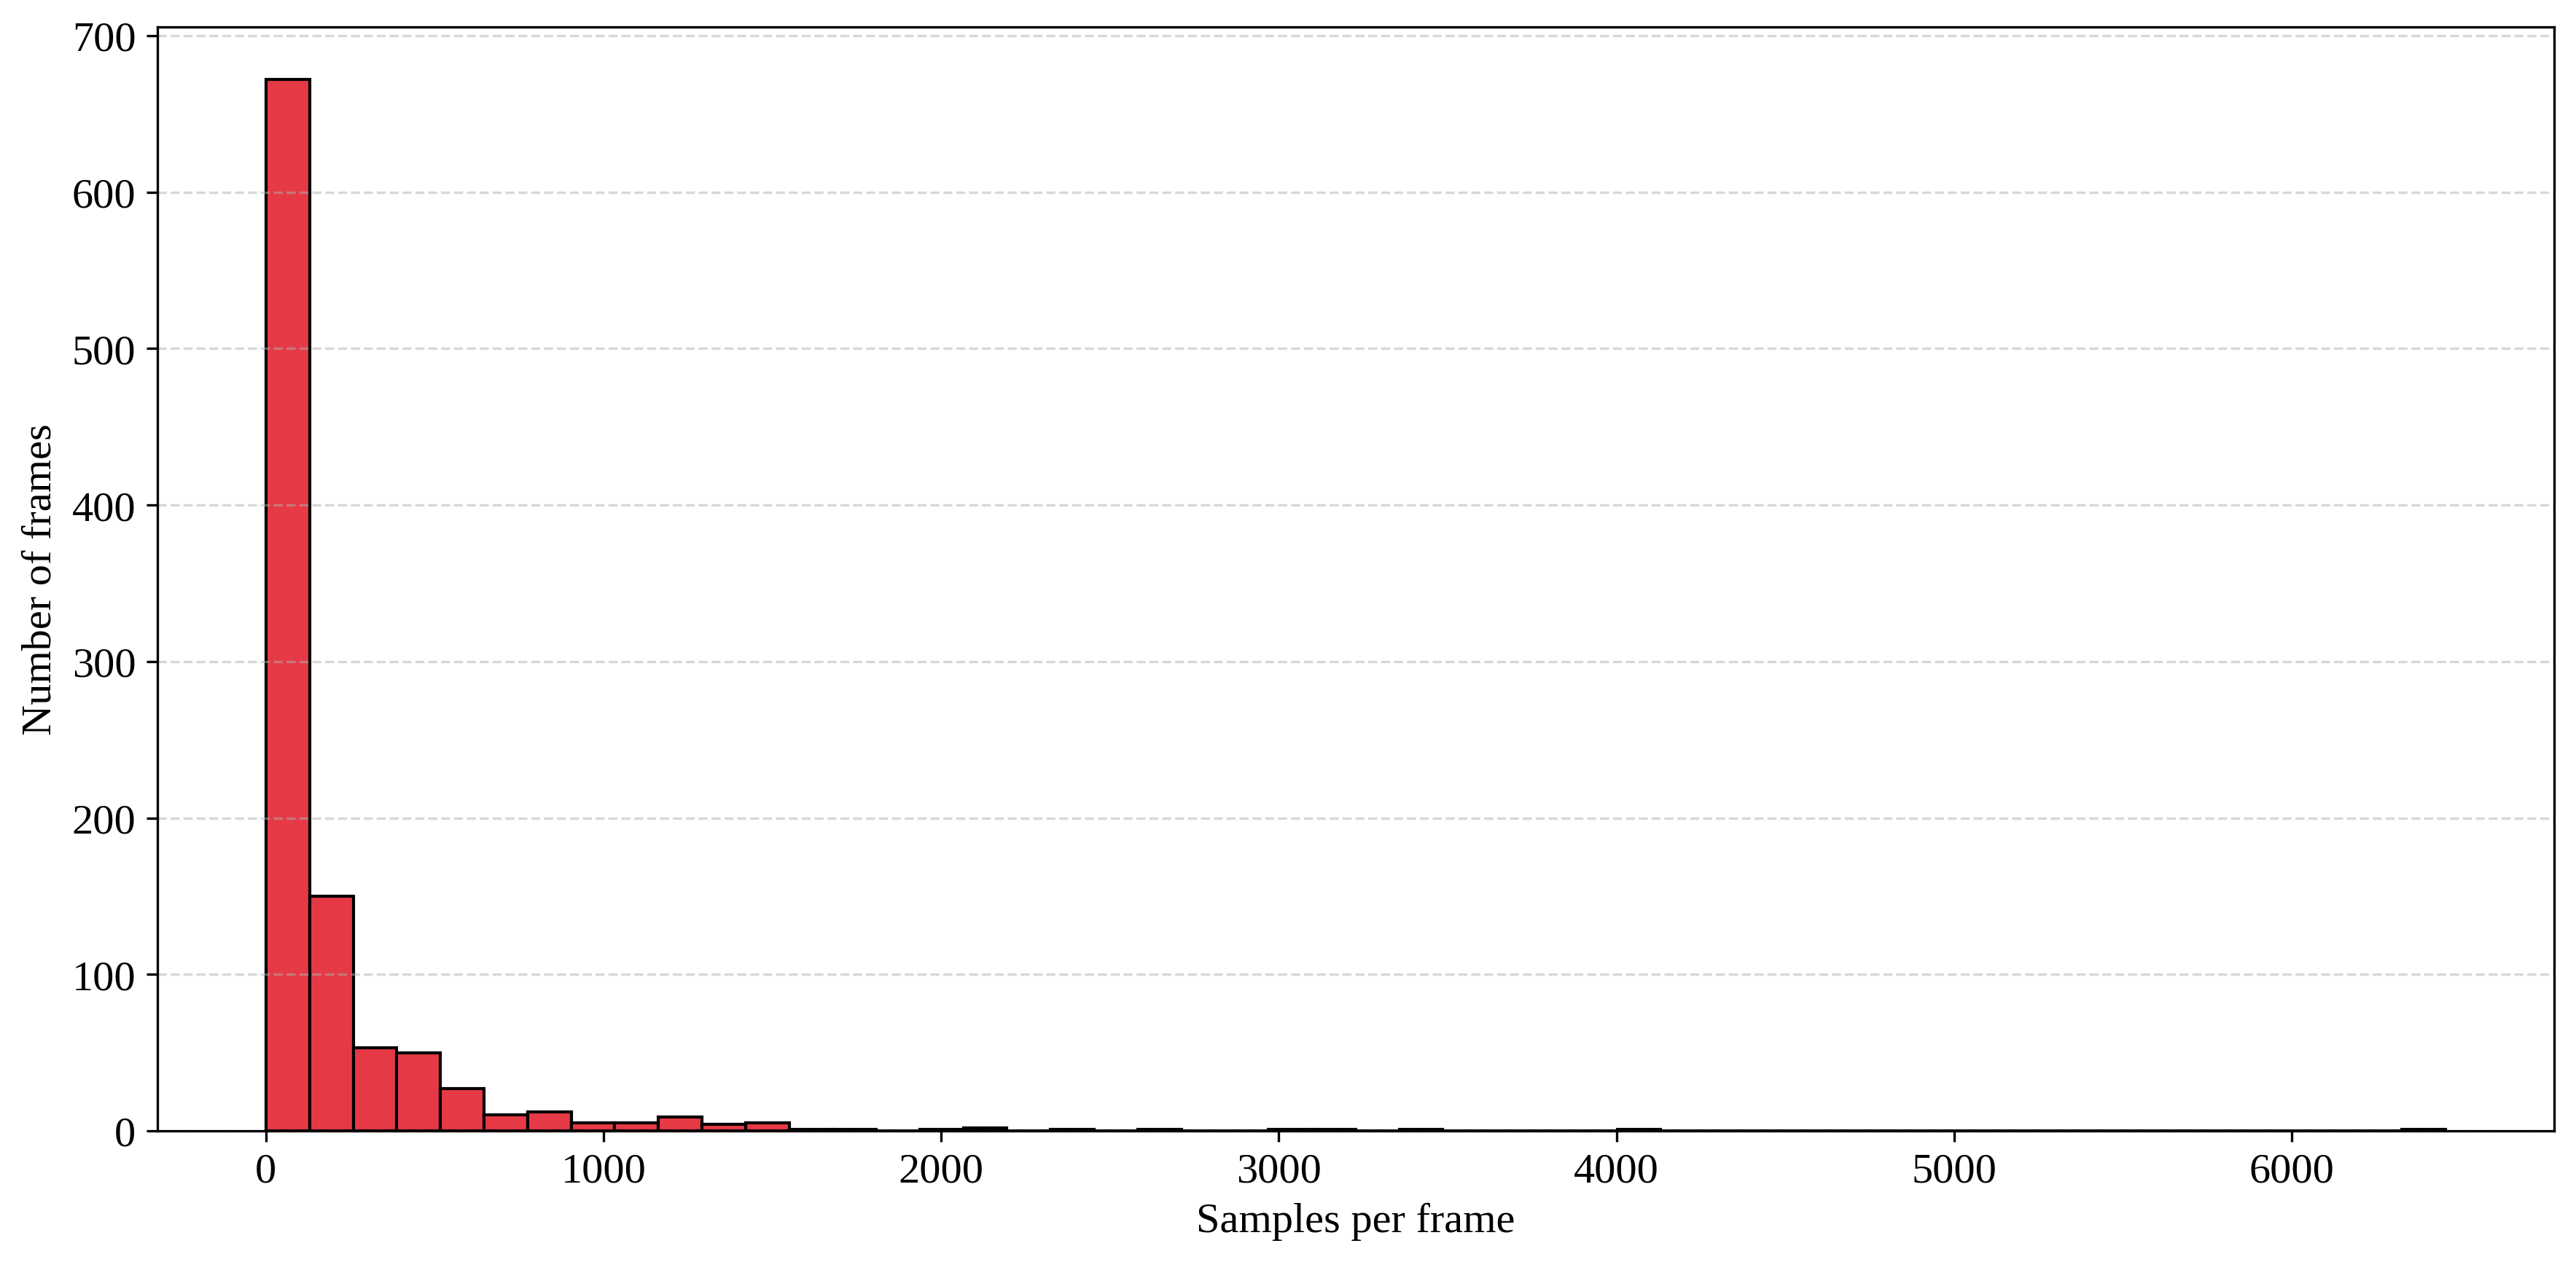

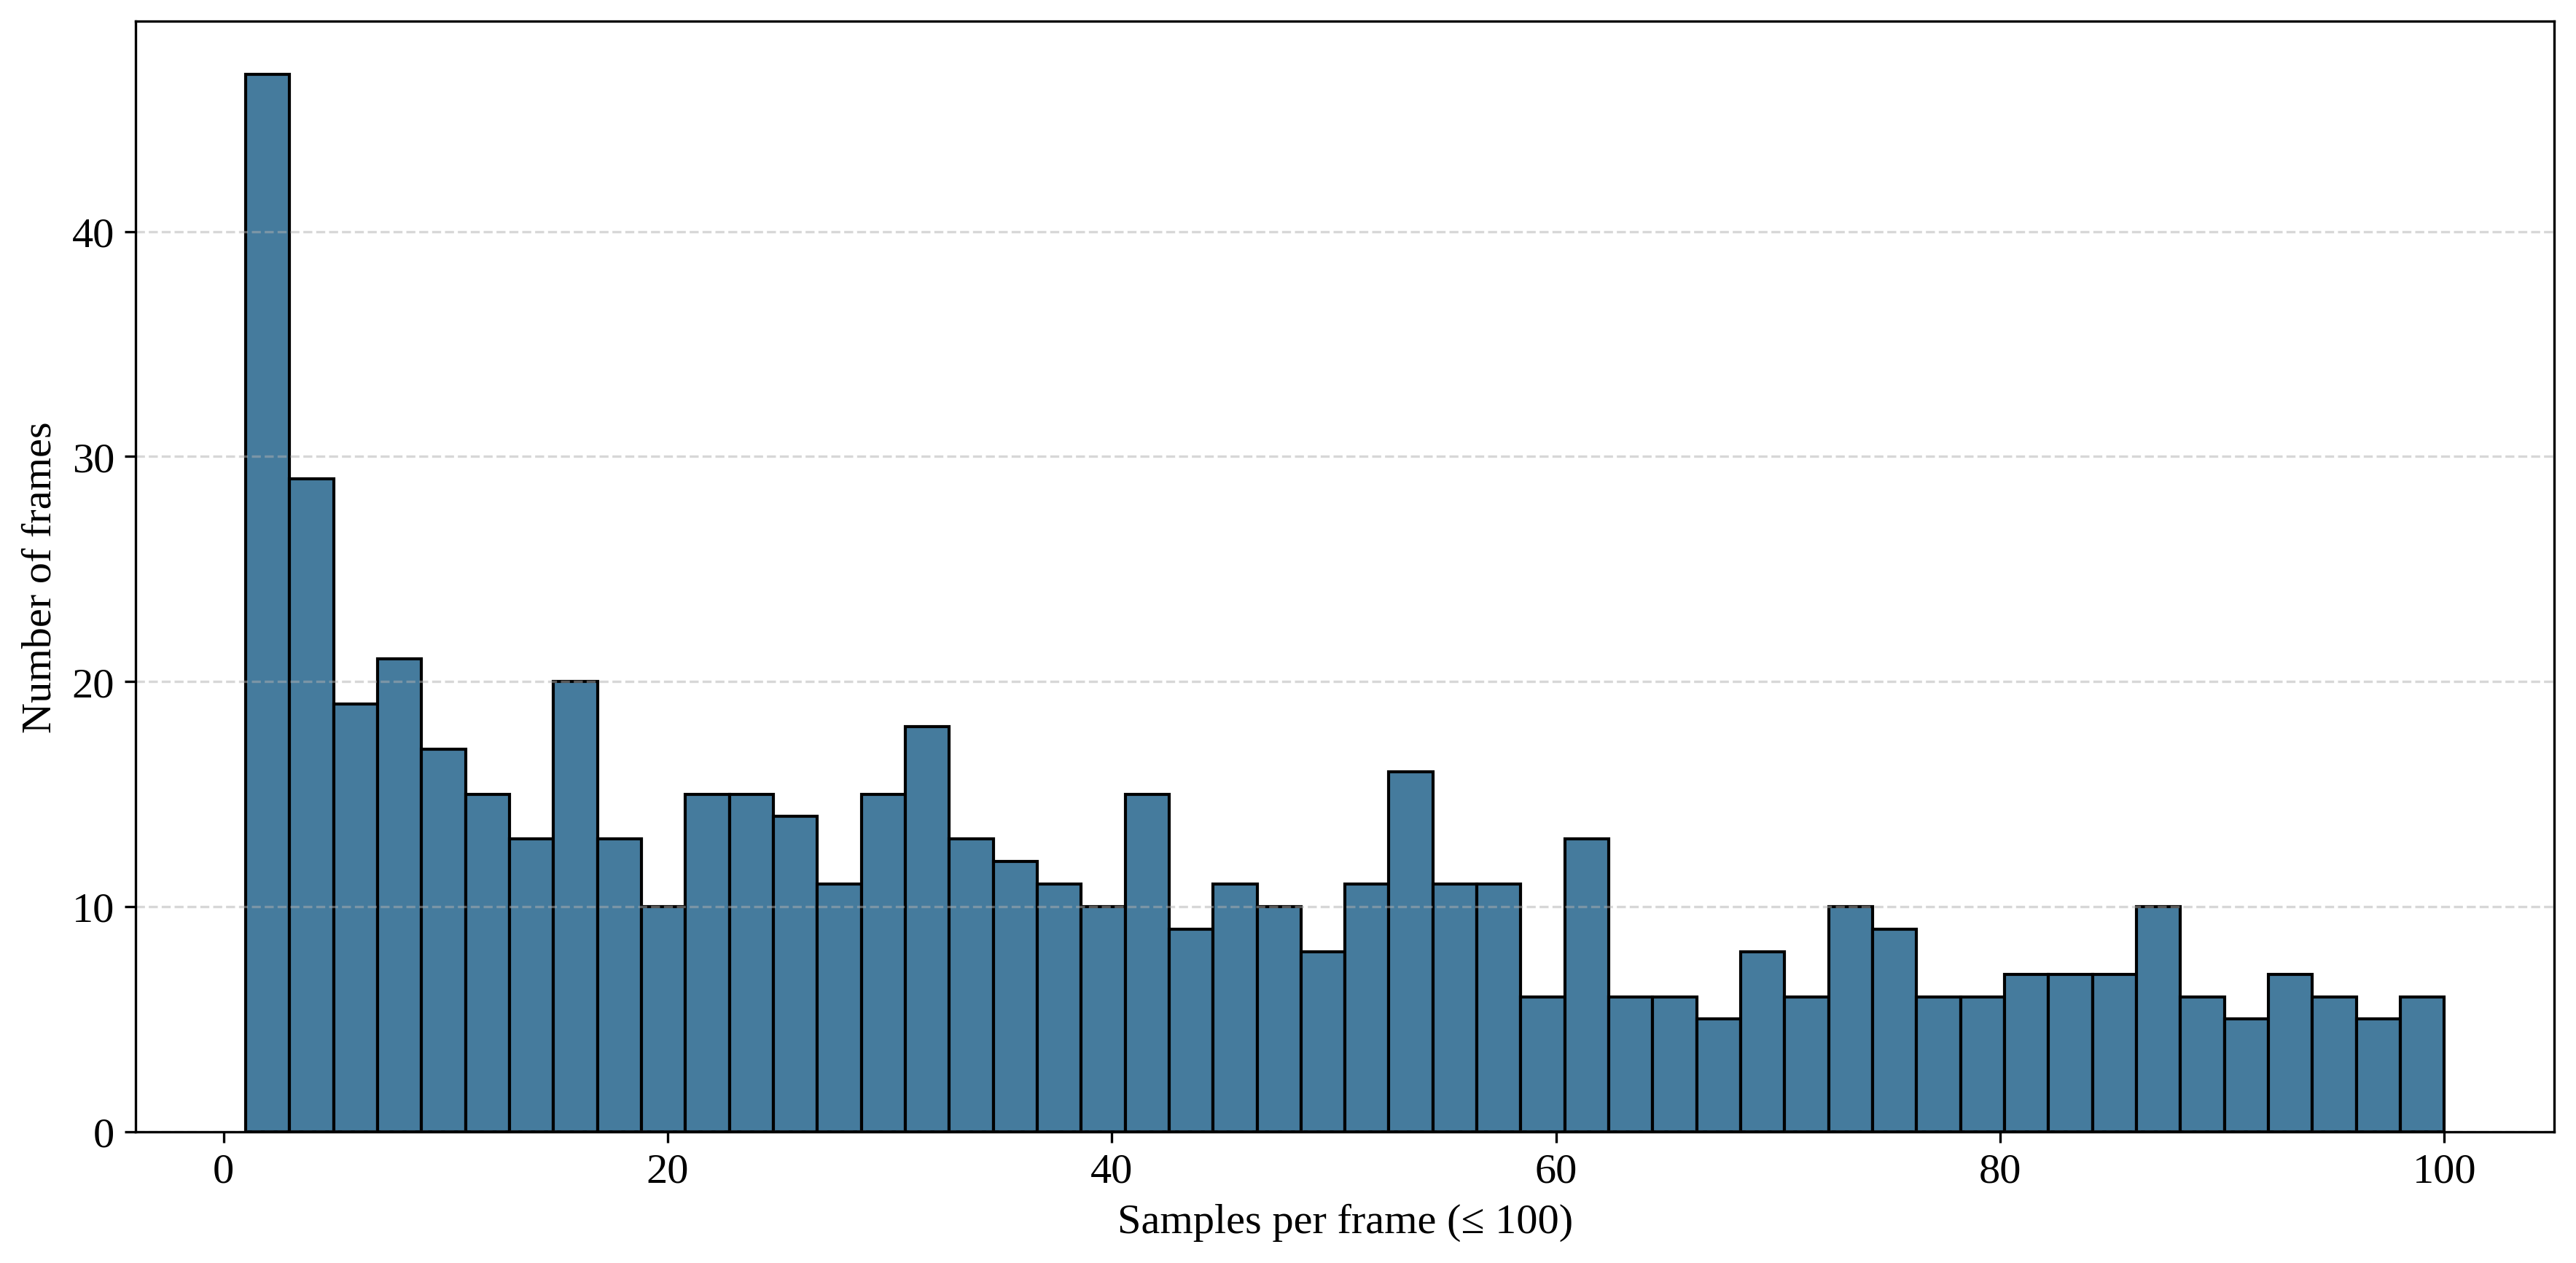

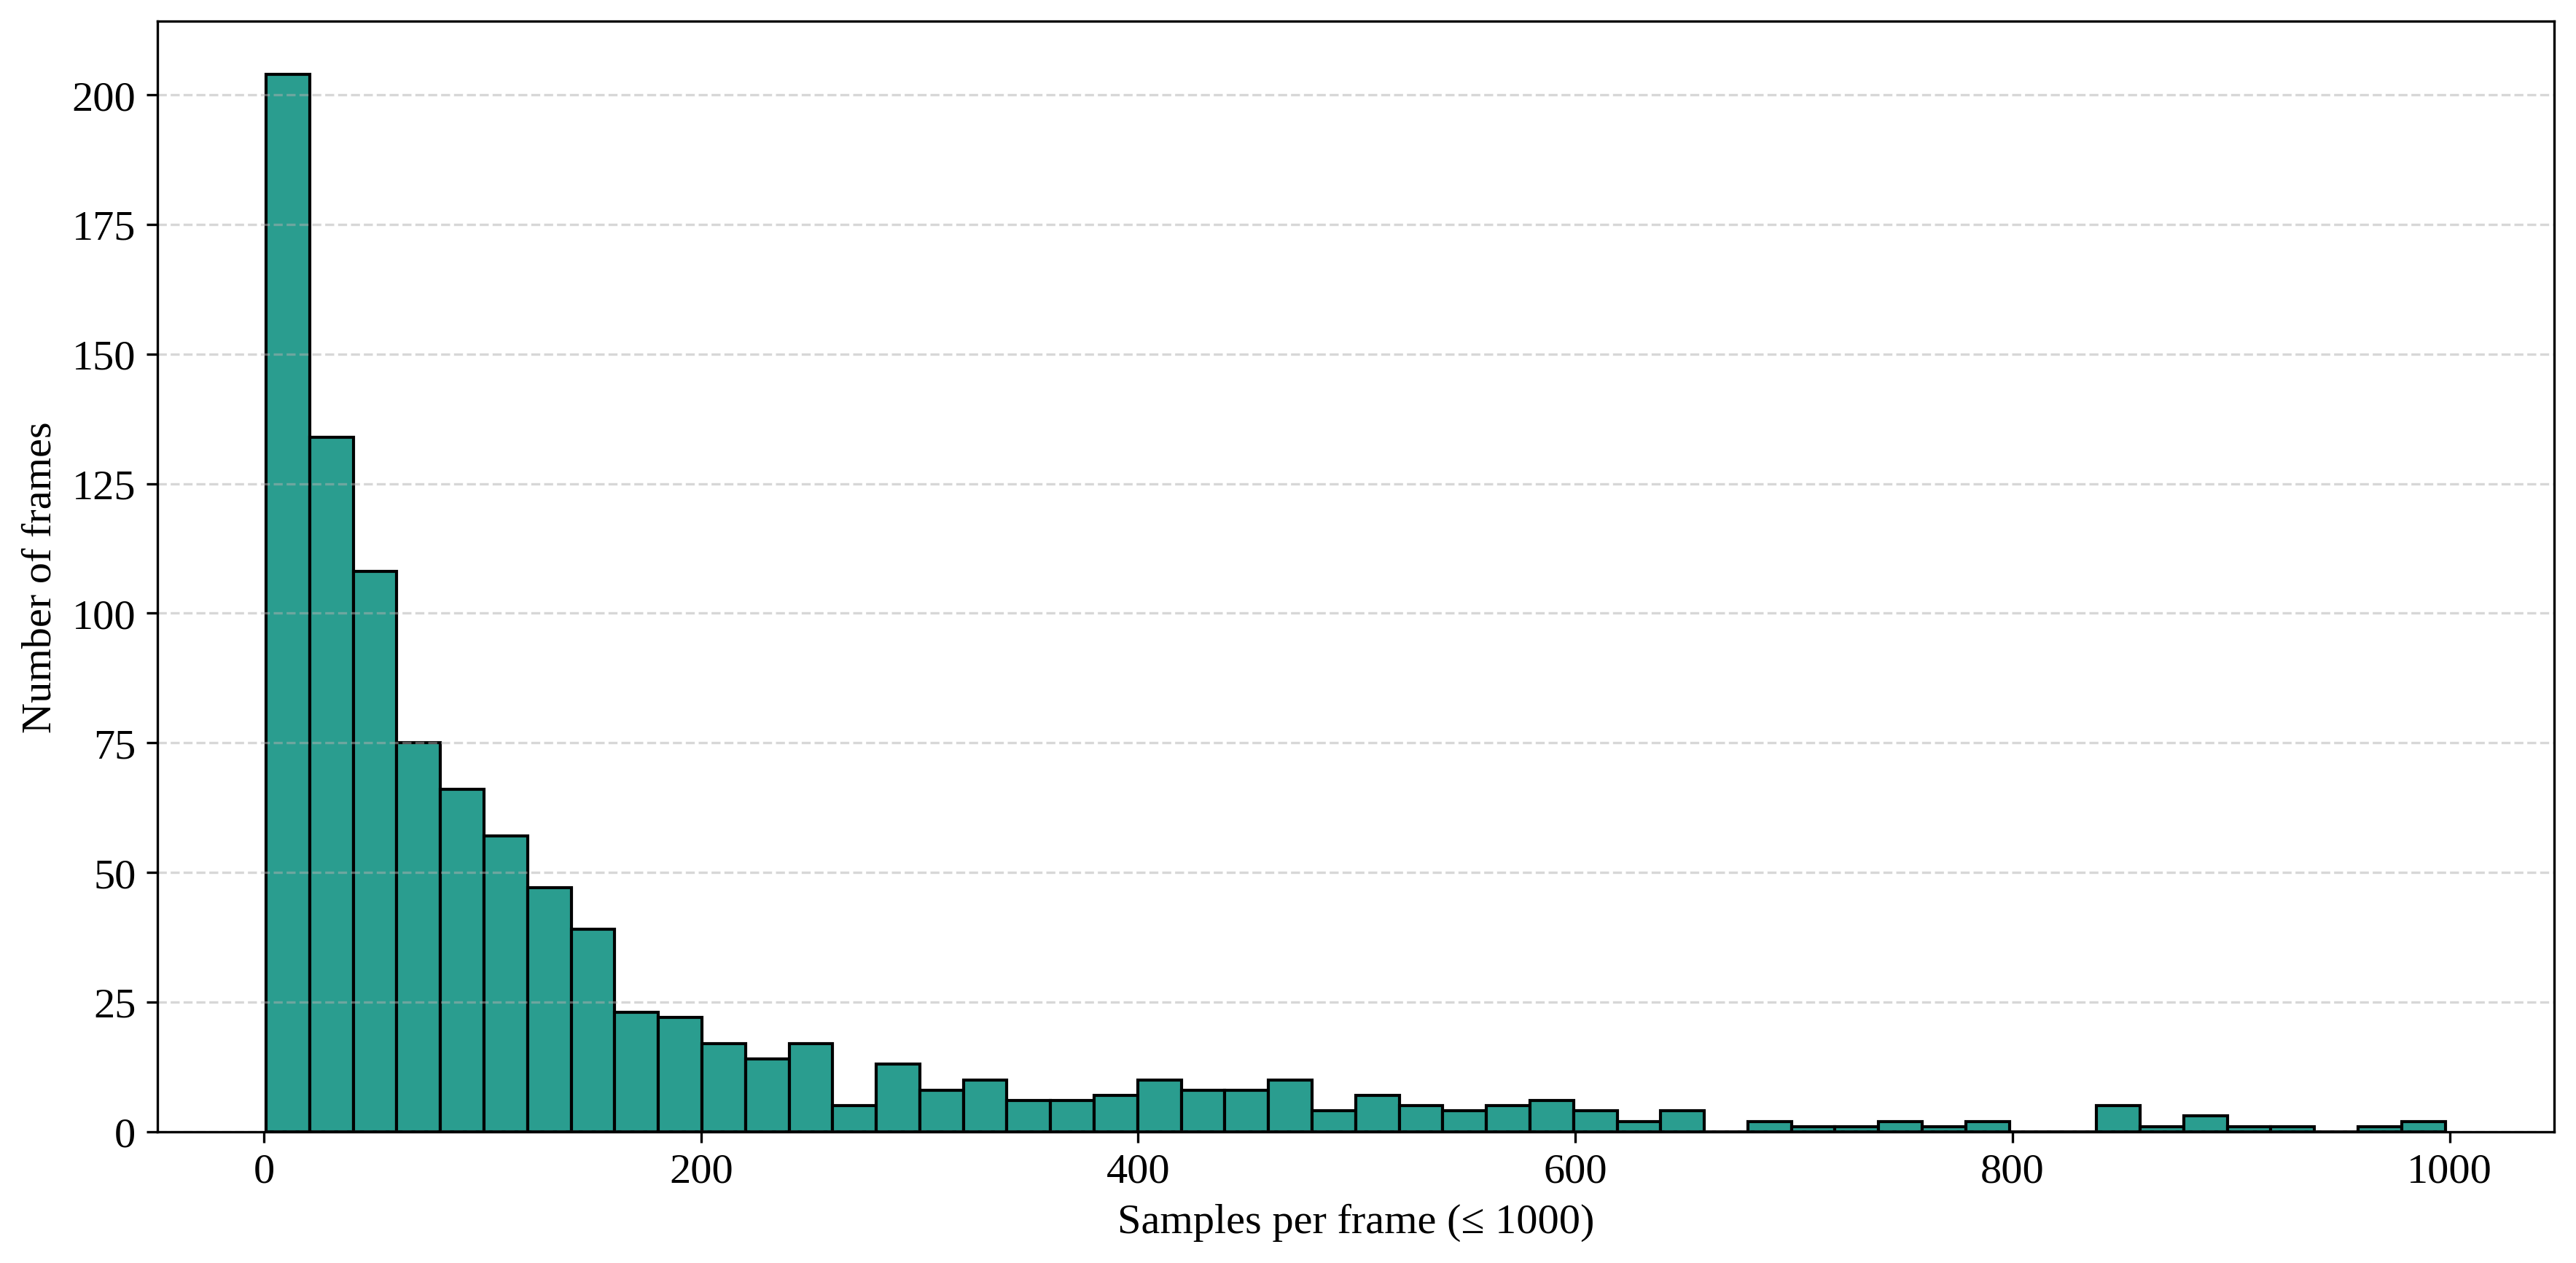

In [ ]:
import matplotlib.pyplot as plt

# ✅ 设置更大字体，便于Word缩放后仍清晰
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14  # 比原来更大，适合插入文档

# ✅ 获取每个 frame 的样本数
frame_counts = df['frame_name'].value_counts()

# ================= 图1：全集 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts.values, bins=50, color='#e63946', edgecolor='black')
plt.xlabel("Samples per frame")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_full_distribution_hd.png", dpi=300, bbox_inches='tight')  # 保存高清图
plt.show()

# ================= 图2：样本数 ≤ 100 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 100].values, bins=50, color='#457b9d', edgecolor='black')
plt.xlabel("Samples per frame (≤ 100)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under100_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()

# ================= 图3：样本数 ≤ 1000 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 1000].values, bins=50, color='#2a9d8f', edgecolor='black')
plt.xlabel("Samples per frame (≤ 1000)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under1000_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd
import pickle
import xml.etree.ElementTree as ET
from tqdm import tqdm

# === 你提供的原始函数，完全按照你的逻辑 ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

def add_pure_definition_column(file_path: str, output_path: str = None):
    """
    为pickle文件中的DataFrame添加纯定义列
    """
    print(f"Processing file: {file_path}")

    # 加载数据
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    # 如果数据是字典格式（包含dataframe键）
    if isinstance(data, dict) and "dataframe" in data:
        df = data["dataframe"]
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        print(f"Unexpected data format in {file_path}")
        return

    print(f"Original dataframe shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # 检查是否已经有pure_definition列
    if "pure_definition" in df.columns:
        print("pure_definition column already exists, will overwrite...")

    # 确定定义列的名称
    definition_column = None
    for col in ["frame_definition", "definition", "frame_def"]:
        if col in df.columns:
            definition_column = col
            break

    if definition_column is None:
        print("Warning: No definition column found. Looking for columns containing 'def'...")
        def_cols = [col for col in df.columns if 'def' in col.lower()]
        if def_cols:
            definition_column = def_cols[0]
            print(f"Using column: {definition_column}")
        else:
            print("Error: No definition column found!")
            return

    print(f"Using definition column: {definition_column}")

    # 应用纯定义提取
    print("Extracting pure definitions...")
    tqdm.pandas(desc="Processing definitions")
    df["pure_definition"] = df[definition_column].progress_apply(extract_pure_definition_from_markup)

    # 显示一些示例
    print("\nSample results:")
    for i in range(min(3, len(df))):
        print(f"\nExample {i+1}:")
        print(f"Original: {df.iloc[i][definition_column][:200]}...")
        print(f"Pure: {df.iloc[i]['pure_definition'][:200]}...")

    # 保存结果
    if output_path is None:
        output_path = file_path.replace(".pkl", "_with_pure_def.pkl")

    if isinstance(data, dict):
        data["dataframe"] = df
        save_data = data
    else:
        save_data = df

    with open(output_path, "wb") as f:
        pickle.dump(save_data, f)

    print(f"\nSaved to: {output_path}")
    print(f"Final dataframe shape: {df.shape}")

    return df

def main():
    """
    处理所有数据集文件
    """
    # 定义文件路径
    file_paths = {
        "train": "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "val": "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "test": "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    }

    processed_files = {}

    for dataset_name, file_path in file_paths.items():
        try:
            print(f"\n{'='*50}")
            print(f"Processing {dataset_name} dataset")
            print(f"{'='*50}")

            output_path = file_path.replace(".pkl", "_with_pure_def.pkl")
            df = add_pure_definition_column(file_path, output_path)
            processed_files[dataset_name] = output_path

            print(f"✅ Successfully processed {dataset_name} dataset")

        except FileNotFoundError:
            print(f"❌ File not found: {file_path}")
        except Exception as e:
            print(f"❌ Error processing {dataset_name}: {e}")

    print(f"\n{'='*50}")
    print("Summary of processed files:")
    print(f"{'='*50}")
    for dataset_name, output_path in processed_files.items():
        print(f"{dataset_name}: {output_path}")

if __name__ == "__main__":
    main()


Processing train dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
Unexpected data format in /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
✅ Successfully processed train dataset

Processing val dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/val_df.pkl
Original dataframe shape: (25179, 11)
Columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']
Using definition column: frame_definition
Extracting pure definitions...


Processing definitions: 100%|██████████| 25179/25179 [00:00<00:00, 143058.14it/s]



Sample results:

Example 1:
Original: These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Part_2.)  There is a symmetrical relationship between the components that undergo the process, and aft...
Pure: [ParseError]...

Example 2:
Original: An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belongs to the River Police.'  'It's a nuisance having to abandon my belongings, though.'...
Pure: [ParseError]...

Example 3:
Original: An Assessor examines a Phenomenon to figure out its Value according to some Feature of the Phenomenon.  This Value is a factor in determining the acceptability of the Phenomenon.  In some cases, a Met...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/val_df_with_pure_def.pkl
Final dataframe shape: (25179, 12)
✅ Successfully processed val dataset

Processing test dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
Origi

Processing definitions: 100%|██████████| 25579/25579 [00:00<00:00, 143092.78it/s]



Sample results:

Example 1:
Original: An Agent makes a particular facial expression, generally in response to some Internal_cause (generally an emotional state).  Sometimes the Body_part involved in the expression is mentioned in lieu of ...
Pure: [ParseError]...

Example 2:
Original: This frame contains nouns denoting Aggregates of Individuals.  The Aggregates may be described by an Aggregate_property.   'An army of postal workers descended on my office.'  ...
Pure: [ParseError]...

Example 3:
Original: This frame concerns people's knowledge or skill in certain domains.  It does not concern acquaintance or familiarity with people. With adjectives as targets in this frame, we annotate on two FE layers...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/test_df_with_pure_def.pkl
Final dataframe shape: (25579, 12)
✅ Successfully processed test dataset

Summary of processed files:
train: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced_

In [9]:
# @title 📦 Dataset Splitting with Stratified Sampling


split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
os.makedirs(split_save_dir, exist_ok=True)

train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path = os.path.join(split_save_dir, "val_df.pkl")
test_path = os.path.join(split_save_dir, "test_df.pkl")

def split_data_stratified(df, frame_relations, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42, force=False):
    """
    Perform stratified sampling to split the dataset, ensuring each frame is represented in all subsets.
    If split files already exist and force=False, skip re-splitting.

    Args:
        df: DataFrame containing sentences, target words, and frame labels
        frame_relations: Dictionary of frame-to-frame relationships
        train_ratio: Proportion of training set
        val_ratio: Proportion of validation set
        test_ratio: Proportion of test set
        random_state: Random seed
        force: If True, redo the split even if files exist

    Returns:
        train_df, val_df, test_df: Splitted DataFrames
    """
    if (not force
        and os.path.exists(train_path)
        and os.path.exists(val_path)
        and os.path.exists(test_path)):
        print("✅ Split files already exist. Skipping split (use force=True to regenerate).")
        with open(train_path, "rb") as f:
            train_df = pickle.load(f)
        with open(val_path, "rb") as f:
            val_df = pickle.load(f)
        with open(test_path, "rb") as f:
            test_df = pickle.load(f)
        return train_df, val_df, test_df

    # --- your original splitting logic starts here ---
    from collections import defaultdict
    import numpy as np

    print("Grouping by sentence...")
    sentence_groups = {}
    for idx, row in df.iterrows():
        sentence = row['sentence']
        if sentence not in sentence_groups:
            sentence_groups[sentence] = []
        sentence_groups[sentence].append(idx)

    print("Collecting sentences for each frame...")
    frame_sentences = defaultdict(set)
    for sentence, indices in sentence_groups.items():
        frames = set(df.loc[idx, 'frame_name'] for idx in indices)
        for frame in frames:
            frame_sentences[frame].add(sentence)

    frame_counts = {frame: len(sentences) for frame, sentences in frame_sentences.items()}
    print(f"Total number of frames: {len(frame_counts)}")

    rare_frames = {f: c for f, c in frame_counts.items() if c < 5}
    medium_frames = {f: c for f, c in frame_counts.items() if 5 <= c < 20}
    common_frames = {f: c for f, c in frame_counts.items() if c >= 20}

    print(f"Rare frames (<5 sentences): {len(rare_frames)}")
    print(f"Medium-frequency frames (5–19 sentences): {len(medium_frames)}")
    print(f"Common frames (≥20 sentences): {len(common_frames)}")

    train_sentences, val_sentences, test_sentences = set(), set(), set()
    rare_frame_sentences = set()
    for frame in rare_frames:
        rare_frame_sentences.update(frame_sentences[frame])

    np.random.seed(random_state)

    for frame in common_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    for frame in medium_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = max(n // 2, 2)
        remaining = n - n_train
        n_val = remaining // 2
        n_test = remaining - n_val
        if n_val == 0 and n > 2:
            n_val = 1
            n_train -= 1
        if n_test == 0 and n > 2:
            n_test = 1
            n_train -= 1
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    train_sentences.update(rare_frame_sentences)
    val_sentences -= train_sentences
    test_sentences -= train_sentences | val_sentences

    print(f"Number of training sentences: {len(train_sentences)}")
    print(f"Number of validation sentences: {len(val_sentences)}")
    print(f"Number of test sentences: {len(test_sentences)}")

    train_indices = [idx for s in train_sentences for idx in sentence_groups.get(s, [])]
    val_indices = [idx for s in val_sentences for idx in sentence_groups.get(s, [])]
    test_indices = [idx for s in test_sentences for idx in sentence_groups.get(s, [])]

    train_df = df.loc[train_indices].reset_index(drop=True)
    val_df = df.loc[val_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)

    train_frames = set(train_df['frame_name'])
    val_frames = set(val_df['frame_name'])
    test_frames = set(test_df['frame_name'])

    print(f"Number of frames in training set: {len(train_frames)}")
    print(f"Number of frames in validation set: {len(val_frames)}")
    print(f"Number of frames in test set: {len(test_frames)}")
    print(f"Validation-only frames: {len(val_frames - train_frames)}")
    print(f"Test-only frames: {len(test_frames - train_frames)}")

    for i in range(1, 6):
        exact_frames = [f for f, c in frame_counts.items() if c == i]
        print(f"Frames with exactly {i} sentence(s): {len(exact_frames)}")
        if exact_frames:
            print(f"  → Frame names: {', '.join(exact_frames)}")

    # Save to disk
    with open(train_path, "wb") as f:
        pickle.dump(train_df, f)
    with open(val_path, "wb") as f:
        pickle.dump(val_df, f)
    with open(test_path, "wb") as f:
        pickle.dump(test_df, f)
    print("✅ Saved train/val/test splits to disk.")

    return train_df, val_df, test_df


# Apply stratified dataset split
train_df, val_df, test_df = split_data_stratified(df, frame_relations)

frame_freq_df = df['frame_name'].value_counts().reset_index()
frame_freq_df.columns = ['frame_name', 'sentence_count']
frame_freq_df = frame_freq_df.sort_values(by='sentence_count', ascending=False).reset_index(drop=True)


✅ Split files already exist. Skipping split (use force=True to regenerate).


In [14]:
# @title 📊 Exemplar Dataset Statistics



import pandas as pd
import os

# ✅ 1. Set paths for exemplar dataset
split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path   = os.path.join(split_save_dir, "val_df.pkl")
test_path  = os.path.join(split_save_dir, "test_df.pkl")

# ✅ 2. Load splits
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# Combine to create the full exemplar dataset
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# ✅ 3. Statistics function
def analyze_exemplar_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples   = len(subset)
        num_frames    = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\n📂 {name} subset statistics:")
        print(f"   → Number of samples (#Samples): {num_samples:,}")
        print(f"   → Number of frames (#Frames): {num_frames:,}")
        print(f"   → Number of sentences (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = os.path.join(split_save_dir, "exemplar_split_summary.xlsx")
        summary_df.to_excel(save_path, index=False)
        print(f"\n✅ Summary table saved to: {save_path}")

    return summary_df

# ✅ 4. Execute
summary_df = analyze_exemplar_splits(all_df, train_df, val_df, test_df)



📂 All subset statistics:
   → Number of samples (#Samples): 200,750
   → Number of frames (#Frames): 1,014
   → Number of sentences (#Sentences): 171,664

📂 Train subset statistics:
   → Number of samples (#Samples): 150,110
   → Number of frames (#Frames): 1,014
   → Number of sentences (#Sentences): 121,901

📂 Val subset statistics:
   → Number of samples (#Samples): 25,113
   → Number of frames (#Frames): 906
   → Number of sentences (#Sentences): 24,553

📂 Test subset statistics:
   → Number of samples (#Samples): 25,527
   → Number of frames (#Frames): 907
   → Number of sentences (#Sentences): 25,210

✅ Summary table saved to: /content/drive/MyDrive/more50/framenet_data/exemplar_split_summary.xlsx


In [16]:
# @title 📊 Fulltext Dataset Statistics - OpenSesame

import pandas as pd
import os

# ✅ 1. Set paths for exemplar dataset
full_path = "/content/drive/MyDrive/Open_sesame/framenet_data/framenet_data.pkl"  # fulltext full dataset path
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ✅ 2. Load datasets
all_df   = pd.read_pickle(full_path)  # this is still fulltext full dataset, change if exemplar full file exists
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# ✅ 3. Statistics function
def analyze_exemplar_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples   = len(subset)
        num_frames    = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\n📂 {name} subset statistics:")
        print(f"   → Number of samples (#Samples): {num_samples:,}")
        print(f"   → Number of frames (#Frames): {num_frames:,}")
        print(f"   → Number of sentences (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = "/content/drive/MyDrive/Open_sesame/framenet_data/exemplar_split_summary.xlsx"
        summary_df.to_excel(save_path, index=False)
        print(f"\n✅ Summary table saved to: {save_path}")

    return summary_df

# ✅ 4. Execute
summary_df = analyze_exemplar_splits(all_df, train_df, val_df, test_df)




📂 All subset statistics:
   → Number of samples (#Samples): 29,359
   → Number of frames (#Frames): 796
   → Number of sentences (#Sentences): 4,924

📂 Train subset statistics:
   → Number of samples (#Samples): 20,105
   → Number of frames (#Frames): 753
   → Number of sentences (#Sentences): 3,353

📂 Val subset statistics:
   → Number of samples (#Samples): 2,382
   → Number of frames (#Frames): 368
   → Number of sentences (#Sentences): 326

📂 Test subset statistics:
   → Number of samples (#Samples): 6,872
   → Number of frames (#Frames): 574
   → Number of sentences (#Sentences): 1,247

✅ Summary table saved to: /content/drive/MyDrive/Open_sesame/framenet_data/exemplar_split_summary.xlsx


In [26]:
import pandas as pd

# ✅ 1. Load the three datasets
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# ✅ 2. Get unique frame sets
train_frames = set(train_df["frame_name"].unique())
val_frames   = set(val_df["frame_name"].unique())
test_frames  = set(test_df["frame_name"].unique())

# ✅ 3. Find exclusive frames
exclusive_train = train_frames - (val_frames | test_frames)
exclusive_val   = val_frames - (train_frames | test_frames)
exclusive_test  = test_frames - (train_frames | val_frames)

# ✅ 4. Find overlaps
train_val_overlap = train_frames & val_frames
train_test_overlap = train_frames & test_frames
val_test_overlap = val_frames & test_frames
all_three_overlap = train_frames & val_frames & test_frames

# ✅ 5. Print summary
print("\n=== Frame Overlap & Exclusive Analysis ===")
print(f"Train unique frames: {len(train_frames)}")
print(f"Val unique frames:   {len(val_frames)}")
print(f"Test unique frames:  {len(test_frames)}")

print(f"\nExclusive to Train: {len(exclusive_train)} → {sorted(list(exclusive_train))}")
print(f"Exclusive to Val:   {len(exclusive_val)} → {sorted(list(exclusive_val))}")
print(f"Exclusive to Test:  {len(exclusive_test)} → {sorted(list(exclusive_test))}")

print(f"\nOverlap (Train ∩ Val): {len(train_val_overlap)}")
print(f"Overlap (Train ∩ Test): {len(train_test_overlap)}")
print(f"Overlap (Val ∩ Test):   {len(val_test_overlap)}")
print(f"Overlap (all three):    {len(all_three_overlap)}")



=== Frame Overlap & Exclusive Analysis ===
Train unique frames: 753
Val unique frames:   368
Test unique frames:  574

Exclusive to Train: 183 → ['Abandonment', 'Abundance', 'Activity_resume', 'Actually_occurring_entity', 'Aging', 'Aiming', 'Animals', 'Apply_heat', 'Appointing', 'Arraignment', 'Arson', 'Attempt_means', 'Attitude_description', 'Awareness_status', 'Bail_decision', 'Be_subset_of', 'Becoming_dry', 'Behind_the_scenes', 'Being_in_captivity', 'Being_in_control', 'Being_incarcerated', 'Being_relevant', 'Being_wet', 'Besieging', 'Billing', 'Biological_entity', 'Body_mark', 'Breaking_out_captive', 'Breathing', 'Catching_fire', 'Cause_bodily_experience', 'Cause_change_of_phase', 'Cause_change_of_strength', 'Cause_emotion', 'Cause_fluidic_motion', 'Cause_impact', 'Cause_to_experience', 'Cause_to_make_noise', 'Cause_to_move_in_place', 'Change_of_phase', 'Change_operational_state', 'Change_post-state', 'Change_tool', 'Co-association', 'Color_qualities', 'Come_down_with', 'Communica

In [20]:
# ============================================
#  @title 📊 FE-only Frame Classification (Exemplar)
# Rebuild FE prototypes & preferences from train set,
# evaluate on the given val_df path.
# Paths are hard-coded as requested.
# ============================================

# -------------------------
# 0) Paths (hard-coded)
# -------------------------
split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path   = os.path.join(split_save_dir, "val_df.pkl")  # <-- use THIS path to load val set (as you asked)

# -------------------------
# 1) Load data
# -------------------------
print("📦 Loading datasets...")
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
print(f"✅ Loaded train_df: {train_df.shape}, val_df: {val_df.shape}")

# -------------------------
# 2) Model & tokenizer
# -------------------------
model_name = "distilbert-base-uncased"  # keep consistent with your project unless you change it
print(f"🧠 Loading model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
print(f"✅ Device: {device}")

# -------------------------------------------------
# 3) Utilities: batch encoding with offset mapping
# -------------------------------------------------
def encode_batch_with_offsets(sentences, tokenizer, max_length=512, device="cpu"):
    """
    Tokenize a list of sentences and return encoding on device,
    keeping offset_mapping on CPU for span to token alignment.
    """
    encoding = tokenizer(
        sentences,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
    )
    # Move tensors used by the model to device; keep offsets on CPU
    model_inputs = {
        "input_ids": encoding["input_ids"].to(device, non_blocking=True),
        "attention_mask": encoding["attention_mask"].to(device, non_blocking=True),
    }
    offset_mappings = encoding["offset_mapping"]  # CPU
    return model_inputs, offset_mappings

def mean_token_embedding(hidden_states, token_indices):
    """Mean-pool hidden states at token_indices (unique)."""
    if not token_indices:
        return None
    unique = sorted(set(token_indices))
    return hidden_states[unique, :].mean(dim=0)

def char_span_to_token_indices(offset_mapping, start_char, end_char):
    """
    Map a character span [start_char, end_char) to token indices using offset_mapping.
    """
    idxs = []
    for tidx, (s, e) in enumerate(offset_mapping.tolist()):
        if s == 0 and e == 0:  # special tokens
            continue
        # overlap condition
        if s < end_char and e > start_char and s != e:
            idxs.append(tidx)
    return idxs

# -------------------------------------------------------------------
# 4) Build FE preferences from train set (top-K FE types per frame)
# -------------------------------------------------------------------
def build_frame_fe_preferences(train_df, top_k=3):
    """
    For each frame, find top-K most frequent FE types from train_df['fe_spans'].
    Expects fe_spans as a list of dicts with keys: fe_name, start, end.
    """
    frame_fe_counts = defaultdict(Counter)
    for _, row in train_df.iterrows():
        frame = row["frame_name"]
        fe_spans = row.get("fe_spans", [])
        if isinstance(fe_spans, list):
            for fe in fe_spans:
                if isinstance(fe, dict) and "fe_name" in fe:
                    frame_fe_counts[frame][fe["fe_name"]] += 1

    frame_fe_prefs = {}
    for frame, counter in frame_fe_counts.items():
        # keep top_k by frequency (ties broken arbitrarily by Counter)
        prefs = [fe for fe, _ in counter.most_common(top_k)]
        frame_fe_prefs[frame] = prefs

    return frame_fe_prefs

print("🧭 Building FE preferences (top-3 per frame) from train set...")
frame_fe_preferences = build_frame_fe_preferences(train_df, top_k=3)
print(f"✅ Built FE preferences for {len(frame_fe_preferences)} frames.")

# -------------------------------------------------------------
# 5) Build FE prototypes from train set (mean-pooled embeddings)
# -------------------------------------------------------------
def build_frame_fe_prototypes(train_df, frame_fe_prefs, model, tokenizer, device, batch_size=64):
    """
    For each frame and each preferred FE in that frame, compute a prototype
    as the mean embedding over all its occurrences in the train set.
    Returns: dict[frame_name] -> dict[fe_name] -> torch.Tensor (on device)
    """
    # Accumulators
    proto_sum = defaultdict(lambda: defaultdict(lambda: torch.zeros(model.config.hidden_size, device=device)))
    proto_cnt = defaultdict(lambda: defaultdict(int))

    sentences = train_df["sentence"].tolist()
    fe_spans_list = train_df["fe_spans"].tolist()
    frames = train_df["frame_name"].tolist()

    print("🧱 Building FE prototypes from train set...")
    for start in tqdm(range(0, len(sentences), batch_size), desc="Proto batching"):
        end = min(start + batch_size, len(sentences))
        batch_sents = sentences[start:end]
        batch_fes   = fe_spans_list[start:end]
        batch_frames= frames[start:end]

        # encode
        model_inputs, offset_mappings = encode_batch_with_offsets(batch_sents, tokenizer, device=device)
        with torch.no_grad():
            outputs = model(**model_inputs)
            hidden = outputs.last_hidden_state  # [B, T, H]

        for i in range(len(batch_sents)):
            frame = batch_frames[i]
            prefs = frame_fe_prefs.get(frame, [])
            if not prefs:
                continue

            offset_map = offset_mappings[i]
            sample_fes = batch_fes[i] if isinstance(batch_fes[i], list) else []
            # group by fe_name
            fes_by_name = defaultdict(list)
            for fe in sample_fes:
                if isinstance(fe, dict) and "fe_name" in fe and "start" in fe and "end" in fe:
                    fes_by_name[fe["fe_name"]].append((int(fe["start"]), int(fe["end"])))

            # for each preferred FE, compute mean embedding of all its spans in this sample
            for fe_name in prefs:
                if fe_name not in fes_by_name:
                    continue
                token_indices = []
                for (s_char, e_char) in fes_by_name[fe_name]:
                    token_indices.extend(char_span_to_token_indices(offset_map, s_char, e_char))

                if token_indices:
                    emb = mean_token_embedding(hidden[i], token_indices)  # [H]
                    if emb is not None:
                        proto_sum[frame][fe_name] += emb
                        proto_cnt[frame][fe_name] += 1

    # finalise prototypes
    frame_fe_prototypes = {}
    for frame, fe_map in proto_sum.items():
        frame_fe_prototypes[frame] = {}
        for fe_name, sum_vec in fe_map.items():
            cnt = proto_cnt[frame][fe_name]
            if cnt > 0:
                frame_fe_prototypes[frame][fe_name] = (sum_vec / cnt)
    print(f"✅ Built FE prototypes for {len(frame_fe_prototypes)} frames.")
    return frame_fe_prototypes

frame_fe_prototypes = build_frame_fe_prototypes(
    train_df, frame_fe_preferences, model, tokenizer, device, batch_size=64
)

# -------------------------------------------------------------
# 6) FE-only evaluation on val_df
# -------------------------------------------------------------
def extract_fe_embeddings_batch(sentences, fe_spans_list, allowed_fe_names, model, tokenizer, device, batch_size=64):
    """
    Extract FE embeddings per sample as {fe_name: embedding (np.array)}.
    Only keep FE types in allowed_fe_names.
    """
    all_fe_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}
    model.eval()

    for start in tqdm(range(0, len(sentences), batch_size), desc="🔎 FE embedding batches", leave=False):
        end = min(start + batch_size, len(sentences))
        batch_sents = sentences[start:end]
        batch_fes   = fe_spans_list[start:end]

        model_inputs, offset_mappings = encode_batch_with_offsets(batch_sents, tokenizer, device=device)
        with torch.no_grad():
            hidden = model(**model_inputs).last_hidden_state  # [B, T, H]

        for i in range(len(batch_sents)):
            fe_dict = {}
            try:
                offset_map = offset_mappings[i]
                fe_spans = batch_fes[i] if isinstance(batch_fes[i], list) else []
                for fe in fe_spans:
                    if (
                        isinstance(fe, dict)
                        and "fe_name" in fe
                        and fe["fe_name"] in allowed_fe_names
                        and "start" in fe and "end" in fe
                    ):
                        idxs = char_span_to_token_indices(offset_map, int(fe["start"]), int(fe["end"]))
                        if idxs:
                            emb = mean_token_embedding(hidden[i], idxs)
                            if emb is not None:
                                fe_dict[fe["fe_name"]] = emb.detach().cpu().numpy()
                all_fe_embeddings.append(fe_dict)
                stats["success"] += int(bool(fe_dict))
                stats["failed"]  += int(not bool(fe_dict))
            except Exception:
                all_fe_embeddings.append({})
                stats["failed"] += 1

    return all_fe_embeddings, stats

def fe_only_classification(val_df, frame_fe_prototypes, frame_fe_prefs, model, tokenizer, device):
    """
    FE-only frame classification on val_df using cosine similarity to FE prototypes.
    """
    print("\n🧪 Running FE-only frame classification on val set...")
    val_sentences = val_df["sentence"].tolist()
    val_fe_spans  = val_df["fe_spans"].tolist()
    val_gold      = val_df["frame_name"].tolist()

    # collect all FE types appearing in preferences (universe of allowed FEs)
    all_preferred_fes = set()
    for fes in frame_fe_prefs.values():
        all_preferred_fes.update(fes)
    all_preferred_fes = list(all_preferred_fes)
    print(f"📊 Number of preferred FE types (union): {len(all_preferred_fes)}")

    print("⚡ Extracting FE embeddings for queries...")
    query_fe_embs, fe_stats = extract_fe_embeddings_batch(
        val_sentences, val_fe_spans, all_preferred_fes, model, tokenizer, device, batch_size=64
    )
    print(f"✅ Done: success {fe_stats['success']}, failed {fe_stats['failed']}")

    frames = list(frame_fe_prototypes.keys())
    predictions = []
    stats = {
        "total_samples": len(val_df),
        "samples_with_fes": 0,
        "samples_without_fes": 0,
        "fe_predictions": 0,
        "random_predictions": 0,
    }

    print("🔄 Scoring by mean cosine similarity...")
    for i in tqdm(range(len(query_fe_embs)), desc="🔍 Similarity & prediction"):
        q = query_fe_embs[i]
        if not q:
            # fallback: deterministic fallback to first frame for reproducibility
            predictions.append(frames[0] if frames else None)
            stats["samples_without_fes"] += 1
            stats["random_predictions"]  += 1
            continue

        stats["samples_with_fes"] += 1
        frame_scores = {}
        for frame in frames:
            prefs = frame_fe_prefs.get(frame, [])
            fe_protos = frame_fe_prototypes.get(frame, {})
            total, cnt = 0.0, 0
            for fe_name, q_vec in q.items():
                if fe_name in prefs and fe_name in fe_protos:
                    q_tensor = torch.tensor(q_vec, device=device)
                    p_tensor = fe_protos[fe_name]  # already on device
                    sim = F.cosine_similarity(q_tensor, p_tensor, dim=0).item()
                    total += sim
                    cnt += 1
            frame_scores[frame] = (total / cnt) if cnt > 0 else 0.0

        if frame_scores and max(frame_scores.values()) > 0:
            pred = max(frame_scores, key=frame_scores.get)
            stats["fe_predictions"] += 1
        else:
            pred = frames[0] if frames else None
            stats["random_predictions"] += 1

        predictions.append(pred)

    # compute metrics
    correct = sum(int(p == g) for p, g in zip(predictions, val_gold))
    fe_correct = sum(int(p == g) for p, g, emb in zip(predictions, val_gold, query_fe_embs) if emb)

    overall_acc = correct / stats["total_samples"] if stats["total_samples"] > 0 else 0.0
    fe_only_acc = (fe_correct / stats["samples_with_fes"]) if stats["samples_with_fes"] > 0 else 0.0
    fe_coverage = stats["samples_with_fes"] / stats["total_samples"] if stats["total_samples"] > 0 else 0.0

    # pretty print
    print("\n📊 FE-only classification results:")
    print(f"   Total samples:          {stats['total_samples']:,}")
    print(f"   Samples with FEs:       {stats['samples_with_fes']:,}")
    print(f"   Samples without FEs:    {stats['samples_without_fes']:,}")
    print(f"   Overall accuracy:       {overall_acc:.4f}")
    print(f"   Accuracy on FE samples: {fe_only_acc:.4f}")
    print(f"   FE coverage:            {fe_coverage:.2%}")

    # quick qualitative conclusion
    if fe_only_acc > 0:
        print("\n💡 Conclusion:")
        if fe_only_acc >= 0.6:
            print(f"   ✅ FEs show strong independent discriminative power ({fe_only_acc:.1%})")
        elif fe_only_acc >= 0.4:
            print(f"   ⚠️  FEs show moderate discriminative power ({fe_only_acc:.1%})")
        else:
            print(f"   ❌ FEs show weak independent discriminative power ({fe_only_acc:.1%})")

        # optional theoretical upper bound if perfectly fused with a target baseline
        target_baseline = 0.76  # adjust if your current target-based baseline changes
        potential_gain = fe_only_acc * (1 - target_baseline)
        print(f"   📈 Theoretical upper bound gain: +{potential_gain:.1%} (with perfect fusion)")

    return overall_acc, fe_only_acc, stats

# -------------------------
# 7) Run the experiment
# -------------------------
overall_acc, fe_only_acc, stats = fe_only_classification(
    val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device
)

# Optionally save summary
summary = {
    "overall_accuracy": float(overall_acc),
    "fe_only_accuracy": float(fe_only_acc),
    "total_samples": int(stats["total_samples"]),
    "samples_with_fes": int(stats["samples_with_fes"]),
    "samples_without_fes": int(stats["samples_without_fes"]),
    "fe_coverage": float(stats["samples_with_fes"] / max(1, stats["total_samples"])),
    "model_name": model_name,
}
out_path = os.path.join(split_save_dir, "fe_only_exemplar_eval_summary.json")
with open(out_path, "w") as f:
    json.dump(summary, f, indent=2)
print(f"\n📝 Saved summary to: {out_path}")


📦 Loading datasets...
✅ Loaded train_df: (150110, 11), val_df: (25113, 11)
🧠 Loading model: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✅ Device: cuda
🧭 Building FE preferences (top-3 per frame) from train set...
✅ Built FE preferences for 1014 frames.
🧱 Building FE prototypes from train set...


Proto batching: 100%|██████████| 2346/2346 [02:18<00:00, 16.88it/s]


✅ Built FE prototypes for 1013 frames.

🧪 Running FE-only frame classification on val set...
📊 Number of preferred FE types (union): 817
⚡ Extracting FE embeddings for queries...


✅ Done: success 24358, failed 755
🔄 Scoring by mean cosine similarity...


🔍 Similarity & prediction: 100%|██████████| 25113/25113 [03:29<00:00, 120.08it/s]


📊 FE-only classification results:
   Total samples:          25,113
   Samples with FEs:       24,358
   Samples without FEs:    755
   Overall accuracy:       0.4403
   Accuracy on FE samples: 0.4538
   FE coverage:            96.99%

💡 Conclusion:
   ⚠️  FEs show moderate discriminative power (45.4%)
   📈 Theoretical upper bound gain: +10.9% (with perfect fusion)

📝 Saved summary to: /content/drive/MyDrive/more50/framenet_data/fe_only_exemplar_eval_summary.json


In [19]:
# @title ✅ 所有初始原型测试（验证集）

# @title ✅ All Initial Prototype Tests (Validation Set)

# Load data and model
def load_data_and_model():
    """Load all required datasets and the model"""
    print("Loading data and model...")

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load training and validation data
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    # Load definition embeddings
    definition_data = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl")

    # Load untrained model
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    print(f"Training samples: {len(train_df):,}")
    print(f"Validation samples: {len(val_df):,}")
    print(f"Definition data type: {type(definition_data)}")
    if isinstance(definition_data, dict):
        print(f"Number of definitions: {len(definition_data)}")
        print(f"First few keys: {list(definition_data.keys())[:3]}")
    else:
        print(f"Definition data shape: {definition_data.shape}")
        print(f"Definition data columns: {definition_data.columns.tolist()}")
    print(f"Number of frames in training set: {len(train_df['frame_name'].unique()):,}")

    return train_df, val_df, definition_data, model, tokenizer, device

def analyze_frame_distribution(train_df):
    """Analyse the frame frequency distribution"""
    frame_counts = train_df['frame_name'].value_counts()

    print("\nFrame frequency statistics:")
    print(f"Total frames: {len(frame_counts)}")
    print("Sample count statistics:")
    print(f"  >= 10 samples: {(frame_counts >= 10).sum()} frames")
    print(f"  >= 5 samples:  {(frame_counts >= 5).sum()} frames")
    print(f"  >= 3 samples:  {(frame_counts >= 3).sum()} frames")
    print(f"  = 1 sample:    {(frame_counts == 1).sum()} frames")
    print(f"  = 2 samples:   {(frame_counts == 2).sum()} frames")

    print(f"\nAvailable frames for each shot setting:")
    for shot in [1, 3, 5, 10]:
        available = (frame_counts >= shot).sum()
        print(f"  {shot}-shot: {available} frames available ({available/len(frame_counts)*100:.1f}%)")

    return frame_counts

def save_prototypes_to_drive(prototypes, save_path, description):
    """Save prototypes to Google Drive"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    save_dict = {}
    for frame_name, prototype in prototypes.items():
        if isinstance(prototype, torch.Tensor):
            save_dict[frame_name] = prototype.numpy()
        else:
            save_dict[frame_name] = prototype

    with open(save_path, 'wb') as f:
        pickle.dump(save_dict, f)

    file_name = os.path.basename(save_path)
    print(f"✅ {description} saved successfully:")
    print(f"   File name: {file_name}")
    print(f"   Full path: {save_path}")
    return save_path

def analyze_prototype_similarity(prototypes, method_name):
    """Analyse prototype similarity (3 core metrics)"""
    embeddings = np.array(list(prototypes.values()))

    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(embeddings)

    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

    mean_sim = np.mean(upper_triangle)
    std_sim = np.std(upper_triangle)
    max_sim = np.max(upper_triangle)

    print(f"  📊 {method_name} internal similarity:")
    print(f"     Mean similarity: {mean_sim:.4f} (lower = more diverse)")
    print(f"     Std deviation:   {std_sim:.4f} (higher = more spread)")
    print(f"     Max similarity:  {max_sim:.4f} (lower = better separation)")

    return {
        'mean_similarity': mean_sim,
        'std_similarity': std_sim,
        'max_similarity': max_sim,
        'prototype_count': len(prototypes)
    }

def build_few_shot_prototypes(model, tokenizer, train_df, shot_num=5):
    """Build few-shot prototypes using the untrained model (mean pooling)"""

    if shot_num == float('inf'):
        print(f"\nBuilding full-set initial prototypes...")
        shot_desc = "full set"
    else:
        print(f"\nBuilding {shot_num}-shot prototypes...")
        shot_desc = f"{shot_num}-shot"

    few_shot_prototypes = {}
    frame_groups = train_df.groupby('frame_name')

    stats = {
        'sufficient_samples': 0,
        'insufficient_samples': 0,
        'skipped_frames': 0,
        'actual_shots_used': []
    }

    error_count = 0

    model.eval()
    with torch.no_grad():
        for frame_name, group in tqdm(frame_groups, desc=f"Building {shot_desc} prototypes"):
            group_size = len(group)

            if shot_num == float('inf'):
                actual_shot = group_size
                sampled = group
                stats['sufficient_samples'] += 1
            elif group_size >= shot_num:
                actual_shot = shot_num
                stats['sufficient_samples'] += 1
                sampled = group.sample(n=actual_shot, random_state=42)
            elif group_size > 0:
                actual_shot = group_size
                stats['insufficient_samples'] += 1
                sampled = group
            else:
                stats['skipped_frames'] += 1
                continue

            stats['actual_shots_used'].append(actual_shot)

            try:
                embeddings = encode_target_spans_batch(
                    sampled['sentence'].tolist(),
                    sampled['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(sampled), train_mode=False
                )

                if embeddings is not None and len(embeddings) > 0:
                    embedding_list = []

                    if isinstance(embeddings, torch.Tensor):
                        if embeddings.dim() == 1:
                            embedding_list = [embeddings.cpu()]
                        else:
                            for i in range(embeddings.size(0)):
                                embedding_list.append(embeddings[i].cpu())
                    elif isinstance(embeddings, list):
                        for emb in embeddings:
                            if isinstance(emb, torch.Tensor):
                                embedding_list.append(emb.cpu())
                            else:
                                embedding_list.append(torch.tensor(emb))

                    if embedding_list:
                        standardized_embeddings = []
                        for emb in embedding_list:
                            if emb.dim() > 1:
                                emb = emb.squeeze()
                            standardized_embeddings.append(emb)

                        if len(standardized_embeddings) > 1:
                            stacked = torch.stack(standardized_embeddings)
                            prototype = stacked.mean(0)
                        else:
                            prototype = standardized_embeddings[0]

                        if prototype.dim() > 1:
                            prototype = prototype.squeeze()

                        few_shot_prototypes[frame_name] = prototype

            except Exception as e:
                error_count += 1
                if error_count <= 3:
                    print(f"  Error processing {frame_name}: {e}")
                elif error_count == 4:
                    print("  ... (more errors omitted)")
                stats['skipped_frames'] += 1
                continue

    if shot_num == float('inf'):
        print(f"\nFull-set initial prototypes built:")
    else:
        print(f"\n{shot_num}-shot prototypes built:")
    print(f"  Successfully built: {len(few_shot_prototypes)} prototypes")
    print(f"  Sufficient samples: {stats['sufficient_samples']} frames")
    print(f"  Insufficient samples: {stats['insufficient_samples']} frames")
    print(f"  Skipped frames: {stats['skipped_frames']} frames")
    if error_count > 0:
        print(f"  Processing errors: {error_count} frames")
    if stats['actual_shots_used']:
        avg_shots = np.mean(stats['actual_shots_used'])
        total_shots = np.sum(stats['actual_shots_used'])
        print(f"  Average shots used: {avg_shots:.1f}")
        if shot_num == float('inf'):
            print(f"  Total samples: {total_shots:,}")

    return few_shot_prototypes, stats



def build_definition_prototypes(definition_data):
    """Build prototypes from frame definitions (precomputed embeddings)"""
    print("\nBuilding definition-based prototypes...")

    definition_prototypes = {}
    skipped = 0

    for frame_name, embedding in definition_data.items():
        try:
            if isinstance(embedding, torch.Tensor):
                definition_prototypes[frame_name] = embedding.cpu()
            elif isinstance(embedding, list) or isinstance(embedding, np.ndarray):
                definition_prototypes[frame_name] = torch.tensor(embedding).cpu()
            else:
                raise ValueError("Unsupported embedding type")
        except Exception as e:
            skipped += 1
            continue

    print(f"Definition prototypes built: {len(definition_prototypes)}")
    if skipped > 0:
        print(f"Skipped frames (no definition embedding): {skipped}")
    return definition_prototypes


def combine_prototypes(span_prototypes, definition_prototypes, alpha=0.7):
    """
    Combine target span prototypes with definition prototypes.
    alpha: weight for span prototype (1-alpha is for definition prototype)
    """
    print(f"\nCombining prototypes with alpha={alpha:.2f} (span weight)")
    combined_prototypes = {}
    combined_count = 0
    missing_count = 0

    for frame_name in span_prototypes:
        span_proto = span_prototypes[frame_name]
        def_proto = definition_prototypes.get(frame_name)

        if def_proto is None:
            combined_prototypes[frame_name] = span_proto
            missing_count += 1
            continue

        combined_proto = alpha * span_proto + (1 - alpha) * def_proto
        combined_prototypes[frame_name] = combined_proto
        combined_count += 1

    print(f"Combined {combined_count} frames, missing definitions for {missing_count} frames")
    return combined_prototypes


def run_experiment(train_df, val_df, definition_data, model, tokenizer, device, shots=[1, 3, 5]):
    """
    Run experiments for different few-shot settings, with and without definition prototypes.
    """
    results = []

    for shot in shots:
        print("\n" + "="*60)
        print(f"Running {shot}-shot prototype evaluation")

        # Build span-based prototypes
        span_prototypes, stats = build_few_shot_prototypes(model, tokenizer, train_df, shot_num=shot)

        # Analyse similarity
        sim_stats = analyze_prototype_similarity(span_prototypes, f"{shot}-shot span prototypes")

        # Save span prototypes
        span_path = f"/content/drive/MyDrive/fewshot_outputs/{shot}shot_span_prototypes.pkl"
        save_prototypes_to_drive(span_prototypes, span_path, f"{shot}-shot span prototypes")

        # Build definition prototypes
        definition_prototypes = build_definition_prototypes(definition_data)

        # Combine prototypes
        combined_prototypes = combine_prototypes(span_prototypes, definition_prototypes, alpha=0.7)

        # Save combined prototypes
        combined_path = f"/content/drive/MyDrive/fewshot_outputs/{shot}shot_combined_prototypes.pkl"
        save_prototypes_to_drive(combined_prototypes, combined_path, f"{shot}-shot combined prototypes")

        # Evaluate (target-known)
        print("\nEvaluating span-only prototypes on validation set:")
        span_eval = evaluate_target_known(model, tokenizer, val_df, span_prototypes)

        print("\nEvaluating combined prototypes on validation set:")
        combined_eval = evaluate_target_known(model, tokenizer, val_df, combined_prototypes)

        # Store results
        results.append({
            "shot": shot,
            "span_eval": span_eval,
            "combined_eval": combined_eval,
            "sim_stats": sim_stats
        })

    return results


# Run experiment
if __name__ == "__main__":
    try:
        results = run_experiment(train_df, val_df, definition_data, model, tokenizer, device)
        print("\n✅ Experiment completed! Results stored in 'results' variable")
        print(f"Results type: {type(results)}")

        if isinstance(results, list):
            print(f"Number of shot settings evaluated: {len(results)}")
            print("Shot settings:", [r['shot'] for r in results])
        elif isinstance(results, dict):
            print(f"Methods included: {list(results.keys())}")
        else:
            print("Results format not recognised.")

    except Exception as e:
        print(f"❌ Experiment failed: {e}")
        import traceback
        traceback.print_exc()


Few-shot和Zero-shot原型测试实验
加载数据和模型...
使用设备: cuda
训练样本: 150,110
验证样本: 25,113
定义数据类型: <class 'dict'>
定义数据长度: 1221
定义数据前几个key: ['Abandonment', 'Abounding_with', 'Absorb_heat']
训练集Frame数: 1,014

Frame数量分布统计:
总Frame数: 1014
样本数统计:
  >= 10样本: 838 frames
  >= 5样本:  910 frames
  >= 3样本:  961 frames
  = 1样本:   27 frames
  = 2样本:   26 frames

各shot设置的可用frame数:
  1-shot: 1014 frames可用 (100.0%)
  3-shot: 961 frames可用 (94.8%)
  5-shot: 910 frames可用 (89.7%)
  10-shot: 838 frames可用 (82.6%)

实验1: 全集初始原型测试（未训练模型）

构建全集初始原型...


构建全集原型: 100%|██████████| 1014/1014 [08:09<00:00,  2.07it/s]



全集初始原型构建完成:
  成功构建: 1014 个原型
  样本充足: 1014 frames
  样本不足: 0 frames
  跳过frame: 0 frames
  平均使用: 148.0 shots
  总样本数: 150,110
⏳ 评估全集初始原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6744
Top-3准确率: 0.8617
Macro F1: 0.6170
Weighted F1: 0.6872
处理样本: 25113/25113
全集初始原型结果:
  Top-1准确率: 0.6744
  Top-3准确率: 0.8616652729661928
  Macro F1: 0.6170
  Weighted F1: 0.6872252444372045
  📊 全集初始原型内部相似度:
     平均相似度: 0.6509 (越低越多样)
     相似度标准差: 0.0824 (越高越分散)
     最大相似度: 0.9758 (越低分离度越好)
✅ 全集初始原型已保存成功:
   文件名: full_initial_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl

实验2: Few-shot原型测试

--- 1-shot 测试 ---

构建1-shot原型...


构建1-shot原型: 100%|██████████| 1014/1014 [00:06<00:00, 160.01it/s]



1-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 1014 frames
  样本不足: 0 frames
  跳过frame: 0 frames
  平均使用: 1.0 shots
⏳ 评估1-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.2133
Top-3准确率: 0.3310
Macro F1: 0.2177
Weighted F1: 0.2171
处理样本: 25113/25113
1-shot结果:
  Top-1准确率: 0.2133
  Top-3准确率: 0.3310237725480827
  Macro F1: 0.2177
  Weighted F1: 0.21710241616601791
  📊 1-shot原型内部相似度:
     平均相似度: 0.4295 (越低越多样)
     相似度标准差: 0.0645 (越高越分散)
     最大相似度: 0.8521 (越低分离度越好)
✅ 1-shot原型已保存成功:
   文件名: 1_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/1_shot_prototypes.pkl

--- 3-shot 测试 ---

构建3-shot原型...


构建3-shot原型: 100%|██████████| 1014/1014 [00:09<00:00, 105.99it/s]



3-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 961 frames
  样本不足: 53 frames
  跳过frame: 0 frames
  平均使用: 2.9 shots
⏳ 评估3-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4109
Top-3准确率: 0.5973
Macro F1: 0.3912
Weighted F1: 0.4250
处理样本: 25113/25113
3-shot结果:
  Top-1准确率: 0.4109
  Top-3准确率: 0.5973400230956079
  Macro F1: 0.3912
  Weighted F1: 0.42498879085976393
  📊 3-shot原型内部相似度:
     平均相似度: 0.5605 (越低越多样)
     相似度标准差: 0.0658 (越高越分散)
     最大相似度: 0.9087 (越低分离度越好)
✅ 3-shot原型已保存成功:
   文件名: 3_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/3_shot_prototypes.pkl

--- 5-shot 测试 ---

构建5-shot原型...


构建5-shot原型: 100%|██████████| 1014/1014 [00:12<00:00, 83.80it/s]



5-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 910 frames
  样本不足: 104 frames
  跳过frame: 0 frames
  平均使用: 4.7 shots
⏳ 评估5-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4863
Top-3准确率: 0.6804
Macro F1: 0.4583
Weighted F1: 0.5019
处理样本: 25113/25113
5-shot结果:
  Top-1准确率: 0.4863
  Top-3准确率: 0.6804045713375543
  Macro F1: 0.4583
  Weighted F1: 0.5019036920285003
  📊 5-shot原型内部相似度:
     平均相似度: 0.5952 (越低越多样)
     相似度标准差: 0.0699 (越高越分散)
     最大相似度: 0.9357 (越低分离度越好)
✅ 5-shot原型已保存成功:
   文件名: 5_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/5_shot_prototypes.pkl

--- 10-shot 测试 ---

构建10-shot原型...


构建10-shot原型: 100%|██████████| 1014/1014 [00:18<00:00, 53.37it/s]



10-shot原型构建完成:
  成功构建: 1014 个原型
  样本充足: 838 frames
  样本不足: 176 frames
  跳过frame: 0 frames
  平均使用: 9.0 shots
⏳ 评估10-shot原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5598
Top-3准确率: 0.7549
Macro F1: 0.5339
Weighted F1: 0.5752
处理样本: 25113/25113
10-shot结果:
  Top-1准确率: 0.5598
  Top-3准确率: 0.7549078166686577
  Macro F1: 0.5339
  Weighted F1: 0.5751858892572475
  📊 10-shot原型内部相似度:
     平均相似度: 0.6244 (越低越多样)
     相似度标准差: 0.0742 (越高越分散)
     最大相似度: 0.9662 (越低分离度越好)
✅ 10-shot原型已保存成功:
   文件名: 10_shot_prototypes.pkl
   完整路径: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/10_shot_prototypes.pkl

实验3: Zero-shot定义原型测试

构建定义文本原型...
定义数据类型: <class 'dict'>
定义数据包含 1221 个frame
前几个frame: ['Abandonment', 'Abounding_with', 'Absorb_heat']
定义原型构建完成: 1221 个原型
⏳ 评估Zero-shot定义原型...
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1221 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.0154
Top-3准确率: 0.0410
Mac

In [53]:
# @title ✅ 所有初始原型测试（两个测试集）

import torch
import pandas as pd
import numpy as np
import pickle
import os
from transformers import AutoModel, AutoTokenizer
from glob import glob

def load_saved_prototypes(prototype_path):
    """加载已保存的原型"""
    print(f"加载原型: {os.path.basename(prototype_path)}")

    try:
        with open(prototype_path, 'rb') as f:
            prototypes = pickle.load(f)

        # 转换为tensor格式
        converted_prototypes = {}
        for frame_name, prototype in prototypes.items():
            if isinstance(prototype, np.ndarray):
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)
            elif isinstance(prototype, torch.Tensor):
                converted_prototypes[frame_name] = prototype.float()
            else:
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)

        print(f"✅ 成功加载 {len(converted_prototypes)} 个原型")
        return converted_prototypes

    except Exception as e:
        print(f"❌ 加载失败: {e}")
        return None

def test_prototypes_on_datasets():
    """测试已保存原型在两个测试集上的表现"""
    print("="*80)
    print("测试已保存原型在两个测试集上的表现")
    print("="*80)

    # 设置设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载模型
    print("\n加载未训练的模型...")
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # 加载两个测试集
    print("\n加载测试集...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")  # 原始测试集
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")  # fulltext测试集

    print(f"原始测试集: {len(test_df_original):,} 样本")
    print(f"Fulltext测试集: {len(test_df_fulltext):,} 样本")

    # 查找所有已保存的原型文件
    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"❌ 在 {prototype_dir} 中未找到原型文件")
        return

    print(f"\n找到 {len(prototype_files)} 个原型文件:")
    for f in prototype_files:
        print(f"  {os.path.basename(f)}")

    # 测试结果存储
    results = {
        'original_test': {},
        'fulltext_test': {}
    }

    # 对每个原型文件进行测试
    for prototype_path in prototype_files:
        file_name = os.path.basename(prototype_path)
        method_name = file_name.replace('.pkl', '').replace('_prototypes', '')

        print(f"\n" + "="*60)
        print(f"测试方法: {method_name}")
        print("="*60)

        # 加载原型
        prototypes = load_saved_prototypes(prototype_path)
        if prototypes is None:
            continue

        # 在原始测试集上测试
        print(f"\n📊 在原始测试集上测试...")
        try:
            result_original = evaluate_target_known_fixed(
                model, tokenizer, test_df_original, prototypes
            )
            results['original_test'][method_name] = result_original

            print(f"原始测试集结果:")
            print(f"  Top-1准确率: {result_original['top1_accuracy']:.4f}")
            print(f"  Top-3准确率: {result_original['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_original['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

        except Exception as e:
            print(f"❌ 原始测试集测试失败: {e}")
            results['original_test'][method_name] = None

        # 在fulltext测试集上测试
        print(f"\n🎯 在Fulltext测试集上测试...")
        try:
            result_fulltext = evaluate_target_known_fixed(
                model, tokenizer, test_df_fulltext, prototypes
            )
            results['fulltext_test'][method_name] = result_fulltext

            print(f"Fulltext测试集结果:")
            print(f"  Top-1准确率: {result_fulltext['top1_accuracy']:.4f}")
            print(f"  Top-3准确率: {result_fulltext['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

        except Exception as e:
            print(f"❌ Fulltext测试集测试失败: {e}")
            results['fulltext_test'][method_name] = None

        # 清理GPU内存
        torch.cuda.empty_cache()

    # 结果汇总
    print(f"\n" + "="*90)
    print("所有原型方法在两个测试集上的结果汇总")
    print("="*90)

    # 创建结果表格
    print(f"{'方法':<20} {'原始测试集':<25} {'Fulltext测试集':<25}")
    print(f"{'':20} {'Top-1':<8} {'Macro F1':<8} {'Top-1':<8} {'Macro F1':<8}")
    print("-" * 85)

    # 收集所有方法名
    all_methods = set(results['original_test'].keys()) | set(results['fulltext_test'].keys())

    for method in sorted(all_methods):
        orig_result = results['original_test'].get(method)
        full_result = results['fulltext_test'].get(method)

        # 原始测试集结果
        if orig_result:
            orig_top1 = f"{orig_result['top1_accuracy']:.4f}"
            orig_f1 = f"{orig_result['macro_f1']:.4f}"
        else:
            orig_top1 = "失败"
            orig_f1 = "失败"

        # Fulltext测试集结果
        if full_result:
            full_top1 = f"{full_result['top1_accuracy']:.4f}"
            full_f1 = f"{full_result['macro_f1']:.4f}"
        else:
            full_top1 = "失败"
            full_f1 = "失败"

        print(f"{method:<20} {orig_top1:<8} {orig_f1:<8} {full_top1:<8} {full_f1:<8}")

    return results

def compare_datasets():
    """比较两个测试集的基本统计信息"""
    print(f"\n" + "="*60)
    print("测试集基本信息对比")
    print("="*60)

    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"原始测试集:")
    print(f"  样本数: {len(test_df_original):,}")
    print(f"  Frame数: {test_df_original['frame_name'].nunique()}")
    print(f"  平均每Frame样本数: {len(test_df_original) / test_df_original['frame_name'].nunique():.1f}")

    print(f"\nFulltext测试集:")
    print(f"  样本数: {len(test_df_fulltext):,}")
    print(f"  Frame数: {test_df_fulltext['frame_name'].nunique()}")
    print(f"  平均每Frame样本数: {len(test_df_fulltext) / test_df_fulltext['frame_name'].nunique():.1f}")

    # 共同Frame分析
    orig_frames = set(test_df_original['frame_name'].unique())
    full_frames = set(test_df_fulltext['frame_name'].unique())

    common_frames = orig_frames & full_frames
    orig_only = orig_frames - full_frames
    full_only = full_frames - orig_frames

    print(f"\nFrame分布:")
    print(f"  共同Frame: {len(common_frames)}")
    print(f"  仅在原始测试集: {len(orig_only)}")
    print(f"  仅在Fulltext测试集: {len(full_only)}")
    print(f"  Frame重叠率: {len(common_frames) / len(orig_frames | full_frames) * 100:.1f}%")

def analyze_prototype_files():
    """分析原型文件信息"""
    print(f"\n" + "="*60)
    print("原型文件信息分析")
    print("="*60)

    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"❌ 未找到原型文件")
        return

    print(f"{'文件名':<30} {'原型数量':<10} {'文件大小':<10}")
    print("-" * 55)

    for file_path in sorted(prototype_files):
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path) / 1024  # KB

        try:
            with open(file_path, 'rb') as f:
                prototypes = pickle.load(f)
            prototype_count = len(prototypes)
        except:
            prototype_count = "加载失败"

        print(f"{file_name:<30} {prototype_count:<10} {file_size:<10.1f}KB")

# 运行测试
if __name__ == "__main__":
    # 分析原型文件
    analyze_prototype_files()

    # 比较数据集
    compare_datasets()

    # 运行主要测试
    print(f"\n开始测试所有原型...")
    results = test_prototypes_on_datasets()

    print(f"\n✅ 测试完成！")
    print(f"结果已保存在 results 变量中")

    if results:
        print(f"测试的方法数: {len(set(results['original_test'].keys()) | set(results['fulltext_test'].keys()))}")
        print(f"原始测试集成功: {len([r for r in results['original_test'].values() if r is not None])}")
        print(f"Fulltext测试集成功: {len([r for r in results['fulltext_test'].values() if r is not None])}")


原型文件信息分析
文件名                            原型数量       文件大小      
-------------------------------------------------------
10_shot_prototypes.pkl         1014       3092.2    KB
1_shot_prototypes.pkl          1014       3092.2    KB
3_shot_prototypes.pkl          1014       3092.2    KB
5_shot_prototypes.pkl          1014       3092.2    KB
full_initial_prototypes.pkl    1014       3092.2    KB
zero_shot_prototypes.pkl       1221       3724.3    KB

测试集基本信息对比
原始测试集:
  样本数: 25,527
  Frame数: 907
  平均每Frame样本数: 28.1

Fulltext测试集:
  样本数: 6,872
  Frame数: 574
  平均每Frame样本数: 12.0

Frame分布:
  共同Frame: 544
  仅在原始测试集: 363
  仅在Fulltext测试集: 30
  Frame重叠率: 58.1%

开始测试所有原型...
测试已保存原型在两个测试集上的表现
使用设备: cuda

加载未训练的模型...

加载测试集...
原始测试集: 25,527 样本
Fulltext测试集: 6,872 样本

找到 6 个原型文件:
  full_initial_prototypes.pkl
  1_shot_prototypes.pkl
  3_shot_prototypes.pkl
  5_shot_prototypes.pkl
  10_shot_prototypes.pkl
  zero_shot_prototypes.pkl

测试方法: full_initial
加载原型: full_initial_prototypes.pkl
✅ 成功加载 1014 个原型

📊 在原

In [10]:
import pickle, os, numpy as np, torch

initial_proto_path = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl"
trained_ckpt_path  = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"

# load initial prototypes (pickle)
with open(initial_proto_path, "rb") as f:
    init_protos_raw = pickle.load(f)   # {frame: np.ndarray or torch.Tensor}

def load_trained_prototypes(ckpt_path):
    """
    Robust loader for PyTorch 2.6+ checkpoints containing numpy scalars.
    Tries weights_only=False; if blocked, temporarily allowlists numpy scalar.
    """
    try:
        # 1) simplest: allow full objects (ONLY if you trust the file)
        ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
        return ckpt["prototypes"]
    except Exception as e1:
        print("⚠️ Direct load failed, trying safe allowlist:", e1)
        try:
            # 2) allowlist numpy scalar globally for this session, then retry
            import numpy as _np
            from torch.serialization import add_safe_globals
            add_safe_globals([_np.core.multiarray.scalar])  # allow numpy scalar
            ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
            return ckpt["prototypes"]
        except Exception as e2:
            raise RuntimeError(f"Still failed to load checkpoint: {e2}")

trained_protos_raw = load_trained_prototypes(trained_ckpt_path)

# unify to numpy
def to_np(x):
    if isinstance(x, np.ndarray): return x
    if isinstance(x, torch.Tensor): return x.detach().cpu().numpy()
    return np.asarray(x, dtype=np.float32)

# intersect frames present in both
frames = sorted(set(init_protos_raw.keys()) & set(trained_protos_raw.keys()))
init_mat = np.stack([to_np(init_protos_raw[f]).squeeze()   for f in frames])
trn_mat  = np.stack([to_np(trained_protos_raw[f]).squeeze() for f in frames])
print(f"Common frames: {len(frames)}")


Common frames: 1014


Off-diagonal cosine similarity (↓ better separation)
Initial: {'mean': 0.6508554816246033, 'median': 0.6551588773727417, 'p90': 0.7527294158935547, 'max': 0.9758237600326538}
Trained: {'mean': 0.9218878149986267, 'median': 0.9252980351448059, 'p90': 0.9477219581604004, 'max': 0.9916886687278748}


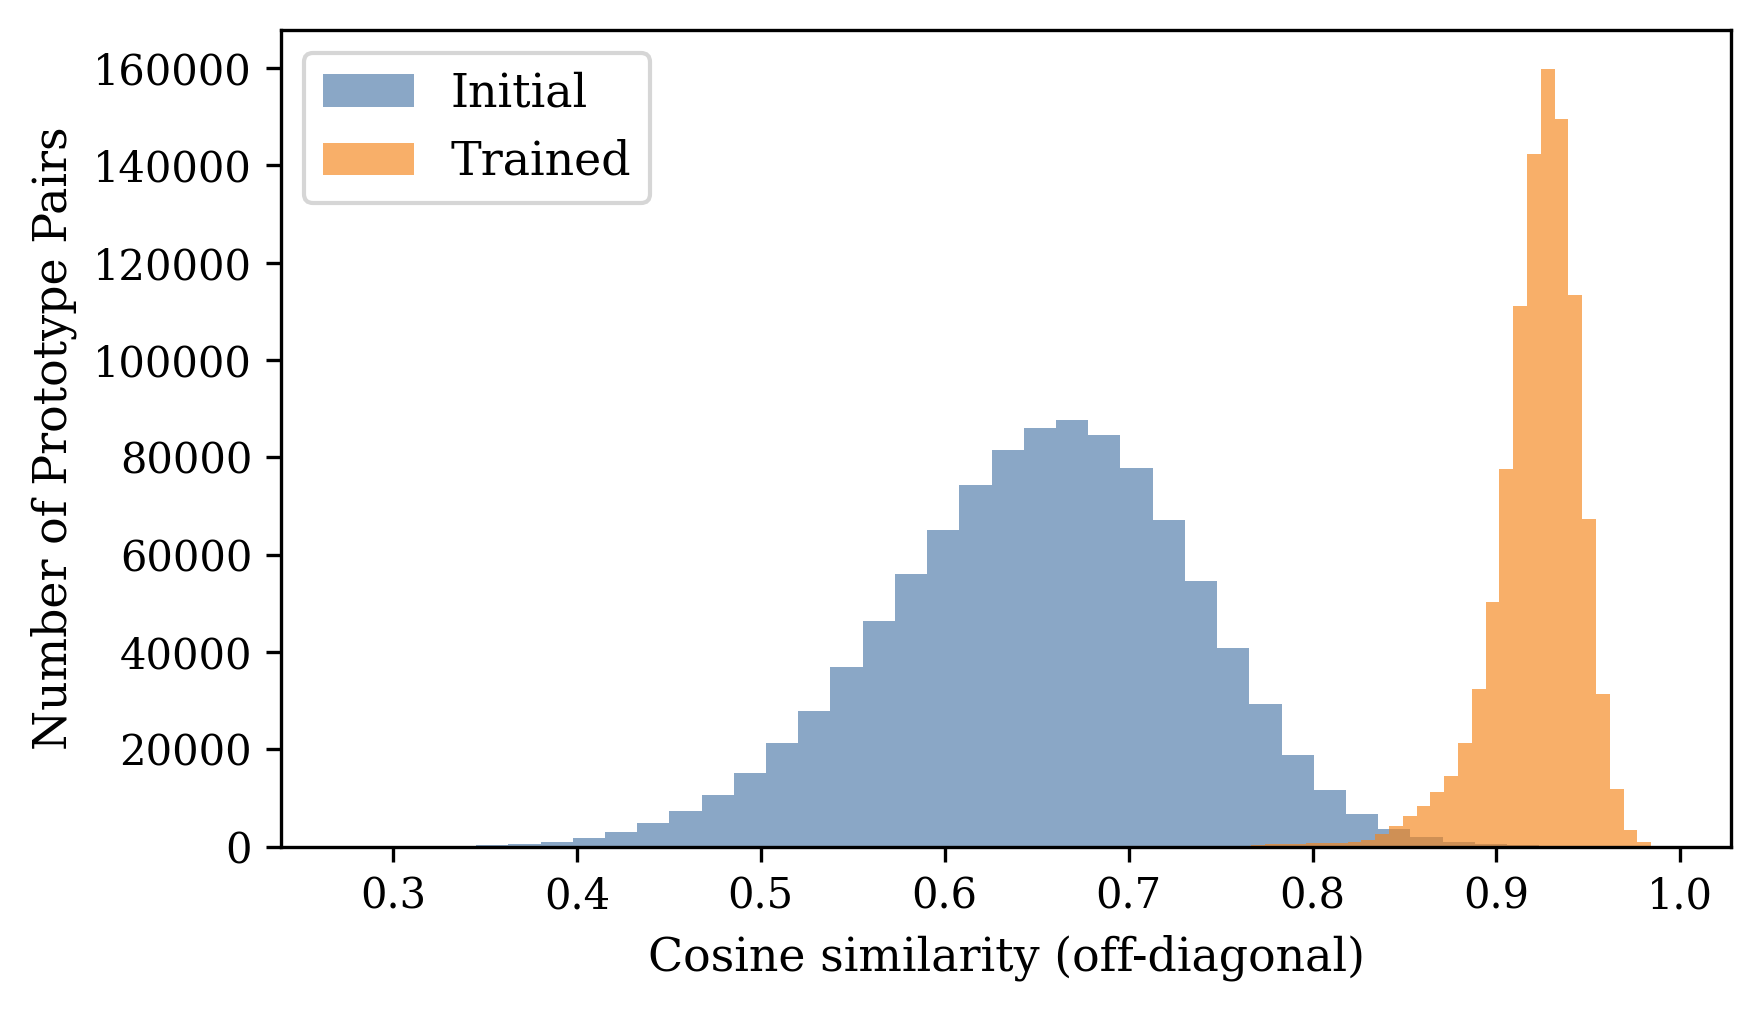

Cosine nearest-neighbour margin (↑ larger gaps)
Initial: mean=0.1299, median=0.1210
Trained: mean=0.0299, median=0.0268


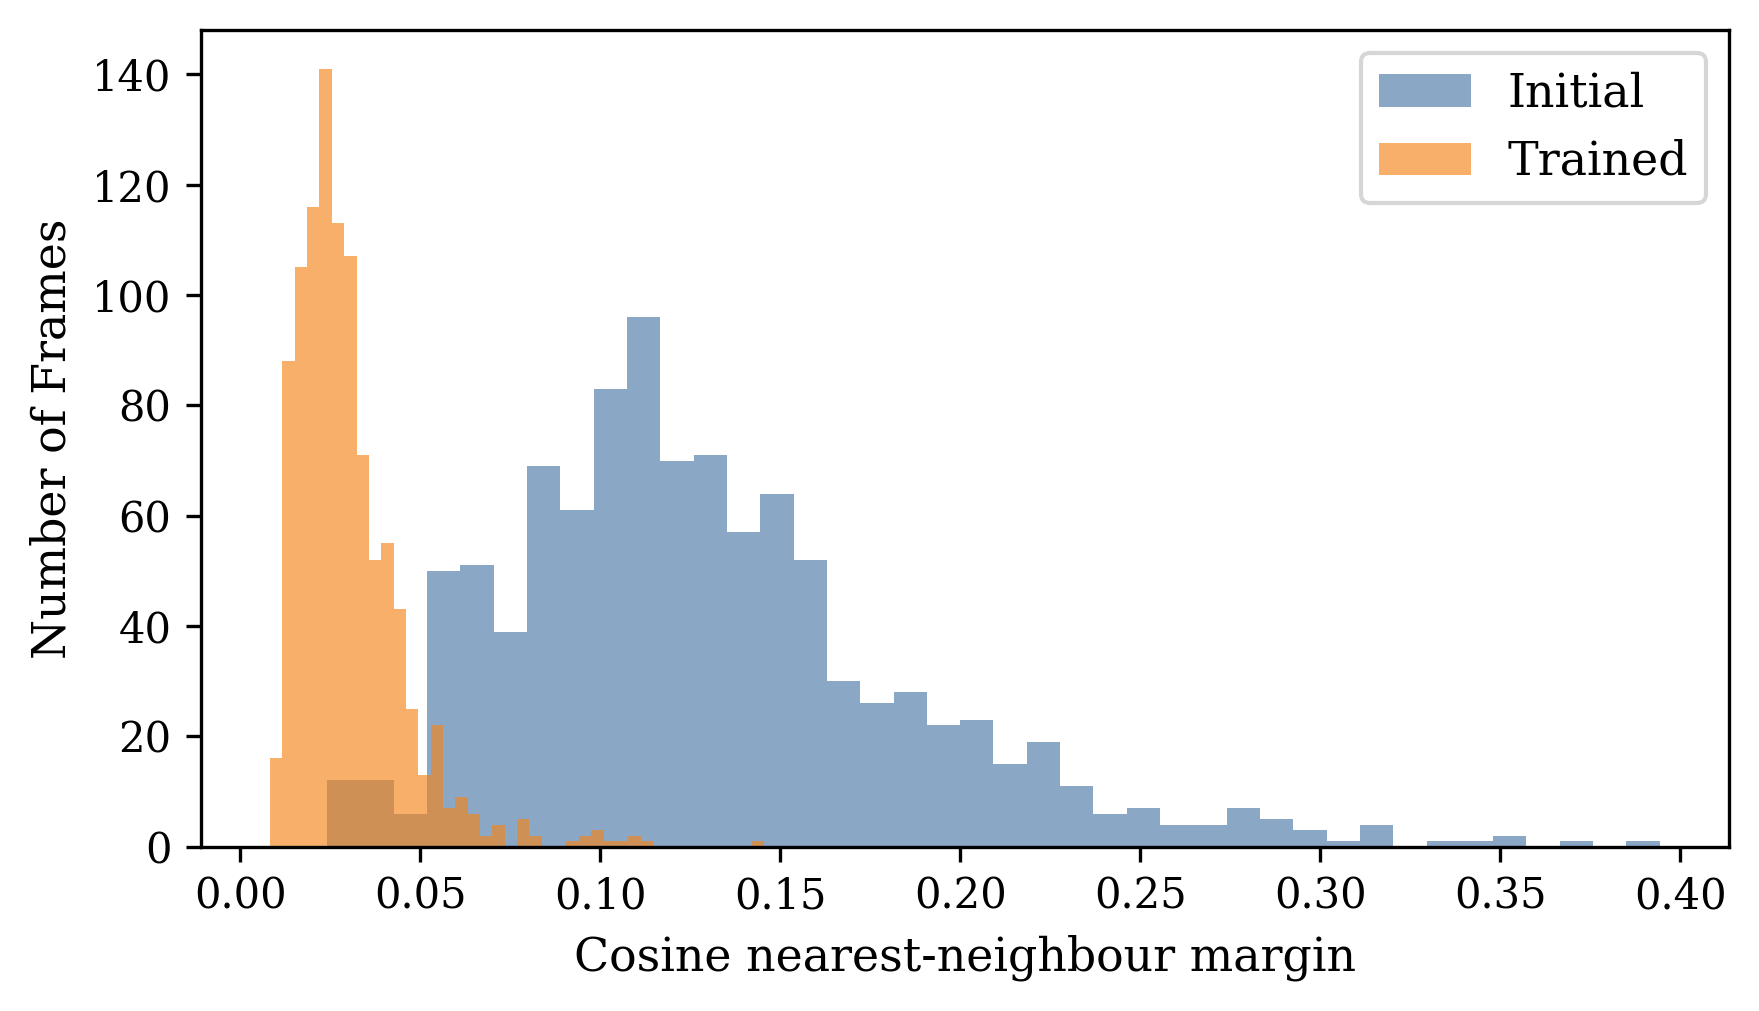

In [15]:
# -*- coding: utf-8 -*-
# Visualization: prototype geometry before vs after training (cosine-based)
# Figure 11: Inter-class cosine similarity (↓ better separation)
# Figure 12: Cosine nearest-neighbour margin (↑ larger margin)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# ======= CONFIG =======
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300
})

COL_INIT   = "#4C78A8"
COL_TRAIN  = "#F58518"
ALPHA      = 0.65
BINS       = 40

# ======= Utils =======
def offdiag_cosine_values(X: np.ndarray):
    """Off-diagonal cosine similarity stats."""
    S = cosine_similarity(X)
    mask = ~np.eye(len(X), dtype=bool)
    vals = S[mask]
    stats = {
        "mean":   float(np.mean(vals)),
        "median": float(np.median(vals)),
        "p90":    float(np.quantile(vals, 0.90)),
        "max":    float(np.max(vals)),
    }
    return stats, vals

def nn_gap_cosine(X: np.ndarray):
    """Cosine NN margin = 1 − max_{j ≠ i} cos(x_i, x_j)."""
    S = cosine_similarity(X)
    np.fill_diagonal(S, -np.inf)
    nn_sim = np.max(S, axis=1)
    return 1.0 - nn_sim  # margin

# ======= Inputs =======
# init_mat = ...
# trn_mat  = ...

# 1) Off-diagonal cosine similarity (Figure 11)
init_stat, init_vals = offdiag_cosine_values(init_mat)
trn_stat,  trn_vals  = offdiag_cosine_values(trn_mat)

print("Off-diagonal cosine similarity (↓ better separation)")
print("Initial:", init_stat)
print("Trained:", trn_stat)

plt.figure(figsize=(6, 3.5))
plt.hist(init_vals, bins=BINS, alpha=ALPHA, color=COL_INIT, label="Initial")
plt.hist(trn_vals,  bins=BINS, alpha=ALPHA, color=COL_TRAIN, label="Trained")
plt.xlabel("Cosine similarity (off-diagonal)")
plt.ylabel("Number of Prototype Pairs")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()  # Figure 11

# 2) Cosine nearest-neighbour margin (Figure 12)
init_nn = nn_gap_cosine(init_mat)
trn_nn  = nn_gap_cosine(trn_mat)

print("Cosine nearest-neighbour margin (↑ larger gaps)")
print(f"Initial: mean={init_nn.mean():.4f}, median={np.median(init_nn):.4f}")
print(f"Trained: mean={trn_nn.mean():.4f}, median={np.median(trn_nn):.4f}")

plt.figure(figsize=(6, 3.5))
plt.hist(init_nn, bins=BINS, alpha=ALPHA, color=COL_INIT,  label="Initial")
plt.hist(trn_nn,  bins=BINS, alpha=ALPHA, color=COL_TRAIN, label="Trained")
plt.xlabel("Cosine nearest-neighbour margin")
plt.ylabel("Number of Frames")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()  # Figure 12



In [6]:
# @title ✅ 主训练模型



class OptimizedPrototypeLossWithSeparation(nn.Module):
    def __init__(self, initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.sep_weight = sep_weight
        self.adaptive_temp = adaptive_temp

    def update_temperature(self, epoch, max_epochs):
        """保持原来的温度调整策略，不设人为下限"""
        if self.adaptive_temp:
            # 保持原来的cos衰减公式
            decay_factor = 0.6 + 0.4 * np.cos(np.pi * epoch / max_epochs)
            self.current_temperature = self.initial_temperature * decay_factor

    def forward(self, embeddings, labels, prototypes, epoch=0, max_epochs=8):
        device = embeddings.device

        # 更新温度
        self.update_temperature(epoch, max_epochs)

        frame_names = list(prototypes.keys())
        proto_list = [prototypes[f] for f in frame_names]
        prototype_matrix = torch.stack(proto_list).to(device)

        frame_to_idx = {f: i for i, f in enumerate(frame_names)}
        target_indices = torch.tensor([frame_to_idx[label] for label in labels], device=device)

        sim_matrix = torch.matmul(embeddings, prototype_matrix.T) / self.current_temperature
        loss_ce = F.cross_entropy(sim_matrix, target_indices)

        # 改进的分离损失：更温和的惩罚
        if len(proto_list) > 1:
            proto_norm = F.normalize(prototype_matrix, dim=-1)
            sim_proto = torch.matmul(proto_norm, proto_norm.T)
            # 去除对角线，only惩罚相似度>0.4的原型对
            mask = ~torch.eye(len(proto_norm), dtype=bool, device=device)
            off_diagonal_sims = sim_proto[mask]
            sep_loss = torch.relu(off_diagonal_sims - 0.4).mean()
        else:
            sep_loss = torch.tensor(0.0, device=device)

        total_loss = loss_ce + self.sep_weight * sep_loss
        return total_loss, {
            'cross_entropy': loss_ce.item(),
            'separation': sep_loss.item(),
            'total': total_loss.item(),
            'temperature': self.current_temperature
        }

class SimpleFrameDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'sentence': row['sentence'],
            'target_spans': row['target_spans'],
            'frame_name': row['frame_name']
        }

def collate_fn(batch):
    return {
        'sentence': [x['sentence'] for x in batch],
        'target_spans': [x['target_spans'] for x in batch],
        'frame_name': [x['frame_name'] for x in batch]
    }

def stratified_evaluation(model, tokenizer, val_df, prototypes, train_counts):
    print("\n分层评估:")
    groups = [
        ('Rich', 50, float('inf')),
        ('Medium', 20, 49),
        ('Poor', 10, 19),
        ('Very Poor', 0, 9)
    ]
    for name, min_c, max_c in groups:
        frames = train_counts[(train_counts >= min_c) & (train_counts <= max_c)].index
        sub_df = val_df[val_df['frame_name'].isin(frames)]
        if len(sub_df) == 0:
            continue
        result = evaluate_target_known(model, tokenizer, sub_df, prototypes, batch_size=64)
        print(f"   {name:<12} ({len(sub_df)} samples) Top-1: {result['top1_accuracy']:.3f} | Macro F1: {result['macro_f1']:.3f}")

class PostClusteringAnalyzer:
    """训练后聚类分析器"""

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def extract_all_embeddings(self, df, batch_size=64):
        """提取所有样本的embeddings"""
        print("\n提取训练样本embeddings用于后聚类分析...")

        frame_embeddings = defaultdict(list)
        self.model.eval()

        with torch.no_grad():
            for i in tqdm(range(0, len(df), batch_size), desc="提取embeddings"):
                batch = df.iloc[i:i+batch_size]

                try:
                    # 使用现有的encode函数
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        self.tokenizer, self.model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        frame_embeddings[frame_name].append(embs[j].cpu())

                except Exception as e:
                    print(f"批次处理错误: {e}")
                    continue

        # 转换为tensor
        processed_embeddings = {}
        for frame, emb_list in frame_embeddings.items():
            if emb_list:
                processed_embeddings[frame] = torch.stack(emb_list)

        print(f"提取完成: {len(processed_embeddings)} frames")
        return processed_embeddings

    def analyze_clustering_potential(self, frame_embeddings, min_samples=10):
        """分析每个frame的聚类潜力"""
        print("\n分析各frame聚类潜力...")

        clustering_analysis = {}

        for frame_name, embeddings in frame_embeddings.items():
            if len(embeddings) < min_samples:
                clustering_analysis[frame_name] = {
                    'optimal_clusters': 1,
                    'reason': f'样本太少({len(embeddings)})',
                    'internal_similarity': 0.0,
                    'dbi_score': 0.0
                }
                continue

            # 计算内部相似度
            center = embeddings.mean(0)
            similarities = F.cosine_similarity(embeddings, center.unsqueeze(0))
            avg_similarity = similarities.mean().item()

            # 尝试不同的聚类数量
            best_k = 1
            best_dbi = float('inf')

            max_k = min(5, len(embeddings) // 10)  # 最多5个簇

            if max_k > 1:
                for k in range(2, max_k + 1):
                    try:
                        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
                        labels = kmeans.fit_predict(embeddings.numpy())

                        # 计算DBI
                        dbi = davies_bouldin_score(embeddings.numpy(), labels)

                        if dbi < best_dbi:
                            best_dbi = dbi
                            best_k = k

                    except Exception:
                        continue

            # 决策逻辑：内部相似度低且DBI合理时才聚类
            if avg_similarity < 0.7 and best_k > 1 and best_dbi < 2.0:
                optimal_k = best_k
                reason = f'内聚度低({avg_similarity:.3f}), DBI={best_dbi:.3f}'
            else:
                optimal_k = 1
                reason = f'内聚度高({avg_similarity:.3f})'

            clustering_analysis[frame_name] = {
                'optimal_clusters': optimal_k,
                'reason': reason,
                'internal_similarity': avg_similarity,
                'dbi_score': best_dbi,
                'sample_count': len(embeddings)
            }

        return clustering_analysis

    def create_clustered_prototypes(self, frame_embeddings, clustering_analysis):
        """基于聚类分析创建新原型"""
        print("\n基于聚类分析创建多原型...")

        new_prototypes = {}
        multi_prototype_count = 0

        for frame_name, embeddings in frame_embeddings.items():
            analysis = clustering_analysis[frame_name]
            optimal_k = analysis['optimal_clusters']

            if optimal_k == 1:
                # 单原型：使用中心化的平均
                new_prototypes[frame_name] = self._create_robust_prototype(embeddings)
            else:
                # 多原型：聚类后每个簇一个原型
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(embeddings.numpy())

                sub_prototypes = []
                for cluster_id in range(optimal_k):
                    cluster_mask = labels == cluster_id
                    if cluster_mask.sum() > 0:
                        cluster_embeddings = embeddings[cluster_mask]
                        prototype = self._create_robust_prototype(cluster_embeddings)
                        sub_prototypes.append(prototype)

                if sub_prototypes:
                    new_prototypes[frame_name] = sub_prototypes
                    multi_prototype_count += 1
                    print(f"   {frame_name}: {len(sub_prototypes)}个子原型 "
                          f"({analysis['sample_count']}样本, {analysis['reason']})")
                else:
                    # 聚类失败，回退到单原型
                    new_prototypes[frame_name] = self._create_robust_prototype(embeddings)

        print(f"多原型创建完成: {multi_prototype_count} frames使用多原型")
        return new_prototypes

    def _create_robust_prototype(self, embeddings):
        """创建鲁棒的原型（异常值过滤）"""
        if len(embeddings) <= 3:
            return embeddings.mean(0)

        # 异常值过滤：移除距离中心最远的20%
        center = embeddings.mean(0)
        distances = torch.norm(embeddings - center, dim=1)
        keep_ratio = 0.8
        keep_num = max(1, int(len(embeddings) * keep_ratio))

        _, keep_indices = torch.topk(distances, keep_num, largest=False)
        filtered_embeddings = embeddings[keep_indices]

        return filtered_embeddings.mean(0)

class OptimizedPrototypeLearner:
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints"):
        self.device = device
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # 使用优化的损失函数 - 保持原来的设计
        self.criterion = OptimizedPrototypeLossWithSeparation(
            initial_temperature=0.1,
            sep_weight=0.15,          # 保持原来的权重
            adaptive_temp=True        # 不设置min_temp限制
        )

        self.prototypes = {}
        self.best_val = 0
        self.save_dir = save_dir
        self.best_model_path = None

        # 创建保存目录
        os.makedirs(save_dir, exist_ok=True)

        # 后聚类分析器
        self.clustering_analyzer = PostClusteringAnalyzer(self.model, self.tokenizer)

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        """保存检查点"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'best_val_acc': self.best_val,
            'val_acc': val_acc,
            'loss': loss,
            'criterion_state': {
                'current_temperature': self.criterion.current_temperature,
                'initial_temperature': self.criterion.initial_temperature,
                'sep_weight': self.criterion.sep_weight
            }
        }

        if is_best:
            # 最佳模型保存
            save_path = f"{self.save_dir}/best_model.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"  最佳模型已保存: {save_path}")
            return save_path
        else:
            # 定期检查点保存
            save_path = f"{self.save_dir}/checkpoint_epoch{epoch}.pt"
            torch.save(checkpoint, save_path)
            print(f"  检查点已保存: {save_path}")
            return save_path

    def load_checkpoint(self, checkpoint_path):
        """加载检查点"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.prototypes = checkpoint['prototypes']
        self.best_val = checkpoint['best_val_acc']

        # 恢复损失函数状态
        if 'criterion_state' in checkpoint:
            criterion_state = checkpoint['criterion_state']
            self.criterion.current_temperature = criterion_state['current_temperature']
            self.criterion.initial_temperature = criterion_state['initial_temperature']
            self.criterion.sep_weight = criterion_state['sep_weight']

        print(f"已加载检查点: {checkpoint_path}")
        print(f"   恢复epoch: {checkpoint['epoch']}, 最佳准确率: {self.best_val:.4f}")
        return checkpoint['epoch']

    def train(self, train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3,
              save_every=2):

        # 初始构建单原型
        self.build_prototypes(train_df)

        # 优化器设置 - 恢复到更积极的参数，因为模型在进步
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01,  # 恢复原来的权重衰减
            eps=1e-6
        )

        # 恢复原来的学习率调度器
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=lr * 0.1
        )

        train_counts = train_df['frame_name'].value_counts()
        train_loader = DataLoader(
            SimpleFrameDataset(train_df, self.tokenizer),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn,
            # 添加确定性参数
            generator=torch.Generator().manual_seed(42),  # 确保shuffle的可重现性
            num_workers=0  # 避免多进程带来的随机性
        )

        patience_counter = 0

        print(f"\n" + "="*60)
        print(f"开始训练 - 增强保存机制")
        print(f"="*60)
        print(f"训练样本: {len(train_df):,}")
        print(f"验证样本: {len(val_df):,}")
        print(f"Frame数量: {len(train_counts):,}")
        print(f"保存目录: {self.save_dir}")
        print(f"总轮数: {epochs}, 早停patience: {patience}")

        for ep in range(epochs):
            self.model.train()
            epoch_losses = {'total': [], 'cross_entropy': [], 'separation': []}

            print(f"\n" + "-"*60)
            print(f"Epoch {ep+1:2d}/{epochs}")
            print(f"-"*60)
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(
                    batch['sentence'], batch['target_spans'],
                    self.tokenizer, self.model,
                    batch_size=len(batch['sentence']), train_mode=True
                )

                loss, loss_dict = self.criterion(
                    embs, batch['frame_name'], self.prototypes,
                    epoch=ep, max_epochs=epochs
                )

                # 正常的梯度裁剪
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # 记录每个batch的损失用于计算epoch平均值
                epoch_losses['total'].append(loss_dict['total'])
                epoch_losses['cross_entropy'].append(loss_dict['cross_entropy'])
                epoch_losses['separation'].append(loss_dict['separation'])

                pbar.set_postfix({
                    'Loss': f"{loss_dict['total']:.3f}",
                    'CE': f"{loss_dict['cross_entropy']:.3f}",
                    'Sep': f"{loss_dict['separation']:.3f}",
                    'Temp': f"{loss_dict['temperature']:.3f}"
                })

            scheduler.step()

            # 计算epoch平均损失
            avg_total_loss = np.mean(epoch_losses['total'])
            avg_ce_loss = np.mean(epoch_losses['cross_entropy'])
            avg_sep_loss = np.mean(epoch_losses['separation'])
            current_temp = loss_dict['temperature']  # 温度是固定的，取最后一个即可

            print(f"训练损失 - Total: {avg_total_loss:.4f} | CE: {avg_ce_loss:.4f} | Sep: {avg_sep_loss:.4f} | 温度: {current_temp:.3f}")

            # 定期重建原型
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # 评估
            result = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)
            acc = result['top1_accuracy']
            print(f"验证准确率: {acc:.4f}")

            # 分层评估
            print(f"\n分层评估结果:")
            stratified_evaluation(self.model, self.tokenizer, val_df, self.prototypes, train_counts)

            # 保存逻辑
            is_best = acc > self.best_val

            # 最佳模型保存
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                print(f"保存最佳模型 - 准确率: {acc:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1

            # 定期检查点保存
            if (ep + 1) % save_every == 0:
                self.save_checkpoint(ep+1, acc, avg_total_loss)

            # 早停检查
            if patience_counter >= patience:
                print(f"连续{patience}轮无改善，提前停止")
                break

        # 最终保存
        final_save_path = f"{self.save_dir}/final_model_epoch{ep+1}_acc{acc:.4f}.pt"
        self.save_checkpoint(ep+1, acc, avg_total_loss)

        # 加载最佳模型
        if self.best_model_path and os.path.exists(self.best_model_path):
            print(f"\n" + "="*60)
            print(f"加载最佳模型: {self.best_model_path}")
            print(f"="*60)
            self.load_checkpoint(self.best_model_path)

        return self

    def build_prototypes(self, df):
        """构建原型时增加稳定性"""
        print(f"重建原型中...")
        frame2embeds = defaultdict(list)

        # 使用现有的编码函数
        for i in tqdm(range(0, len(df), 32), desc="Encoding spans"):
            batch = df.iloc[i:i+32]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    self.tokenizer, self.model,
                    batch_size=32, train_mode=False
                )
                for f, e in zip(batch['frame_name'], embs):
                    frame2embeds[f].append(e)
            except Exception as e:
                print(f"  批次处理失败: {e}")
                continue

        self.prototypes = {}
        for f, vecs in tqdm(frame2embeds.items(), desc="Computing prototypes"):
            if not vecs:
                continue

            X = torch.stack([v.cpu() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in vecs])

            # 更鲁棒的原型构建
            if len(X) > 10:  # 样本多时进行异常值过滤
                center = X.mean(0)
                distances = torch.norm(X - center, dim=1)
                keep_ratio = 0.85  # 保留85%的数据
                keep_num = max(3, int(len(X) * keep_ratio))
                _, keep_indices = torch.topk(distances, keep_num, largest=False)
                X = X[keep_indices]

            self.prototypes[f] = X.mean(0)

        print(f"原型构建完成: {len(self.prototypes)} frames")

    def post_training_clustering(self, train_df):
        """训练后聚类分析"""
        print(f"\n" + "="*50)
        print("第二阶段：训练后聚类分析")
        print(f"="*50)

        # 提取所有embeddings
        frame_embeddings = self.clustering_analyzer.extract_all_embeddings(train_df)

        # 分析聚类潜力
        clustering_analysis = self.clustering_analyzer.analyze_clustering_potential(frame_embeddings)

        # 创建多原型
        clustered_prototypes = self.clustering_analyzer.create_clustered_prototypes(
            frame_embeddings, clustering_analysis
        )

        return clustered_prototypes, clustering_analysis

# 第一阶段：单原型训练
def run_first_stage_training():
    # 在函数开始时再次设置随机种子，确保生效
    def set_seed(seed=42):
        import os
        import random
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    set_seed(42)  # 确保在训练开始前再次设置

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")
    print(f"随机种子已设置: 42")

    # 加载数据
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\n数据加载完成:")
    print(f"训练样本: {len(train_df):,}")
    print(f"验证样本: {len(val_df):,}")
    print(f"Frame数量: {len(train_df['frame_name'].unique()):,}")

    # 创建学习器
    learner = OptimizedPrototypeLearner(device)

    # 检查是否有之前的检查点
    checkpoint_dir = learner.save_dir
    if os.path.exists(f"{checkpoint_dir}/best_model.pt"):
        print(f"\n发现已有最佳模型")

    try:
        # 第一阶段：单原型训练
        print(f"\n" + "="*60)
        print(f"="*60)
        learner.train(
            train_df, val_df,
            epochs=25,
            lr=1e-5,
            rebuild_every=2,
            patience=3,
            save_every=2
        )

    except KeyboardInterrupt:
        print(f"\n训练被中断，但已保存的模型文件不会丢失")
        if learner.best_model_path:
            print(f"最佳模型路径: {learner.best_model_path}")
        return learner

    except Exception as e:
        print(f"\n训练出错: {e}")
        if learner.best_model_path:
            print(f"最佳模型已保存至: {learner.best_model_path}")
        return learner

    # 第一阶段结果评估
    baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    baseline_acc = baseline_result['top1_accuracy']
    print(f"\n" + "="*60)
    print(f"第一阶段结果 - 单原型Top-1准确率: {baseline_acc:.4f}")
    print(f"="*60)

    # 保存第一阶段结果
    first_stage_save_path = f"{learner.save_dir}/first_stage_complete.pt"
    torch.save({
        'model_state_dict': learner.model.state_dict(),
        'prototypes': learner.prototypes,
        'baseline_accuracy': baseline_acc,
        'training_config': {
            'epochs': 25,
            'lr': 1e-5,
            'temperature': learner.criterion.initial_temperature,
            'sep_weight': learner.criterion.sep_weight
        }
    }, first_stage_save_path)

    print(f"第一阶段完整模型已保存至: {first_stage_save_path}")
    return learner

# 第二阶段：后聚类分析
def run_second_stage_clustering(learner=None, first_stage_model_path=None):
    """
    运行第二阶段聚类分析
    Args:
        learner: 第一阶段训练完成的learner对象
        first_stage_model_path: 如果learner为None，从此路径加载第一阶段模型
    """

    # 如果没有传入learner，则从文件加载
    if learner is None:
        if first_stage_model_path is None:
            first_stage_model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/first_stage_complete.pt"

        print(f"从文件加载第一阶段模型: {first_stage_model_path}")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        learner = OptimizedPrototypeLearner(device)

        # 加载第一阶段模型
        checkpoint = torch.load(first_stage_model_path, map_location=device)
        learner.model.load_state_dict(checkpoint['model_state_dict'])
        learner.prototypes = checkpoint['prototypes']
        baseline_acc = checkpoint['baseline_accuracy']
        print(f"第一阶段准确率: {baseline_acc:.4f}")
    else:
        # 从第一阶段获取基准准确率
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
        baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        baseline_acc = baseline_result['top1_accuracy']

    # 加载训练数据用于聚类分析
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    try:
        print(f"\n" + "="*60)
        print(f"第二阶段：训练后聚类分析")
        print(f"="*60)
        clustered_prototypes, clustering_analysis = learner.post_training_clustering(train_df)

        # 更新原型并评估
        original_prototypes = learner.prototypes.copy()  # 保存原始单原型
        learner.prototypes = clustered_prototypes

        # 第二阶段结果评估
        final_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        final_acc = final_result['top1_accuracy']

        print(f"\n" + "="*60)
        print(f"最终结果对比:")
        print(f"单原型阶段: {baseline_acc:.4f}")
        print(f"多原型阶段: {final_acc:.4f}")
        print(f"提升幅度: {final_acc - baseline_acc:+.4f}")
        print(f"="*60)

        # 聚类分析报告
        multi_prototype_frames = sum(1 for analysis in clustering_analysis.values()
                                   if analysis['optimal_clusters'] > 1)
        print(f"\n聚类分析报告:")
        print(f"多原型frames: {multi_prototype_frames}/{len(clustering_analysis)}")

        # 保存最终完整模型
        final_save_path = f"{learner.save_dir}/complete_model_final.pt"
        torch.save({
            'model_state_dict': learner.model.state_dict(),
            'single_prototypes': original_prototypes,  # 保存原始单原型
            'clustered_prototypes': clustered_prototypes,
            'clustering_analysis': clustering_analysis,
            'baseline_accuracy': baseline_acc,
            'final_accuracy': final_acc,
            'training_config': {
                'epochs': 25,
                'lr': 1e-5,
                'temperature': learner.criterion.initial_temperature,
                'sep_weight': learner.criterion.sep_weight
            }
        }, final_save_path)

        print(f"完整模型已保存至: {final_save_path}")
        return learner, clustering_analysis

    except Exception as e:
        print(f"后聚类分析失败: {e}")
        return learner, None

# 完整流程（如果你想一次运行完）
def run_complete_training():
    """运行完整的两阶段训练"""
    print("开始完整的两阶段训练流程")

    # 第一阶段
    learner = run_first_stage_training()

    # 第二阶段
    learner, analysis = run_second_stage_clustering(learner)

    return learner, analysis

In [ ]:
# @title ✅ 运行主训练函数

learner, analysis = run_complete_training()

开始完整的两阶段训练流程
使用设备: cuda
随机种子已设置: 42

数据加载完成:
训练样本: 150,168
验证样本: 25,104
Frame数量: 1,014

重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 326.31it/s]


原型构建完成: 1014 frames

开始训练 - 增强保存机制
训练样本: 150,168
验证样本: 25,104
Frame数量: 1,014
保存目录: /content/drive/MyDrive/more50/framenet_data/checkpoints
总轮数: 25, 早停patience: 3

------------------------------------------------------------
Epoch  1/25
------------------------------------------------------------


训练损失 - Total: 1.0742 | CE: 1.0385 | Sep: 0.2383 | 温度: 0.100
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.1838
Top-3准确率: 0.2900
Macro F1: 0.0382
Weighted F1: 0.1308
处理样本: 25104/25104
验证准确率: 0.1838

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.1951
Top-3准确率: 0.3075
Macro F1: 0.0612
Weighted F1: 0.1405
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.195 | Macro F1: 0.061
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.0027
Top-3准确率: 0.0072
Macro F1: 0.0023
Weighted F1: 0.0034
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.003 | Macro F1: 0.002
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.0051
Top-3准确率: 0.0306
Macro F1: 0.0050
Weighted F1: 0.0082
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.005 | Mac

训练损失 - Total: 0.3039 | CE: 0.2681 | Sep: 0.2383 | 温度: 0.100
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 317.37it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8619
Top-3准确率: 0.9608
Macro F1: 0.7633
Weighted F1: 0.8714
处理样本: 25104/25104
验证准确率: 0.8619

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8617
Top-3准确率: 0.9616
Macro F1: 0.5957
Weighted F1: 0.8804
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.862 | Macro F1: 0.596
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8591
Top-3准确率: 0.9449
Macro F1: 0.6615
Weighted F1: 0.8934
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.859 | Macro F1: 0.662
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8827
Top-3准确率: 0.9592
Macro F1: 0.7212
Weighted F1: 0.9158
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.883 | Macro F1: 0.721
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.3030 | CE: 0.2167 | Sep: 0.5752 | 温度: 0.099
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9085
Top-3准确率: 0.9822
Macro F1: 0.8344
Weighted F1: 0.9120
处理样本: 25104/25104
验证准确率: 0.9085

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9119
Top-3准确率: 0.9832
Macro F1: 0.7292
Weighted F1: 0.9205
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.912 | Macro F1: 0.729
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8699
Top-3准确率: 0.9666
Macro F1: 0.6685
Weighted F1: 0.9037
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.870 | Macro F1: 0.669
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8112
Top-3准确率: 0.9745
Macro F1: 0.5803
Weighted F1: 0.8577
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.811 | Mac

训练损失 - Total: 0.1756 | CE: 0.0893 | Sep: 0.5752 | 温度: 0.097
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 325.71it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9173
Top-3准确率: 0.9831
Macro F1: 0.8400
Weighted F1: 0.9207
处理样本: 25104/25104
验证准确率: 0.9173

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9182
Top-3准确率: 0.9837
Macro F1: 0.7005
Weighted F1: 0.9268
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.918 | Macro F1: 0.701
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9070
Top-3准确率: 0.9747
Macro F1: 0.7310
Weighted F1: 0.9300
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.907 | Macro F1: 0.731
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9031
Top-3准确率: 0.9847
Macro F1: 0.7388
Weighted F1: 0.9293
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.903 | Macro F1: 0.739
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.2352 | CE: 0.1751 | Sep: 0.4008 | 温度: 0.095
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5554
Top-3准确率: 0.7607
Macro F1: 0.5425
Weighted F1: 0.6304
处理样本: 25104/25104
验证准确率: 0.5554

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5556
Top-3准确率: 0.7614
Macro F1: 0.4778
Weighted F1: 0.6383
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.556 | Macro F1: 0.478
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5285
Top-3准确率: 0.7326
Macro F1: 0.4670
Weighted F1: 0.6051
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.528 | Macro F1: 0.467
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6327
Top-3准确率: 0.8367
Macro F1: 0.4892
Weighted F1: 0.6858
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.633 | Mac

训练损失 - Total: 0.1353 | CE: 0.0752 | Sep: 0.4008 | 温度: 0.092
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 321.14it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9247
Top-3准确率: 0.9834
Macro F1: 0.8524
Weighted F1: 0.9278
处理样本: 25104/25104
验证准确率: 0.9247

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9265
Top-3准确率: 0.9843
Macro F1: 0.7220
Weighted F1: 0.9344
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.926 | Macro F1: 0.722
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9015
Top-3准确率: 0.9675
Macro F1: 0.7294
Weighted F1: 0.9262
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.902 | Macro F1: 0.729
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9184
Top-3准确率: 0.9796
Macro F1: 0.7624
Weighted F1: 0.9430
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.918 | Macro F1: 0.762
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1227 | CE: 0.0422 | Sep: 0.5370 | 温度: 0.089
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9222
Top-3准确率: 0.9818
Macro F1: 0.8519
Weighted F1: 0.9246
处理样本: 25104/25104
验证准确率: 0.9222

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9247
Top-3准确率: 0.9826
Macro F1: 0.7480
Weighted F1: 0.9313
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.925 | Macro F1: 0.748
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8997
Top-3准确率: 0.9720
Macro F1: 0.7128
Weighted F1: 0.9281
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.900 | Macro F1: 0.713
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8622
Top-3准确率: 0.9796
Macro F1: 0.6844
Weighted F1: 0.8926
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.862 | Mac

训练损失 - Total: 0.1149 | CE: 0.0344 | Sep: 0.5370 | 温度: 0.085
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 315.60it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9273
Top-3准确率: 0.9841
Macro F1: 0.8559
Weighted F1: 0.9303
处理样本: 25104/25104
验证准确率: 0.9273

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9286
Top-3准确率: 0.9849
Macro F1: 0.7279
Weighted F1: 0.9364
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.929 | Macro F1: 0.728
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9178
Top-3准确率: 0.9720
Macro F1: 0.7484
Weighted F1: 0.9390
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.918 | Macro F1: 0.748
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9031
Top-3准确率: 0.9796
Macro F1: 0.7279
Weighted F1: 0.9301
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.903 | Macro F1: 0.728
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1124 | CE: 0.0412 | Sep: 0.4750 | 温度: 0.081
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8340
Top-3准确率: 0.9380
Macro F1: 0.7758
Weighted F1: 0.8565
处理样本: 25104/25104
验证准确率: 0.8340

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8343
Top-3准确率: 0.9382
Macro F1: 0.6619
Weighted F1: 0.8643
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.834 | Macro F1: 0.662
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8311
Top-3准确率: 0.9341
Macro F1: 0.6420
Weighted F1: 0.8704
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.831 | Macro F1: 0.642
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8367
Top-3准确率: 0.9439
Macro F1: 0.6422
Weighted F1: 0.8712
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.837 | Mac

训练损失 - Total: 0.1030 | CE: 0.0318 | Sep: 0.4750 | 温度: 0.077
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 322.50it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9278
Top-3准确率: 0.9833
Macro F1: 0.8577
Weighted F1: 0.9306
处理样本: 25104/25104
验证准确率: 0.9278

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9297
Top-3准确率: 0.9841
Macro F1: 0.7277
Weighted F1: 0.9374
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.728
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9042
Top-3准确率: 0.9702
Macro F1: 0.7326
Weighted F1: 0.9293
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.904 | Macro F1: 0.733
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9184
Top-3准确率: 0.9847
Macro F1: 0.7447
Weighted F1: 0.9413
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.918 | Macro F1: 0.745
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1030 | CE: 0.0229 | Sep: 0.5338 | 温度: 0.072
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9189
Top-3准确率: 0.9797
Macro F1: 0.8487
Weighted F1: 0.9221
处理样本: 25104/25104
验证准确率: 0.9189

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9212
Top-3准确率: 0.9804
Macro F1: 0.7335
Weighted F1: 0.9291
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.921 | Macro F1: 0.734
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8907
Top-3准确率: 0.9693
Macro F1: 0.6948
Weighted F1: 0.9191
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.891 | Macro F1: 0.695
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9082
Top-3准确率: 0.9796
Macro F1: 0.7225
Weighted F1: 0.9322
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.908 | Mac

训练损失 - Total: 0.1015 | CE: 0.0214 | Sep: 0.5338 | 温度: 0.067
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 320.27it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9282
Top-3准确率: 0.9830
Macro F1: 0.8615
Weighted F1: 0.9307
处理样本: 25104/25104
验证准确率: 0.9282

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9301
Top-3准确率: 0.9838
Macro F1: 0.7416
Weighted F1: 0.9370
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.742
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9051
Top-3准确率: 0.9693
Macro F1: 0.7335
Weighted F1: 0.9297
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.905 | Macro F1: 0.733
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9133
Top-3准确率: 0.9847
Macro F1: 0.7430
Weighted F1: 0.9384
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.913 | Macro F1: 0.743
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.1014 | CE: 0.0231 | Sep: 0.5219 | 温度: 0.063
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8996
Top-3准确率: 0.9665
Macro F1: 0.8267
Weighted F1: 0.9068
处理样本: 25104/25104
验证准确率: 0.8996

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9024
Top-3准确率: 0.9676
Macro F1: 0.7201
Weighted F1: 0.9147
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.902 | Macro F1: 0.720
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8618
Top-3准确率: 0.9494
Macro F1: 0.6738
Weighted F1: 0.8943
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.862 | Macro F1: 0.674
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8673
Top-3准确率: 0.9643
Macro F1: 0.6790
Weighted F1: 0.9030
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.867 | Mac

训练损失 - Total: 0.0966 | CE: 0.0183 | Sep: 0.5219 | 温度: 0.057
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:03<00:00, 321.05it/s]


原型构建完成: 1014 frames
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9274
Top-3准确率: 0.9812
Macro F1: 0.8493
Weighted F1: 0.9305
处理样本: 25104/25104
验证准确率: 0.9274

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9297
Top-3准确率: 0.9822
Macro F1: 0.7323
Weighted F1: 0.9374
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.732
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9042
Top-3准确率: 0.9684
Macro F1: 0.7382
Weighted F1: 0.9274
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.904 | Macro F1: 0.738
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8929
Top-3准确率: 0.9694
Macro F1: 0.7173
Weighted F1: 0.9229
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.893 | Macro F1: 0.717
📊 使用已有frame原型
🎯 评估 183 个测试样

训练损失 - Total: 0.0999 | CE: 0.0207 | Sep: 0.5281 | 温度: 0.053
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9106
Top-3准确率: 0.9743
Macro F1: 0.8329
Weighted F1: 0.9182
处理样本: 25104/25104
验证准确率: 0.9106

分层评估结果:

分层评估:
📊 使用已有frame原型
🎯 评估 23618 个测试样本，1014 个frame原型
📝 有效测试样本: 23618/23618

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9128
Top-3准确率: 0.9749
Macro F1: 0.7116
Weighted F1: 0.9257
处理样本: 23618/23618
   Rich         (23618 samples) Top-1: 0.913 | Macro F1: 0.712
📊 使用已有frame原型
🎯 评估 1107 个测试样本，1014 个frame原型
📝 有效测试样本: 1107/1107

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8880
Top-3准确率: 0.9684
Macro F1: 0.7161
Weighted F1: 0.9183
处理样本: 1107/1107
   Medium       (1107 samples) Top-1: 0.888 | Macro F1: 0.716
📊 使用已有frame原型
🎯 评估 196 个测试样本，1014 个frame原型
📝 有效测试样本: 196/196

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.8980
Top-3准确率: 0.9592
Macro F1: 0.7101
Weighted F1: 0.9279
处理样本: 196/196
   Poor         (196 samples) Top-1: 0.898 | Mac

提取embeddings: 100%|██████████| 2347/2347 [05:15<00:00,  7.44it/s]


提取完成: 1014 frames

分析各frame聚类潜力...

基于聚类分析创建多原型...
多原型创建完成: 0 frames使用多原型
📊 使用已有frame原型
🎯 评估 25104 个测试样本，1014 个frame原型
📝 有效测试样本: 25104/25104

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9254
Top-3准确率: 0.9804
Macro F1: 0.8425
Weighted F1: 0.9289
处理样本: 25104/25104

最终结果对比:
单原型阶段: 0.9106
多原型阶段: 0.9254
提升幅度: +0.0149

聚类分析报告:
多原型frames: 0/1014
完整模型已保存至: /content/drive/MyDrive/more50/framenet_data/checkpoints/complete_model_final.pt


In [31]:
# ============================================
#  @title ✅ Prototype Learner (single-stage, no clustering)

# - Save ALL checkpoints each epoch; pick best at the end
# - Paths & hyperparams configurable at the bottom
# ============================================

# -----------------------------
# Loss with prototype separation
# -----------------------------
class OptimizedPrototypeLossWithSeparation(nn.Module):
    def __init__(self, initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.sep_weight = sep_weight
        self.adaptive_temp = adaptive_temp

    def update_temperature(self, epoch, max_epochs):
        """Keep the original cosine decay schedule (no manual lower bound)."""
        if self.adaptive_temp:
            decay_factor = 0.6 + 0.4 * np.cos(np.pi * epoch / max_epochs)
            self.current_temperature = self.initial_temperature * decay_factor

    def forward(self, embeddings, labels, prototypes, epoch=0, max_epochs=8):
        device = embeddings.device

        # Update temperature
        self.update_temperature(epoch, max_epochs)

        frame_names = list(prototypes.keys())
        proto_list = [prototypes[f] for f in frame_names]
        prototype_matrix = torch.stack(proto_list).to(device)

        frame_to_idx = {f: i for i, f in enumerate(frame_names)}
        target_indices = torch.tensor([frame_to_idx[label] for label in labels], device=device)

        sim_matrix = torch.matmul(embeddings, prototype_matrix.T) / self.current_temperature
        loss_ce = F.cross_entropy(sim_matrix, target_indices)

        # Softer separation penalty among prototypes
        if len(proto_list) > 1:
            proto_norm = F.normalize(prototype_matrix, dim=-1)
            sim_proto = torch.matmul(proto_norm, proto_norm.T)
            # Penalise only pairs with similarity > 0.4 (exclude diagonal)
            mask = ~torch.eye(len(proto_norm), dtype=bool, device=device)
            off_diagonal_sims = sim_proto[mask]
            sep_loss = torch.relu(off_diagonal_sims - 0.4).mean()
        else:
            sep_loss = torch.tensor(0.0, device=device)

        total_loss = loss_ce + self.sep_weight * sep_loss
        return total_loss, {
            'cross_entropy': loss_ce.item(),
            'separation': sep_loss.item(),
            'total': total_loss.item(),
            'temperature': self.current_temperature
        }


# -----------------------------
# Minimal dataset & collate
# -----------------------------
class SimpleFrameDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'sentence': row['sentence'],
            'target_spans': row['target_spans'],
            'frame_name': row['frame_name']
        }

def collate_fn(batch):
    return {
        'sentence': [x['sentence'] for x in batch],
        'target_spans': [x['target_spans'] for x in batch],
        'frame_name': [x['frame_name'] for x in batch]
    }


# -----------------------------
# Stratified evaluation helper
# -----------------------------
def stratified_evaluation(model, tokenizer, val_df, prototypes, train_counts):
    print("\nStratified evaluation:")
    groups = [
        ('Rich', 50, float('inf')),
        ('Medium', 20, 49),
        ('Poor', 10, 19),
        ('Very Poor', 0, 9)
    ]
    for name, min_c, max_c in groups:
        frames = train_counts[(train_counts >= min_c) & (train_counts <= max_c)].index
        sub_df = val_df[val_df['frame_name'].isin(frames)]
        if len(sub_df) == 0:
            continue
        result = evaluate_target_known(model, tokenizer, sub_df, prototypes, batch_size=64)
        print(f"   {name:<12} ({len(sub_df)} samples) Top-1: {result['top1_accuracy']:.3f} | Macro F1: {result['macro_f1']:.3f}")


# -----------------------------
# Prototype learner (single-stage)
# -----------------------------
class OptimizedPrototypeLearner:
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints"):
        self.device = device
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Loss (unchanged behaviour)
        self.criterion = OptimizedPrototypeLossWithSeparation(
            initial_temperature=0.1,
            sep_weight=0.15,
            adaptive_temp=True
        )

        self.prototypes = {}
        self.best_val = 0.0
        self.save_dir = save_dir
        self.best_model_path = None

        os.makedirs(save_dir, exist_ok=True)

    # --- Checkpointing: save ALL, pick best at the end ---
    def save_checkpoint(self, epoch, val_acc, loss):
        """
        Always save a checkpoint for this epoch. Filename encodes epoch & val acc.
        """
        ckpt_name = f"checkpoint_epoch{epoch:03d}_acc{val_acc:.4f}.pt"
        ckpt_path = os.path.join(self.save_dir, ckpt_name)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': val_acc,
            'loss': loss,
            'criterion_state': {
                'current_temperature': self.criterion.current_temperature,
                'initial_temperature': self.criterion.initial_temperature,
                'sep_weight': self.criterion.sep_weight
            }
        }
        torch.save(checkpoint, ckpt_path)
        print(f"  Saved checkpoint: {ckpt_path}")
        return ckpt_path

    @staticmethod
    def _parse_acc_from_name(filename):
        m = re.search(r"_acc([0-9]+\.[0-9]+)\.pt$", filename)
        return float(m.group(1)) if m else None

    def find_best_checkpoint(self):
        """
        Scan save_dir and return path to checkpoint with highest val_acc.
        Skip files that can't be parsed or loaded.
        """
        best_path, best_acc = None, -1.0
        for fn in os.listdir(self.save_dir):
            if not fn.endswith(".pt"):
                continue
            acc = self._parse_acc_from_name(fn)
            if acc is None:
                continue
            if acc > best_acc:
                best_acc = acc
                best_path = os.path.join(self.save_dir, fn)
        return best_path, best_acc

    def load_checkpoint(self, checkpoint_path):
        """Load a given checkpoint (skip gracefully on failure)."""
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint.get('prototypes', {})
            self.best_val = float(checkpoint.get('val_acc', 0.0))
            # Restore criterion state (optional)
            crit = checkpoint.get('criterion_state', {})
            if crit:
                self.criterion.current_temperature = crit.get('current_temperature', self.criterion.current_temperature)
                self.criterion.initial_temperature = crit.get('initial_temperature', self.criterion.initial_temperature)
                self.criterion.sep_weight = crit.get('sep_weight', self.criterion.sep_weight)
            print(f"Loaded checkpoint: {checkpoint_path} | epoch={checkpoint.get('epoch', '?')}, val_acc={self.best_val:.4f}")
            return True
        except Exception as e:
            print(f"⚠️  Failed to load checkpoint {checkpoint_path}: {e}")
            return False

    # ----- Training -----
    def train(self, train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3, save_every=1):
        # Initial prototypes
        self.build_prototypes(train_df)

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01,
            eps=1e-6
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=lr * 0.1
        )

        train_counts = train_df['frame_name'].value_counts()
        train_loader = DataLoader(
            SimpleFrameDataset(train_df, self.tokenizer),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn,
            generator=torch.Generator().manual_seed(42),
            num_workers=0
        )

        patience_counter = 0

        print("\n" + "="*60)
        print("Start training (single-stage)")
        print("="*60)
        print(f"Train samples: {len(train_df):,}")
        print(f"Val samples:   {len(val_df):,}")
        print(f"#Frames:       {len(train_counts):,}")
        print(f"Save dir:      {self.save_dir}")
        print(f"Epochs: {epochs}, Early-stop patience: {patience}")

        last_val_acc = 0.0

        for ep in range(epochs):
            self.model.train()
            epoch_losses = {'total': [], 'cross_entropy': [], 'separation': []}

            print("\n" + "-"*60)
            print(f"Epoch {ep+1:2d}/{epochs}")
            print("-"*60)
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(
                    batch['sentence'], batch['target_spans'],
                    self.tokenizer, self.model,
                    batch_size=len(batch['sentence']), train_mode=True
                )

                loss, loss_dict = self.criterion(
                    embs, batch['frame_name'], self.prototypes,
                    epoch=ep, max_epochs=epochs
                )

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                epoch_losses['total'].append(loss_dict['total'])
                epoch_losses['cross_entropy'].append(loss_dict['cross_entropy'])
                epoch_losses['separation'].append(loss_dict['separation'])

                pbar.set_postfix({
                    'Loss': f"{loss_dict['total']:.3f}",
                    'CE': f"{loss_dict['cross_entropy']:.3f}",
                    'Sep': f"{loss_dict['separation']:.3f}",
                    'Temp': f"{loss_dict['temperature']:.3f}"
                })

            scheduler.step()

            avg_total_loss = float(np.mean(epoch_losses['total']))
            avg_ce_loss = float(np.mean(epoch_losses['cross_entropy']))
            avg_sep_loss = float(np.mean(epoch_losses['separation']))
            current_temp = loss_dict['temperature']
            print(f"Train loss - Total: {avg_total_loss:.4f} | CE: {avg_ce_loss:.4f} | Sep: {avg_sep_loss:.4f} | Temp: {current_temp:.3f}")

            # Periodically rebuild prototypes
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # Validation
            result = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)
            acc = float(result['top1_accuracy'])
            print(f"Val Top-1 accuracy: {acc:.4f}")

            # Stratified report (optional)
            print("\nStratified report:")
            stratified_evaluation(self.model, self.tokenizer, val_df, self.prototypes, train_counts)

            # Save checkpoint every epoch (or as configured)
            if (ep + 1) % save_every == 0:
                self.save_checkpoint(ep + 1, acc, avg_total_loss)

            # Early stopping counter
            if acc > self.best_val:
                self.best_val = acc
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"No improvement for {patience} consecutive epochs. Early stopping.")
                break

            last_val_acc = acc

        # Save a final checkpoint at training end
        self.save_checkpoint(ep + 1, last_val_acc, avg_total_loss)

        # Pick best checkpoint at the end and load it (skip on failure)
        print("\n" + "="*60)
        print("Selecting best checkpoint...")
        print("="*60)
        best_path, best_acc = self.find_best_checkpoint()
        if best_path is not None:
            print(f"Best found: {best_path} (val_acc={best_acc:.4f})")
            self.load_checkpoint(best_path)
            self.best_model_path = best_path
        else:
            print("⚠️  No valid checkpoint found.")

        return self

    def build_prototypes(self, df):
        """Rebuild single prototype per frame with basic outlier trimming."""
        print("Rebuilding prototypes...")
        frame2embeds = defaultdict(list)

        for i in tqdm(range(0, len(df), 32), desc="Encoding spans"):
            batch = df.iloc[i:i+32]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    self.tokenizer, self.model,
                    batch_size=32, train_mode=False
                )
                for f, e in zip(batch['frame_name'], embs):
                    frame2embeds[f].append(e)
            except Exception as e:
                print(f"  Batch failed: {e}")
                continue

        self.prototypes = {}
        for f, vecs in tqdm(frame2embeds.items(), desc="Computing prototypes"):
            if not vecs:
                continue
            X = torch.stack([v.cpu() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in vecs])

            # Robust mean: keep closest 85% if enough samples
            if len(X) > 10:
                center = X.mean(0)
                distances = torch.norm(X - center, dim=1)
                keep_ratio = 0.85
                keep_num = max(3, int(len(X) * keep_ratio))
                _, keep_indices = torch.topk(distances, keep_num, largest=False)
                X = X[keep_indices]

            self.prototypes[f] = X.mean(0)

        print(f"Prototypes built: {len(self.prototypes)} frames")


# ============================================
# 🔧 Config & Run (edit paths here)
# ============================================
# Paths
# ===== Paths =====
FULL_PATH = "/content/drive/MyDrive/Open_sesame/framenet_data/framenet_data.pkl"  # fulltext full dataset path
TRAIN_PATH = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
VAL_PATH   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
TEST_PATH  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

SAVE_DIR   = "/content/drive/MyDrive/Open_sesame/framenet_data/checkpoints"
MODEL_NAME = "distilbert-base-uncased"

# Model & training
MODEL_NAME     = "distilbert-base-uncased"
EPOCHS         = 20
LR             = 1e-5
REBUILD_EVERY  = 1
PATIENCE       = 4
SAVE_EVERY     = 1

# Seed utils (optional but recommended)
def set_seed(seed=42):
    import random, os
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load data
train_df = pd.read_pickle(TRAIN_PATH)
val_df   = pd.read_pickle(VAL_PATH)
print(f"Loaded train_df: {train_df.shape}, val_df: {val_df.shape}")

# Train
learner = OptimizedPrototypeLearner(device, model_name=MODEL_NAME, save_dir=SAVE_DIR)
learner = learner.train(
    train_df, val_df,
    epochs=EPOCHS,
    lr=LR,
    rebuild_every=REBUILD_EVERY,
    patience=PATIENCE,
    save_every=SAVE_EVERY
)



# ===== Final evaluation on validation set =====
try:
    final_val_result = evaluate_target_known(
        learner.model, learner.tokenizer, val_df, learner.prototypes
    )
    print("\nFinal evaluation on Validation set:")
    print(json.dumps({
        "top1_accuracy": float(final_val_result["top1_accuracy"]),
        "top3_accuracy": float(final_val_result["top3_accuracy"]),
        "macro_f1": float(final_val_result["macro_f1"]),
        "weighted_f1": float(final_val_result["weighted_f1"])
    }, indent=2))
except Exception as e:
    print(f"⚠️ Validation evaluation skipped due to error: {e}")

# ===== Final evaluation on test set =====
try:
    final_test_result = evaluate_target_known(
        learner.model, learner.tokenizer, test_df, learner.prototypes
    )
    print("\nFinal evaluation on Test set:")
    print(json.dumps({
        "top1_accuracy": float(final_test_result["top1_accuracy"]),
        "top3_accuracy": float(final_test_result["top3_accuracy"]),
        "macro_f1": float(final_test_result["macro_f1"]),
        "weighted_f1": float(final_test_result["weighted_f1"])
    }, indent=2))
except Exception as e:
    print(f"⚠️ Test set evaluation skipped due to error: {e}")



Device: cuda
Loaded train_df: (20105, 6), val_df: (2382, 6)
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1693.31it/s]


Prototypes built: 753 frames

Start training (single-stage)
Train samples: 20,105
Val samples:   2,382
#Frames:       753
Save dir:      /content/drive/MyDrive/Open_sesame/framenet_data/checkpoints
Epochs: 20, Early-stop patience: 4

------------------------------------------------------------
Epoch  1/20
------------------------------------------------------------


Train loss - Total: 3.2862 | CE: 3.2571 | Sep: 0.1937 | Temp: 0.100
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1679.03it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.7800
Top-3 accuracy: 0.9051
Macro F1: 0.6246
Weighted F1: 0.7881
Processed samples: 2382/2382
Val Top-1 accuracy: 0.7800

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.7987
Top-3 accuracy: 0.9375
Macro F1: 0.4545
Weighted F1: 0.8431
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.799 | Macro F1: 0.454
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8111
Top-3 accuracy: 0.8827
Macro F1: 0.5759
Weighted F1: 0.8463
Processed sa

Train loss - Total: 0.8469 | CE: 0.7583 | Sep: 0.5908 | Temp: 0.100
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1692.84it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8333
Top-3 accuracy: 0.9282
Macro F1: 0.6482
Weighted F1: 0.8388
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8333

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8625
Top-3 accuracy: 0.9492
Macro F1: 0.4949
Weighted F1: 0.8920
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.863 | Macro F1: 0.495
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8191
Top-3 accuracy: 0.9125
Macro F1: 0.6155
Weighted F1: 0.8567
Processed sa

Train loss - Total: 0.8591 | CE: 0.7937 | Sep: 0.4361 | Temp: 0.098
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1666.93it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8325
Top-3 accuracy: 0.9299
Macro F1: 0.6639
Weighted F1: 0.8325
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8325

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8697
Top-3 accuracy: 0.9603
Macro F1: 0.5716
Weighted F1: 0.8948
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.870 | Macro F1: 0.572
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8429
Top-3 accuracy: 0.9185
Macro F1: 0.6371
Weighted F1: 0.8747
Processed sa

Train loss - Total: 0.3948 | CE: 0.3072 | Sep: 0.5845 | Temp: 0.096
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1710.62it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8451
Top-3 accuracy: 0.9387
Macro F1: 0.6635
Weighted F1: 0.8487
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8451

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8736
Top-3 accuracy: 0.9590
Macro F1: 0.5230
Weighted F1: 0.8986
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.874 | Macro F1: 0.523
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8608
Top-3 accuracy: 0.9404
Macro F1: 0.6490
Weighted F1: 0.8933
Processed sa

Train loss - Total: 0.3788 | CE: 0.3134 | Sep: 0.4363 | Temp: 0.092
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1675.99it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8405
Top-3 accuracy: 0.9353
Macro F1: 0.6544
Weighted F1: 0.8414
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8405

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8730
Top-3 accuracy: 0.9635
Macro F1: 0.5464
Weighted F1: 0.8999
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.873 | Macro F1: 0.546
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8688
Top-3 accuracy: 0.9423
Macro F1: 0.6596
Weighted F1: 0.8958
Processed sa

Train loss - Total: 0.2025 | CE: 0.1197 | Sep: 0.5518 | Temp: 0.088
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1695.82it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8493
Top-3 accuracy: 0.9400
Macro F1: 0.6676
Weighted F1: 0.8499
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8493

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8814
Top-3 accuracy: 0.9622
Macro F1: 0.5696
Weighted F1: 0.9043
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.881 | Macro F1: 0.570
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9463
Macro F1: 0.6596
Weighted F1: 0.8896
Processed sa

Train loss - Total: 0.1806 | CE: 0.1055 | Sep: 0.5008 | Temp: 0.084
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1650.24it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8413
Top-3 accuracy: 0.9379
Macro F1: 0.6506
Weighted F1: 0.8412
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8413

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8769
Top-3 accuracy: 0.9616
Macro F1: 0.5534
Weighted F1: 0.9004
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.877 | Macro F1: 0.553
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8668
Top-3 accuracy: 0.9483
Macro F1: 0.6557
Weighted F1: 0.8948
Processed sa

Train loss - Total: 0.1548 | CE: 0.0783 | Sep: 0.5097 | Temp: 0.078
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1657.90it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8463
Top-3 accuracy: 0.9353
Macro F1: 0.6564
Weighted F1: 0.8476
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8463

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8821
Top-3 accuracy: 0.9596
Macro F1: 0.5685
Weighted F1: 0.9067
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.882 | Macro F1: 0.569
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9423
Macro F1: 0.6637
Weighted F1: 0.8933
Processed sa

Train loss - Total: 0.1480 | CE: 0.0683 | Sep: 0.5315 | Temp: 0.072
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1679.18it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8497
Top-3 accuracy: 0.9383
Macro F1: 0.6638
Weighted F1: 0.8520
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8497

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8866
Top-3 accuracy: 0.9629
Macro F1: 0.5859
Weighted F1: 0.9108
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.887 | Macro F1: 0.586
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9423
Macro F1: 0.6573
Weighted F1: 0.8949
Processed sa

Train loss - Total: 0.1508 | CE: 0.0727 | Sep: 0.5213 | Temp: 0.066
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1619.03it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8472
Top-3 accuracy: 0.9374
Macro F1: 0.6633
Weighted F1: 0.8483
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8472

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8814
Top-3 accuracy: 0.9609
Macro F1: 0.5654
Weighted F1: 0.9058
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.881 | Macro F1: 0.565
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8688
Top-3 accuracy: 0.9423
Macro F1: 0.6669
Weighted F1: 0.8976
Processed sa

Train loss - Total: 0.1419 | CE: 0.0618 | Sep: 0.5337 | Temp: 0.060
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1630.56it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8497
Top-3 accuracy: 0.9358
Macro F1: 0.6660
Weighted F1: 0.8496
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8497

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8866
Top-3 accuracy: 0.9622
Macro F1: 0.5741
Weighted F1: 0.9094
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.887 | Macro F1: 0.574
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9423
Macro F1: 0.6424
Weighted F1: 0.8953
Processed sa

Train loss - Total: 0.1351 | CE: 0.0534 | Sep: 0.5445 | Temp: 0.054
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1653.48it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8476
Top-3 accuracy: 0.9362
Macro F1: 0.6650
Weighted F1: 0.8489
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8476

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8821
Top-3 accuracy: 0.9603
Macro F1: 0.5610
Weighted F1: 0.9070
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.882 | Macro F1: 0.561
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8648
Top-3 accuracy: 0.9324
Macro F1: 0.6500
Weighted F1: 0.8977
Processed sa

Train loss - Total: 0.1370 | CE: 0.0579 | Sep: 0.5272 | Temp: 0.048
Rebuilding prototypes...


Computing prototypes: 100%|██████████| 753/753 [00:00<00:00, 1665.36it/s]


Prototypes built: 753 frames
📊 Using existing frame prototypes
🎯 Evaluating 2382 test samples, 753 frame prototypes
📝 Valid test samples: 2382/2382

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8489
Top-3 accuracy: 0.9379
Macro F1: 0.6657
Weighted F1: 0.8501
Processed samples: 2382/2382
Val Top-1 accuracy: 0.8489

Stratified report:

Stratified evaluation:
📊 Using existing frame prototypes
🎯 Evaluating 1535 test samples, 753 frame prototypes
📝 Valid test samples: 1535/1535

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8834
Top-3 accuracy: 0.9635
Macro F1: 0.5788
Weighted F1: 0.9072
Processed samples: 1535/1535
   Rich         (1535 samples) Top-1: 0.883 | Macro F1: 0.579
📊 Using existing frame prototypes
🎯 Evaluating 503 test samples, 753 frame prototypes
📝 Valid test samples: 503/503

✅ Target-known evaluation results (Cosine similarity)
Top-1 accuracy: 0.8688
Top-3 accuracy: 0.9404
Macro F1: 0.6562
Weighted F1: 0.9003
Processed sa

In [ ]:
# @title 🔍 修复最佳模型加载

import torch
import pandas as pd
import os

# 1. 首先检查所有保存的模型文件
checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

print("🔍 检查保存的模型文件:")
for file in os.listdir(checkpoint_dir):
    if file.endswith('.pt'):
        print(f"  - {file}")

# 2. 查看最佳模型文件的保存信息（修复加载问题）
def load_checkpoint_safely(checkpoint_path):
    """安全加载检查点，修复weights_only问题"""
    try:
        # 使用weights_only=False修复问题
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        return checkpoint
    except Exception as e:
        print(f"加载失败: {e}")
        return None

# 3. 检查最佳模型文件
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
print(f"\n🔍 检查最佳模型文件: {best_model_path}")

if os.path.exists(best_model_path):
    checkpoint = load_checkpoint_safely(best_model_path)
    if checkpoint:
        print(f"✅ 最佳模型文件信息:")
        print(f"   保存的epoch: {checkpoint.get('epoch', 'Unknown')}")
        print(f"   保存时准确率: {checkpoint.get('val_acc', 'Unknown')}")
        print(f"   最佳准确率: {checkpoint.get('best_val_acc', 'Unknown')}")
    else:
        print("❌ 最佳模型文件加载失败")
else:
    print("❌ 最佳模型文件不存在")

# 4. 检查所有检查点，找到真正的最佳模型
print(f"\n🔍 搜索所有检查点，找到真正最佳:")
best_acc = 0
best_checkpoint_file = None
best_checkpoint_data = None

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_') and f.endswith('.pt')]
checkpoint_files.sort()  # 按epoch排序

for file in checkpoint_files:
    file_path = os.path.join(checkpoint_dir, file)
    checkpoint = load_checkpoint_safely(file_path)

    if checkpoint and 'val_acc' in checkpoint:
        acc = checkpoint['val_acc']
        epoch = checkpoint.get('epoch', 'Unknown')
        print(f"   {file}: Epoch {epoch}, 准确率 {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_checkpoint_file = file
            best_checkpoint_data = checkpoint

# 5. 显示真正的最佳模型
if best_checkpoint_data:
    print(f"\n🏆 找到真正的最佳模型:")
    print(f"   文件: {best_checkpoint_file}")
    print(f"   Epoch: {best_checkpoint_data.get('epoch', 'Unknown')}")
    print(f"   准确率: {best_acc:.4f}")

    # 6. 替换最佳模型文件
    print(f"\n🔄 替换最佳模型文件...")
    true_best_path = os.path.join(checkpoint_dir, best_checkpoint_file)

    # 备份原来的best_model.pt
    if os.path.exists(best_model_path):
        backup_path = os.path.join(checkpoint_dir, "best_model_backup.pt")
        import shutil
        shutil.copy2(best_model_path, backup_path)
        print(f"   原best_model.pt已备份为: best_model_backup.pt")

    # 复制真正最佳的模型
    import shutil
    shutil.copy2(true_best_path, best_model_path)
    print(f"✅ 已将{best_checkpoint_file}复制为best_model.pt")

    # 7. 验证修复结果
    print(f"\n🔍 验证修复结果:")
    fixed_checkpoint = load_checkpoint_safely(best_model_path)
    if fixed_checkpoint:
        print(f"   新的best_model.pt准确率: {fixed_checkpoint.get('val_acc', 'Unknown'):.4f}")
        print(f"   应该等于: {best_acc:.4f}")
        if abs(fixed_checkpoint.get('val_acc', 0) - best_acc) < 0.0001:
            print("✅ 修复成功！")
        else:
            print("❌ 修复可能有问题")

else:
    print("❌ 没有找到有效的检查点文件")

# 8. 重新加载和评估最佳模型的代码
print(f"\n📝 重新加载最佳模型的代码:")
print("""
# 重新加载修复后的最佳模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learner = OptimizedPrototypeLearner(device)

# 使用修复的加载方法
checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                       map_location=device, weights_only=False)

learner.model.load_state_dict(checkpoint['model_state_dict'])
learner.prototypes = checkpoint['prototypes']
learner.best_val = checkpoint['best_val_acc']

print(f"✅ 已加载最佳模型，准确率: {checkpoint['val_acc']:.4f}")

# 重新评估
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
print(f"🎯 重新评估结果: {result['top1_accuracy']:.4f}")
""")

🔍 检查保存的模型文件:
  - best_model.pt
  - checkpoint_epoch2.pt
  - checkpoint_epoch4.pt
  - checkpoint_epoch6.pt
  - checkpoint_epoch8.pt
  - checkpoint_epoch10.pt
  - checkpoint_epoch12.pt
  - checkpoint_epoch14.pt
  - checkpoint_epoch15.pt
  - complete_model_final.pt

🔍 检查最佳模型文件: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
✅ 最佳模型文件信息:
   保存的epoch: 12
   保存时准确率: 0.928178776290631
   最佳准确率: 0.928178776290631

🔍 搜索所有检查点，找到真正最佳:
   checkpoint_epoch10.pt: Epoch 10, 准确率 0.9278
   checkpoint_epoch12.pt: Epoch 12, 准确率 0.9282
   checkpoint_epoch14.pt: Epoch 14, 准确率 0.9274
   checkpoint_epoch15.pt: Epoch 15, 准确率 0.9106
   checkpoint_epoch2.pt: Epoch 2, 准确率 0.8619
   checkpoint_epoch4.pt: Epoch 4, 准确率 0.9173
   checkpoint_epoch6.pt: Epoch 6, 准确率 0.9247
   checkpoint_epoch8.pt: Epoch 8, 准确率 0.9273

🏆 找到真正的最佳模型:
   文件: checkpoint_epoch12.pt
   Epoch: 12
   准确率: 0.9282

🔄 替换最佳模型文件...
   原best_model.pt已备份为: best_model_backup.pt
✅ 已将checkpoint_epoch12.pt复制为best_model.pt

🔍 验证修复结果:

In [28]:
# @title ✅测试最佳模型效果
import torch
import pandas as pd

def test_best_model():
    """测试最佳模型在测试集上的效果"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载最佳模型
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"加载模型: {model_path}")

    # 创建learner并加载模型
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # 将prototypes转换为CPU上的numpy格式，适配evaluate_target_known函数
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"模型加载成功，原型数量: {len(learner.prototypes)}")

    # 加载训练数据用于分层评估
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # 1. 测试原始测试集
    print("\n" + "="*50)
    print("测试原始测试集")
    print("="*50)
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"样本数量: {len(test_df):,}")

    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 准确率: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result1['top3_accuracy']:.4f}")
    print(f"Macro F1: {result1['macro_f1']:.4f}")
    print(f"Weighted F1: {result1['weighted_f1']:.4f}")

    # 分层评估
    stratified_evaluation(learner.model, learner.tokenizer, test_df, learner.prototypes, train_counts)

    # 2. 测试Full text测试集
    print("\n" + "="*50)
    print("测试Full Text测试集")
    print("="*50)
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(test_path)
    print(f"样本数量: {len(full_test_df):,}")

    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 准确率: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result2['top3_accuracy']:.4f}")
    print(f"Macro F1: {result2['macro_f1']:.4f}")
    print(f"Weighted F1: {result2['weighted_f1']:.4f}")

    # Full text测试集的分层评估
    stratified_evaluation(learner.model, learner.tokenizer, full_test_df, learner.prototypes, train_counts)

    # 结果对比
    print("\n" + "="*50)
    print("结果对比")
    print("="*50)
    print(f"{'指标':<15} {'原始测试集':<12} {'Full Text':<12} {'差异':<10}")
    print("-" * 50)
    print(f"Top-1 准确率    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 准确率    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")
    print(f"Macro F1       {result1['macro_f1']:.4f}       {result2['macro_f1']:.4f}       {result2['macro_f1']-result1['macro_f1']:+.4f}")
    print(f"Weighted F1    {result1['weighted_f1']:.4f}       {result2['weighted_f1']:.4f}       {result2['weighted_f1']-result1['weighted_f1']:+.4f}")

# 运行测试
test_best_model()

使用设备: cuda
加载模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
模型加载成功，原型数量: 1014

测试原始测试集
样本数量: 25,527
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9720
Top-3准确率: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
处理样本: 25527/25527
Top-1 准确率: 0.9720
Top-3 准确率: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727

分层评估:
📊 使用已有frame原型
🎯 评估 23731 个测试样本，1014 个frame原型
📝 有效测试样本: 23731/23731

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9734
Top-3准确率: 0.9937
Macro F1: 0.8531
Weighted F1: 0.9764
处理样本: 23731/23731
   Rich         (23731 samples) Top-1: 0.973 | Macro F1: 0.853
📊 使用已有frame原型
🎯 评估 1313 个测试样本，1014 个frame原型
📝 有效测试样本: 1313/1313

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9642
Top-3准确率: 0.9871
Macro F1: 0.8509
Weighted F1: 0.9759
处理样本: 1313/1313
   Medium       (1313 samples) Top-1: 0.964 | Macro F1: 0.851
📊 使用已有frame原型
🎯 评估 241 个测试样本，1014 个frame原型
📝 有效测试样本: 241/241

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9419

In [10]:
# @title ✅ 错误分析


# =============================================================================
# 完整的错误分析流水线
# =============================================================================

import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
import os

# =============================================================================
# 第一步：保存详细预测结果
# =============================================================================

def save_detailed_predictions_for_error_analysis(model, tokenizer, test_df, frame_prototypes,
                                               output_path, batch_size=64):
    """
    保存详细预测结果用于错误分析
    """
    print("🔍 开始保存详细预测结果...")
    model.eval()

    # 准备原型数据
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # 准备测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效数据
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # 计算相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 保存详细结果
    detailed_results = []

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        # 获取所有预测的排序
        sorted_indices = np.argsort(scores)[::-1]  # 降序

        result = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'all_predictions': [prototype_frames[idx] for idx in sorted_indices],
            'all_scores': scores[sorted_indices].tolist(),
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        detailed_results.append(result)

    # 保存到文件
    pd.DataFrame(detailed_results).to_pickle(output_path)
    print(f"✅ 详细预测结果已保存到: {output_path}")

    return detailed_results

# =============================================================================
# 第二步：运行模型并保存预测结果
# =============================================================================

def run_and_save_predictions():
    """运行最佳模型并保存详细预测结果"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 加载最佳模型
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"加载模型: {model_path}")

    # 创建learner并加载模型
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # 转换prototypes格式
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"模型加载成功，原型数量: {len(learner.prototypes)}")

    # 加载测试数据
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"测试样本数量: {len(test_df)}")

    # 保存详细预测结果
    output_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    detailed_results = save_detailed_predictions_for_error_analysis(
        learner.model, learner.tokenizer, test_df, learner.prototypes, output_path
    )

    return detailed_results

# =============================================================================
# 第三步：错误分析函数
# =============================================================================

def analyze_frame_relations(predictions_df, frame_relations):
    """分析错误预测的frame与正确frame的语义关系"""
    print("\n🔍 分析Frame语义关系...")

    # 构建frame关系映射
    frame_relation_map = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            frame_relation_map[frame].add(related_frame)
            frame_relation_map[related_frame].add(frame)  # 双向关系

    # 分析错误预测
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    semantic_related_errors = 0
    total_errors = len(wrong_predictions)

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        # 检查是否有语义关系
        if pred_frame in frame_relation_map[true_frame]:
            semantic_related_errors += 1

    semantic_ratio = semantic_related_errors / total_errors if total_errors > 0 else 0

    print(f"总错误数: {total_errors}")
    print(f"语义相关错误数: {semantic_related_errors}")
    print(f"语义相关错误比例: {semantic_ratio:.3f}")

    return {
        'total_errors': total_errors,
        'semantic_related_errors': semantic_related_errors,
        'semantic_ratio': semantic_ratio
    }

def analyze_confidence_distribution(predictions_df):
    """分析置信度分布"""
    print("\n📊 分析置信度分布...")

    correct_confidences = predictions_df[predictions_df['is_top1_correct']]['max_confidence']
    wrong_confidences = predictions_df[~predictions_df['is_top1_correct']]['max_confidence']

    # 高置信度错误案例
    high_conf_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] > 0.8)
    ]

    # 低置信度正确案例
    low_conf_correct = predictions_df[
        (predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] < 0.5)
    ]

    results = {
        'correct_confidence_mean': correct_confidences.mean(),
        'wrong_confidence_mean': wrong_confidences.mean(),
        'high_conf_wrong_count': len(high_conf_wrong),
        'low_conf_correct_count': len(low_conf_correct),
        'correct_confidences': correct_confidences.tolist(),
        'wrong_confidences': wrong_confidences.tolist()
    }

    print(f"正确预测平均置信度: {results['correct_confidence_mean']:.3f}")
    print(f"错误预测平均置信度: {results['wrong_confidence_mean']:.3f}")
    print(f"高置信度错误案例数 (>0.8): {results['high_conf_wrong_count']}")
    print(f"低置信度正确案例数 (<0.5): {results['low_conf_correct_count']}")

    return results

def analyze_top_predictions(predictions_df):
    """分析Top1和Top3预测情况"""
    print("\n🎯 分析Top1和Top3预测...")

    # Top3都没预测正确
    top3_all_wrong = predictions_df[~predictions_df['is_top3_correct']]

    # Top3对了但Top1错了
    top3_correct_top1_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]

    results = {
        'top3_all_wrong_count': len(top3_all_wrong),
        'top3_correct_top1_wrong_count': len(top3_correct_top1_wrong),
        'total_samples': len(predictions_df)
    }

    print(f"Top3都错误的样本数: {results['top3_all_wrong_count']}")
    print(f"Top3正确但Top1错误的样本数: {results['top3_correct_top1_wrong_count']}")
    print(f"Top3都错误比例: {results['top3_all_wrong_count']/results['total_samples']:.3f}")
    print(f"Top3正确但Top1错误比例: {results['top3_correct_top1_wrong_count']/results['total_samples']:.3f}")

    return results

def analyze_frame_frequency_performance(predictions_df, train_counts):
    """分析不同频率frame的性能和样本稀缺性影响"""
    print("\n📈 分析Frame频率与性能关系...")

    # 计算每个frame的准确率
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    # 合并训练集频率信息
    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    # 分析样本稀缺性
    scarcity_analysis = {}
    for sample_count in [1, 2, 3, 4, 5]:
        frames_with_n_samples = train_counts[train_counts == sample_count].index
        if len(frames_with_n_samples) > 0:
            acc_for_n_samples = frame_accuracy.loc[
                frame_accuracy.index.isin(frames_with_n_samples), 'is_top1_correct'
            ].mean()
            scarcity_analysis[sample_count] = {
                'frame_count': len(frames_with_n_samples),
                'accuracy': acc_for_n_samples
            }
        else:
            scarcity_analysis[sample_count] = {
                'frame_count': 0,
                'accuracy': 0.0
            }

    # 计算频率与准确率的相关性
    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])

    print("样本稀缺性分析:")
    for count, stats in scarcity_analysis.items():
        print(f"  {count}个样本的frame: {stats['frame_count']}个, 准确率: {stats['accuracy']:.3f}")

    print(f"\n训练样本数与准确率相关系数: {correlation:.3f}")

    return {
        'frame_accuracy': frame_accuracy,
        'scarcity_analysis': scarcity_analysis,
        'frequency_accuracy_correlation': correlation
    }

def analyze_confusion_patterns(predictions_df):
    """分析混淆模式"""
    print("\n🔄 分析Frame混淆模式...")

    # 构建混淆矩阵数据
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]
    confusion_pairs = list(zip(wrong_predictions['true_frame'], wrong_predictions['top1_prediction']))
    confusion_counter = Counter(confusion_pairs)

    # 找出最常见的混淆对
    top_confusions = confusion_counter.most_common(10)

    print("最常见的Frame混淆对:")
    for (true_frame, pred_frame), count in top_confusions:
        print(f"  {true_frame} -> {pred_frame}: {count}次")

    return {
        'confusion_pairs': confusion_counter,
        'top_confusions': top_confusions
    }

# =============================================================================
# 第四步：完整的错误分析流水线
# =============================================================================

def complete_error_analysis():
    """运行完整的错误分析"""

    print("🚀 开始完整错误分析流水线...")

    # 1. 运行模型并保存预测（如果还没有的话）
    predictions_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    if not os.path.exists(predictions_path):
        print("📊 运行模型保存预测结果...")
        run_and_save_predictions()
    else:
        print("📁 发现已保存的预测结果，直接加载...")

    # 2. 加载数据
    predictions_df = pd.read_pickle(predictions_path)

    # 加载训练集统计
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # 加载frame关系
    with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
        frame_relations = pickle.load(f)

    print(f"🔢 总预测样本数: {len(predictions_df)}")
    print(f"🎯 Top1准确率: {predictions_df['is_top1_correct'].mean():.4f}")
    print(f"🎯 Top3准确率: {predictions_df['is_top3_correct'].mean():.4f}")

    # 3. 执行6个维度的分析
    analysis_results = {}

    # 分析1: Top预测情况
    analysis_results['top_predictions'] = analyze_top_predictions(predictions_df)

    # 分析2: 样本稀缺性和频率影响
    analysis_results['frequency_performance'] = analyze_frame_frequency_performance(
        predictions_df, train_counts
    )

    # 分析3: 混淆模式
    analysis_results['confusion_patterns'] = analyze_confusion_patterns(predictions_df)

    # 分析4: 置信度分布
    analysis_results['confidence_distribution'] = analyze_confidence_distribution(predictions_df)

    # 分析5: Frame语义关系
    analysis_results['frame_relations'] = analyze_frame_relations(predictions_df, frame_relations)

    # 保存分析结果
    analysis_output_path = "/content/drive/MyDrive/more50/framenet_data/error_analysis_results.pkl"
    with open(analysis_output_path, "wb") as f:
        pickle.dump(analysis_results, f)

    print(f"\n✅ 错误分析完成，结果已保存到: {analysis_output_path}")

    return analysis_results

# =============================================================================
# 第五步：可视化函数（可选）
# =============================================================================

def plot_confidence_distribution(analysis_results):
    """绘制置信度分布图"""
    conf_results = analysis_results['confidence_distribution']

    plt.figure(figsize=(10, 6))

    plt.hist(conf_results['correct_confidences'], bins=30, alpha=0.7,
             label=f'Correct (Mean: {conf_results["correct_confidence_mean"]:.3f})',
             color='green')
    plt.hist(conf_results['wrong_confidences'], bins=30, alpha=0.7,
             label=f'Wrong (Mean: {conf_results["wrong_confidence_mean"]:.3f})',
             color='red')

    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution: Correct vs Wrong Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/confidence_distribution.png',
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_frequency_accuracy_correlation(analysis_results):
    """绘制频率-准确率相关性图"""
    freq_results = analysis_results['frequency_performance']
    frame_accuracy = freq_results['frame_accuracy']

    plt.figure(figsize=(10, 6))

    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30)
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {freq_results["frequency_accuracy_correlation"]:.3f})')
    plt.grid(True, alpha=0.3)

    # 添加趋势线
    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/frequency_accuracy_correlation.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 运行代码
# =============================================================================

if __name__ == "__main__":
    # 运行完整分析
    analysis_results = complete_error_analysis()

    # 可选：生成可视化图表
    # plot_confidence_distribution(analysis_results)
    # plot_frequency_accuracy_correlation(analysis_results)


🚀 开始完整错误分析流水线...
📊 运行模型保存预测结果...
使用设备: cuda
加载模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

模型加载成功，原型数量: 1014
测试样本数量: 25527
🔍 开始保存详细预测结果...
📝 有效测试样本: 25527/25527
✅ 详细预测结果已保存到: /content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl
🔢 总预测样本数: 25527
🎯 Top1准确率: 0.9720
🎯 Top3准确率: 0.9931

🎯 分析Top1和Top3预测...
Top3都错误的样本数: 175
Top3正确但Top1错误的样本数: 540
Top3都错误比例: 0.007
Top3正确但Top1错误比例: 0.021

📈 分析Frame频率与性能关系...
样本稀缺性分析:
  1个样本的frame: 27个, 准确率: nan
  2个样本的frame: 26个, 准确率: 0.750
  3个样本的frame: 29个, 准确率: 0.700
  4个样本的frame: 22个, 准确率: 1.000
  5个样本的frame: 9个, 准确率: 0.917

训练样本数与准确率相关系数: 0.063

🔄 分析Frame混淆模式...
最常见的Frame混淆对:
  Attempt_suasion -> Request: 9次
  Containers -> Measure_volume: 6次
  Emotion_directed -> Others_situation_as_stimulus: 5次
  Becoming_aware -> Locating: 5次
  Path_shape -> Traversing: 5次
  Judgment_communication -> Praiseworthiness: 5次
  Placing -> Filling: 4次
  Weapon -> Accoutrements: 4次
  Offenses -> Theft: 4次
  Emphasizing -> Evoking: 4次

📊 分析置信度分布...
正确预测平均置信度: 0.955
错误预测平均置信度: 0.955
高置信度错误案例数 (>0.8): 715
低置信度正确案例数 (<0.5): 0

🔍 分析Frame语义关系...
总错误数: 715
语义

🚀 开始简化错误分析...
使用设备: cuda
加载模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
模型加载成功，原型数量: 1014

评估原始测试集
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9720
Top-3准确率: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
处理样本: 25527/25527
Top-1 准确率: 0.9720
Top-3 准确率: 0.9931

评估Full Text测试集
📊 使用已有frame原型
🎯 评估 6872 个测试样本，1014 个frame原型
📝 有效测试样本: 6872/6872

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.9482
Top-3准确率: 0.9703
Macro F1: 0.8782
Weighted F1: 0.9516
处理样本: 6872/6872
Top-1 准确率: 0.9482
Top-3 准确率: 0.9703

结果对比
指标              原始测试集        Full Text    差异        
--------------------------------------------------
Top-1 准确率    0.9720       0.9482       -0.0238
Top-3 准确率    0.9931       0.9703       -0.0228

🔍 生成原始测试集详细预测结果...
📊 处理原始测试集...
📝 有效测试样本: 25527/25527
🎯 原始测试集 Top1准确率: 0.9720
🎯 原始测试集 Top3准确率: 0.9931

🔍 生成Full text测试集详细预测结果...
📊 处理Full text测试集...
📝 有效测试样本: 6872/6872
🎯 Full text测试集 Top1准确率: 0.9482
🎯 Full t

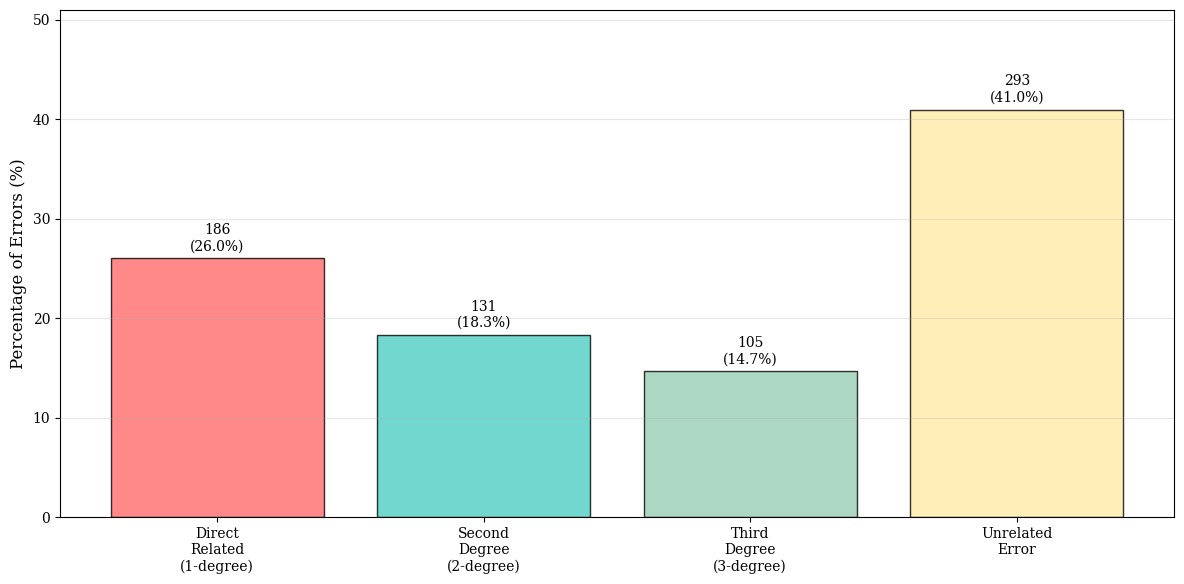

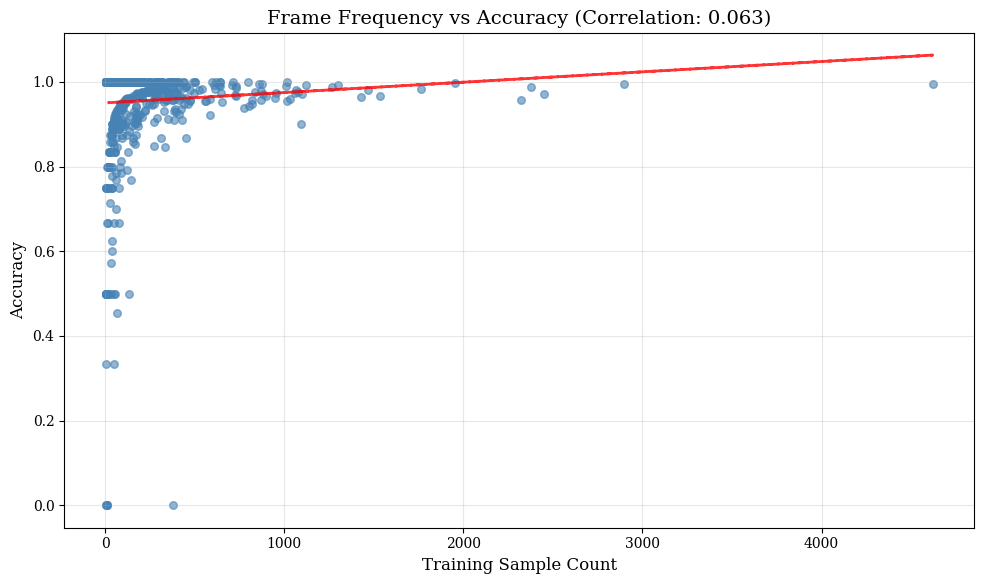


🔍 失败特征分析...


NameError: name 'predictions_df' is not defined

In [29]:
# =============================================================================
# @title ✅ 错误分析
# =============================================================================

# =============================================================================
# 简化版错误分析 - 避免KeyError
# =============================================================================

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# 设置字体
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman', 'Cambria', 'DejaVu Serif']

def run_simple_error_analysis():
    """运行简化的错误分析 - 包含full text预测结果"""

    print("🚀 开始简化错误分析...")

    # 1. 按照你的方式加载模型和数据
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"使用设备: {device}")

        # 加载最佳模型 - 使用你的流程
        model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
        print(f"加载模型: {model_path}")

        # 创建learner并加载模型
        learner = OptimizedPrototypeLearner(device)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        learner.model.load_state_dict(checkpoint['model_state_dict'])

        # 将prototypes转换为CPU上的numpy格式
        raw_prototypes = checkpoint['prototypes']
        learner.prototypes = {}
        for frame_name, proto in raw_prototypes.items():
            if isinstance(proto, torch.Tensor):
                learner.prototypes[frame_name] = proto.cpu().numpy()
            else:
                learner.prototypes[frame_name] = proto

        print(f"模型加载成功，原型数量: {len(learner.prototypes)}")

        # 加载数据
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        full_test_df = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        train_counts = train_df['frame_name'].value_counts()

        with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
            frame_relations = pickle.load(f)

    except Exception as e:
        print(f"❌ 数据加载失败: {e}")
        return None

    # 2. 评估原始测试集
    print("\n" + "="*50)
    print("评估原始测试集")
    print("="*50)
    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 准确率: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result1['top3_accuracy']:.4f}")

    # 3. 评估Full text测试集
    print("\n" + "="*50)
    print("评估Full Text测试集")
    print("="*50)
    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 准确率: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 准确率: {result2['top3_accuracy']:.4f}")

    # 4. 结果对比
    print("\n" + "="*50)
    print("结果对比")
    print("="*50)
    print(f"{'指标':<15} {'原始测试集':<12} {'Full Text':<12} {'差异':<10}")
    print("-" * 50)
    print(f"Top-1 准确率    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 准确率    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")

    # 5. 生成原始测试集的详细预测结果
    print("\n🔍 生成原始测试集详细预测结果...")
    original_predictions_df = generate_detailed_predictions(learner, test_df, "原始测试集")

    # 6. 生成Full text测试集的详细预测结果
    print("\n🔍 生成Full text测试集详细预测结果...")
    fulltext_predictions_df = generate_detailed_predictions(learner, full_test_df, "Full text测试集")

    # 7. 保存预测结果
    save_dir = "/content/drive/MyDrive/more50/framenet_data"
    original_predictions_df.to_pickle(f"{save_dir}/original_test_detailed_predictions.pkl")
    fulltext_predictions_df.to_pickle(f"{save_dir}/fulltext_test_detailed_predictions.pkl")
    print(f"✅ 预测结果已保存到 {save_dir}")

    # 8. 只对原始测试集进行错误分析
    print("\n" + "="*50)
    print("原始测试集错误分析")
    print("="*50)

    predictions_df = original_predictions_df  # 只分析原始测试集

    # 失败特征分析
    print("\n🔍 失败特征分析...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3完全失败: {len(top3_failures)}个不同frames，共{top3_failures.sum()}次失败")
    print("   最容易完全失败的frames:")
    for frame, count in top3_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}次失败 (训练样本: {train_count})")

    print(f"\nTop-1失败但Top-3成功: {len(ranking_failures)}个不同frames，共{ranking_failures.sum()}次排序问题")
    print("   最容易排序错误的frames:")
    for frame, count in ranking_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}次排序错误 (训练样本: {train_count})")

    # 语义关系分析
    print("\n🧠 语义关系分析...")
    semantic_results = analyze_semantic_relations_simple(predictions_df, frame_relations)

    # 样本饱和效应
    print("\n📊 样本饱和效应...")
    saturation_results = analyze_sample_saturation_simple(predictions_df, train_counts)

    # 生成图表
    print("\n📊 生成图表...")
    generate_charts(semantic_results, saturation_results, save_dir)

    print("\n✅ 分析完成!")

    return {
        'original_predictions': original_predictions_df,
        'fulltext_predictions': fulltext_predictions_df,
        'original_results': result1,
        'fulltext_results': result2
    }

def generate_detailed_predictions(learner, test_df, dataset_name):
    """生成详细预测结果"""
    print(f"📊 处理{dataset_name}...")

    # 准备原型数据
    prototype_frames = list(learner.prototypes.keys())
    prototype_vectors = [learner.prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # 准备测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效数据
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码
    learner.model.eval()
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, learner.tokenizer, learner.model,
        batch_size=64, train_mode=False
    ).cpu().numpy()

    # 计算相似度
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 构建预测结果
    predictions_data = []
    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        sorted_indices = np.argsort(scores)[::-1]  # 降序

        result_row = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        predictions_data.append(result_row)

    predictions_df = pd.DataFrame(predictions_data)

    # 验证准确率
    calculated_top1 = predictions_df['is_top1_correct'].mean()
    calculated_top3 = predictions_df['is_top3_correct'].mean()
    print(f"🎯 {dataset_name} Top1准确率: {calculated_top1:.4f}")
    print(f"🎯 {dataset_name} Top3准确率: {calculated_top3:.4f}")

    return predictions_df

def analyze_semantic_relations_simple(predictions_df, frame_relations):
    """简化的语义关系分析"""
    # 构建关系图
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # 二级关系
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # 三级关系
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # 分析错误
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"总错误数: {total_errors}")
    print(f"直接相关错误 (1级): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"二级相关错误 (2级): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"三级相关错误 (3级): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"语义相关错误总计: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"无关错误: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    return {
        'total_errors': total_errors,
        'direct_errors': direct_errors,
        'second_errors': second_errors,
        'third_errors': third_errors,
        'unrelated_errors': unrelated_errors
    }

def analyze_sample_saturation_simple(predictions_df, train_counts):
    """简化的样本饱和效应分析"""
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}样本: {len(segment_data)}个frames, "
                  f"准确率 {segment_data['is_top1_correct'].mean():.3f}±{segment_data['is_top1_correct'].std():.3f}")

    return frame_accuracy

def generate_charts(semantic_results, frame_accuracy, save_dir):
    """生成图表"""
    # 语义错误分解图
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [semantic_results['direct_errors'], semantic_results['second_errors'],
              semantic_results['third_errors'], semantic_results['unrelated_errors']]
    percentages = [v/semantic_results['total_errors']*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 频率相关图
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. 失败特征分析
    print("\n🔍 失败特征分析...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3完全失败: {len(top3_failures)}个不同frames，共{top3_failures.sum()}次失败")
    print(f"Top-1失败但Top-3成功: {len(ranking_failures)}个不同frames，共{ranking_failures.sum()}次排序问题")

    # 3. 语义关系分析
    print("\n🧠 语义关系分析...")

    # 构建关系图
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # 二级关系
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # 三级关系
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # 分析错误
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"总错误数: {total_errors}")
    print(f"直接相关错误 (1级): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"二级相关错误 (2级): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"三级相关错误 (3级): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"语义相关错误总计: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"无关错误: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    # 4. 样本饱和效应
    print("\n📊 样本饱和效应...")
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}样本: {len(segment_data)}个frames, "
                  f"准确率 {segment_data['is_top1_correct'].mean():.3f}±{segment_data['is_top1_correct'].std():.3f}")

    # 5. 生成图表
    print("\n📊 生成图表...")
    save_dir = "/content/drive/MyDrive/more50/framenet_data"

    # 语义错误分解图
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [direct_errors, second_errors, third_errors, unrelated_errors]
    percentages = [v/total_errors*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 频率相关图
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ 分析完成!")

    return {
        'semantic_errors': {
            'direct': direct_errors,
            'second': second_errors,
            'third': third_errors,
            'unrelated': unrelated_errors,
            'total': total_errors
        },
        'frame_accuracy': frame_accuracy
    }

# 运行分析
if __name__ == "__main__":
    results = run_simple_error_analysis()

In [54]:
# @title 全集聚类测试
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI 自动选择聚类数（KMeans）"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # 不足以聚类，直接平均

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # 注意去掉 +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """加载最佳训练模型"""
    print("🚀 加载最佳训练模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # 按优先级查找模型文件
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # 也查找其他可能的最佳模型文件
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"📁 找到模型: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("❌ 未找到最佳模型文件！")
        return None, None, None, None

    # 加载模型
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # 获取训练时的最佳准确率
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"✅ 成功加载模型，训练时最佳准确率: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"❌ 模型加载失败: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """使用训练好的模型重新编码并构建聚类原型"""
    print("\n🔄 使用训练好的模型重新编码训练数据并构建聚类原型...")

    model.eval()
    frame2embeds = defaultdict(list)

    # 重新编码所有训练数据
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="重新编码训练数据"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # 收集每个frame的embeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"批次编码错误: {e}")
                continue

    print(f"编码完成，收集到 {len(frame2embeds)} 个frame的embeddings")

    # 对每个frame进行聚类构造子原型
    print("\n🎯 对每个frame进行聚类...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="聚类构建原型"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"聚类完成:")
    print(f"  单原型frame: {clustering_stats['single_prototype']}")
    print(f"  多原型frame: {clustering_stats['multi_prototype']}")
    print(f"  总原型数量: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    使用多原型进行评估，对每个样本选择最接近的子原型
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 使用多原型系统进行评估")

    # 准备所有原型 - 展开多原型
    all_prototype_info = []  # (frame_name, prototype_idx, prototype_vector)
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(all_prototype_vectors)} 个原型 (来自{len(frame_multi_prototypes)}个frame)")

    # 批量编码测试数据的target spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码target embeddings
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # 计算与所有原型的相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # 获取所有原型的相似度分数
        scores = similarities[i]

        # 按frame分组计算最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                # 对每个frame，取该frame所有子原型中相似度最高的那个
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 根据frame级别的最高分数排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1和Top-3预测
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # 打印结果
    print(f"\n✅ 多原型评估结果 (最接近子原型策略)")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"处理样本: {results['valid_samples']}/{len(test_df)}")
    print(f"使用原型: {results['prototype_count']} (来自{results['frame_count']}个frame)")

    return results

def test_clustered_model_on_datasets():
    """测试聚类模型在两个测试集上的表现"""
    print("="*80)
    print("测试最佳训练模型+聚类原型在两个测试集上的表现")
    print("="*80)

    # 1. 加载最佳训练模型
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. 加载训练数据（用于重新构建原型）
    print("\n📊 加载训练数据...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"训练数据: {len(train_df):,} 样本")

    # 3. 使用训练好的模型重新编码并构建聚类原型
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. 分析多原型信息
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. 加载两个测试集
    print("\n📊 加载测试集...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"原始测试集: {len(test_df_original):,} 样本")
    print(f"Fulltext测试集: {len(test_df_fulltext):,} 样本")

    # 6. 在两个测试集上进行评估
    results = {}

    # 原始测试集评估
    print(f"\n" + "="*60)
    print("📊 在原始测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"原始测试集结果:")
        print(f"  Top-1准确率: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ 原始测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # Fulltext测试集评估
    print(f"\n" + "="*60)
    print("🎯 在Fulltext测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"Fulltext测试集结果:")
        print(f"  Top-1准确率: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ Fulltext测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. 结果汇总
    print(f"\n" + "="*80)
    print("聚类模型测试结果汇总 (最接近子原型策略)")
    print("="*80)

    print(f"模型信息:")
    print(f"  训练时最佳准确率: {train_best_acc:.4f}")
    print(f"  聚类统计: {clustering_stats}")

    # 显示多原型统计
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  多原型frame数: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  总原型数量: {total_prototypes}")

    print(f"\n测试集结果:")
    print(f"{'测试集':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'原始测试集':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'Fulltext测试集':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. 保存结果
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """保存结果到drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\n💾 结果已保存至: {save_path}")

def analyze_clustering_results():
    """简单分析聚类结果"""
    print(f"\n📈 聚类结果分析...")

    # 这里可以添加更详细的分析，比如：
    # - 哪些frame被聚类了
    # - 聚类数量分布
    # - 聚类质量评估等
    pass

# 运行测试
if __name__ == "__main__":
    print("🚀 开始测试最佳训练模型+聚类原型...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n✅ 测试完成！")

            # 简单的性能分析
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\n📊 性能总结:")
                print(f"  原始测试集准确率: {orig_acc:.4f}")
                print(f"  Fulltext测试集准确率: {full_acc:.4f}")
                print(f"  两个测试集平均准确率: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  原始测试集表现更好 (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  Fulltext测试集表现更好 (+{full_acc - orig_acc:.4f})")

        else:
            print(f"❌ 测试失败")

    except Exception as e:
        print(f"❌ 测试过程出错: {e}")
        import traceback
        traceback.print_exc()

🚀 开始测试最佳训练模型+聚类原型...
测试最佳训练模型+聚类原型在两个测试集上的表现
🚀 加载最佳训练模型...
📁 找到模型: best_model.pt
✅ 成功加载模型，训练时最佳准确率: 0.9282

📊 加载训练数据...
训练数据: 150,110 样本

🔄 使用训练好的模型重新编码训练数据并构建聚类原型...


重新编码训练数据: 100%|██████████| 2346/2346 [05:04<00:00,  7.70it/s]


编码完成，收集到 1014 个frame的embeddings

🎯 对每个frame进行聚类...


聚类构建原型: 100%|██████████| 1014/1014 [00:36<00:00, 27.43it/s]


聚类完成:
  单原型frame: 53
  多原型frame: 961
  总原型数量: 2974

📊 加载测试集...
原始测试集: 25,527 样本
Fulltext测试集: 6,872 样本

📊 在原始测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 25527 个测试样本，2974 个原型 (来自1014个frame)
📝 有效测试样本: 25527/25527

✅ 多原型评估结果 (最接近子原型策略)
Top-1准确率: 0.9606
Top-3准确率: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
处理样本: 25527/25527
使用原型: 2974 (来自1014个frame)
原始测试集结果:
  Top-1准确率: 0.9606
  Top-3准确率: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

🎯 在Fulltext测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 6872 个测试样本，2974 个原型 (来自1014个frame)
📝 有效测试样本: 6872/6872

✅ 多原型评估结果 (最接近子原型策略)
Top-1准确率: 0.9415
Top-3准确率: 0.9722
Macro F1: 0.8670
Weighted F1: 0.9454
处理样本: 6872/6872
使用原型: 2974 (来自1014个frame)
Fulltext测试集结果:
  Top-1准确率: 0.9415
  Top-3准确率: 0.9722
  Macro F1: 0.8670
  Weighted F1: 0.9454

聚类模型测试结果汇总 (最接近子原型策略)
模型信息:
  训练时最佳准确率: 0.9282
  聚类统计: {'single_prototype': 53, 'multi_prototype': 961, 'total_prototypes': 2974}
  多原型frame数: 961/1014
  总原型数量: 2974

测试集结果:
测试集             Top-1    Top-3    Macro F1   Weighted F1 
--------------

In [58]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI 自动选择聚类数（KMeans）"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # 不足以聚类，直接平均

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # 注意去掉 +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """加载最佳训练模型"""
    print("🚀 加载最佳训练模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # 按优先级查找模型文件
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # 也查找其他可能的最佳模型文件
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"📁 找到模型: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("❌ 未找到最佳模型文件！")
        return None, None, None, None

    # 加载模型
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # 获取训练时的最佳准确率
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"✅ 成功加载模型，训练时最佳准确率: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"❌ 模型加载失败: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """使用训练好的模型重新编码并构建聚类原型"""
    print("\n🔄 使用训练好的模型重新编码训练数据并构建聚类原型...")

    model.eval()
    frame2embeds = defaultdict(list)

    # 重新编码所有训练数据
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="重新编码训练数据"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # 收集每个frame的embeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"批次编码错误: {e}")
                continue

    print(f"编码完成，收集到 {len(frame2embeds)} 个frame的embeddings")

    # 对每个frame进行聚类构造子原型
    print("\n🎯 对每个frame进行聚类...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="聚类构建原型"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"聚类完成:")
    print(f"  单原型frame: {clustering_stats['single_prototype']}")
    print(f"  多原型frame: {clustering_stats['multi_prototype']}")
    print(f"  总原型数量: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    使用多原型进行评估，对每个样本选择最接近的子原型
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 使用多原型系统进行评估")

    # 准备所有原型 - 展开多原型
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(all_prototype_vectors)} 个原型")

    # 批量编码测试数据的target spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码target embeddings - 完全静默
    print("编码测试样本...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # 禁用所有tqdm进度条的环境变量
            import os
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                # 恢复原来的环境变量
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # 计算与所有原型的相似度
    print("计算相似度...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果 - 完全静默处理
    print("计算评估结果...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    # 完全静默的循环，不使用任何进度条
    for i, gold_frame in enumerate(valid_frames):
        # 获取所有原型的相似度分数
        scores = similarities[i]

        # 按frame分组计算最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 根据frame级别的最高分数排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1和Top-3预测
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # 打印结果
    print(f"\n✅ 评估完成")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果 - 只保留这个进度条
    print("计算评估结果...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    from tqdm import tqdm
    for i, gold_frame in enumerate(tqdm(valid_frames, desc="评估中", ncols=80, ascii=True)):
        # 获取所有原型的相似度分数
        scores = similarities[i]

        # 按frame分组计算最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 根据frame级别的最高分数排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1和Top-3预测
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # 打印结果
    print(f"\n✅ 评估完成")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results

def test_clustered_model_on_datasets():
    """测试聚类模型在两个测试集上的表现"""
    print("="*80)
    print("测试最佳训练模型+聚类原型在两个测试集上的表现")
    print("="*80)

    # 1. 加载最佳训练模型
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. 加载训练数据（用于重新构建原型）
    print("\n📊 加载训练数据...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"训练数据: {len(train_df):,} 样本")

    # 3. 使用训练好的模型重新编码并构建聚类原型
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. 分析多原型信息
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. 加载两个测试集
    print("\n📊 加载测试集...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"原始测试集: {len(test_df_original):,} 样本")
    print(f"Fulltext测试集: {len(test_df_fulltext):,} 样本")

    # 6. 在两个测试集上进行评估
    results = {}

    # 原始测试集评估
    print(f"\n" + "="*60)
    print("📊 在原始测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"原始测试集结果:")
        print(f"  Top-1准确率: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ 原始测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # Fulltext测试集评估
    print(f"\n" + "="*60)
    print("🎯 在Fulltext测试集上测试聚类模型...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"Fulltext测试集结果:")
        print(f"  Top-1准确率: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3准确率: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"❌ Fulltext测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. 结果汇总
    print(f"\n" + "="*80)
    print("聚类模型测试结果汇总 (最接近子原型策略)")
    print("="*80)

    print(f"模型信息:")
    print(f"  训练时最佳准确率: {train_best_acc:.4f}")
    print(f"  聚类统计: {clustering_stats}")

    # 显示多原型统计
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  多原型frame数: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  总原型数量: {total_prototypes}")

    print(f"\n测试集结果:")
    print(f"{'测试集':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'原始测试集':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'Fulltext测试集':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. 保存结果
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """保存结果到drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\n💾 结果已保存至: {save_path}")

def analyze_clustering_results():
    """简单分析聚类结果"""
    print(f"\n📈 聚类结果分析...")

    # 这里可以添加更详细的分析，比如：
    # - 哪些frame被聚类了
    # - 聚类数量分布
    # - 聚类质量评估等
    pass

# 运行测试
if __name__ == "__main__":
    print("🚀 开始测试最佳训练模型+聚类原型...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n✅ 测试完成！")

            # 简单的性能分析
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\n📊 性能总结:")
                print(f"  原始测试集准确率: {orig_acc:.4f}")
                print(f"  Fulltext测试集准确率: {full_acc:.4f}")
                print(f"  两个测试集平均准确率: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  原始测试集表现更好 (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  Fulltext测试集表现更好 (+{full_acc - orig_acc:.4f})")

        else:
            print(f"❌ 测试失败")

    except Exception as e:
        print(f"❌ 测试过程出错: {e}")
        import traceback
        traceback.print_exc()

🚀 开始测试最佳训练模型+聚类原型...
测试最佳训练模型+聚类原型在两个测试集上的表现
🚀 加载最佳训练模型...
📁 找到模型: best_model.pt
✅ 成功加载模型，训练时最佳准确率: 0.9282

📊 加载训练数据...


步骤3/8: 重新编码并构建聚类原型:  25%|██▌       | 2/8 [10:17<30:53, 308.86s/it]


训练数据: 150,110 样本

🔄 使用训练好的模型重新编码训练数据并构建聚类原型...


重新编码训练数据: 100%|██████████| 2346/2346 [05:08<00:00,  7.61it/s]


编码完成，收集到 1014 个frame的embeddings

🎯 对每个frame进行聚类...


聚类构建原型: 100%|██████████| 1014/1014 [00:36<00:00, 27.55it/s]


聚类完成:
  单原型frame: 53
  多原型frame: 961
  总原型数量: 2974

📊 加载测试集...
原始测试集: 25,527 样本
Fulltext测试集: 6,872 样本

📊 在原始测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 25527 个测试样本，2974 个原型
📝 有效测试样本: 25527/25527
编码测试样本...
计算相似度...
计算评估结果...

✅ 评估完成
Top-1准确率: 0.9606
Top-3准确率: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
原始测试集结果:
  Top-1准确率: 0.9606
  Top-3准确率: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

🎯 在Fulltext测试集上测试聚类模型...
📊 使用多原型系统进行评估
🎯 评估 6872 个测试样本，2974 个原型
📝 有效测试样本: 6872/6872
编码测试样本...
计算相似度...
计算评估结果...

✅ 评估完成
Top-1准确率: 0.9415
Top-3准确率: 0.9722
Macro F1: 0.8670
Weighted F1: 0.9454
Fulltext测试集结果:
  Top-1准确率: 0.9415
  Top-3准确率: 0.9722
  Macro F1: 0.8670
  Weighted F1: 0.9454

聚类模型测试结果汇总 (最接近子原型策略)
模型信息:
  训练时最佳准确率: 0.9282
  聚类统计: {'single_prototype': 53, 'multi_prototype': 961, 'total_prototypes': 2974}
  多原型frame数: 961/1014
  总原型数量: 2974

测试集结果:
测试集             Top-1    Top-3    Macro F1   Weighted F1 
------------------------------------------------------------
原始测试集           0.9606   0.9934   0.915

In [41]:
# @title ✅ 完整修复版 Few-shot Prototype Learner（含最佳模型保存 + Test 评估）

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ✅ 你自己已有的依赖项（以下假设都已经导入）
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"使用 {shot_method} 方法训练")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\n生成 {shot_num}-shot 训练数据集...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot 数据集生成完成:")
        print(f"   总样本数: {len(few_shot_df):,}")
        print(f"   样本充足frame: {stats['sufficient_samples']}")
        print(f"   样本不足frame: {stats['insufficient_samples']}")
        print(f"   平均每frame: {stats['total_samples']/len(frame_groups):.1f} 样本")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # 确保loss是标量值，不是张量
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"最佳模型已保存: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"成功加载检查点: {checkpoint_path}")
            print(f"   恢复epoch: {checkpoint['epoch']}, 最佳准确率: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"加载失败: {e}")
            print(f"加载失败路径: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """安全计算张量列表的平均值，确保处理CUDA张量"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # 将张量移到CPU并转换为标量
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # 收集损失值，确保都转换为标量
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # 更新进度条显示
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # 计算平均损失
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # 验证
            acc = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"验证准确率: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # 重建原型
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # 检查是否是最佳模型
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"连续{patience}轮无提升，提前停止")
                    break

        # 加载最佳模型
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("未找到最佳模型文件，使用最后状态")

        # 保存最终模型
        torch.save({
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc,
        }, f"{self.save_dir}/final_model.pt")
        print(f"最后一轮模型已保存")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"不支持的方法: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\n加载测试集: {len(test_df):,} 样本")
    result = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"\nTest评估完成: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\n🚀 开始 {method} 训练...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\n📊 {method} 训练完成，开始最终评估...")

    # 验证集评估
    print("=" * 50)
    print("📈 验证集 (Validation) 评估:")
    val_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # 测试集评估
    print("=" * 50)
    print("🎯 测试集 (Test) 评估:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"✅ {method} 训练和评估完成!")
    print(f"📊 最终结果汇总:")
    print(f"   验证集 - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   测试集 - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# 运行训练
if __name__ == "__main__":
    # 策略B: 频繁更新，更低学习率，更多epoch

    # 3-shot训练
    learner, val_result, test_result = run_single_method_training('3-shot', epochs=20)

    # 5-shot训练
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shot训练
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)


🚀 开始 3-shot 训练...
使用 3-shot 方法训练

生成 3-shot 训练数据集...
3-shot 数据集生成完成:
   总样本数: 2,962
   样本充足frame: 961
   样本不足frame: 53
   平均每frame: 2.9 样本
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11339.37it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4081
Top-3准确率: 0.5936
Macro F1: 0.3998
Weighted F1: 0.4231
处理样本: 25113/25113
验证准确率: 0.4081 | Loss: 2.1969
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11279.41it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep1_acc0.4081.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4265
Top-3准确率: 0.6075
Macro F1: 0.4163
Weighted F1: 0.4414
处理样本: 25113/25113
验证准确率: 0.4265 | Loss: 0.9228
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11396.77it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4259
Top-3准确率: 0.6067
Macro F1: 0.4186
Weighted F1: 0.4408
处理样本: 25113/25113
验证准确率: 0.4259 | Loss: 0.5376
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11163.94it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4235
Top-3准确率: 0.6021
Macro F1: 0.4163
Weighted F1: 0.4386
处理样本: 25113/25113
验证准确率: 0.4235 | Loss: 0.3413
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11137.33it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4182
Top-3准确率: 0.5966
Macro F1: 0.4146
Weighted F1: 0.4329
处理样本: 25113/25113
验证准确率: 0.4182 | Loss: 0.2255
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11285.78it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4161
Top-3准确率: 0.5952
Macro F1: 0.4131
Weighted F1: 0.4312
处理样本: 25113/25113
验证准确率: 0.4161 | Loss: 0.1558
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 11185.63it/s]


原型构建完成: 1014 frames
连续4轮无提升，提前停止
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
最后一轮模型已保存

📊 3-shot 训练完成，开始最终评估...
📈 验证集 (Validation) 评估:
📊 使用已有frame原型


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [49]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_on_original_test():
    """测试3-shot最佳模型在原始测试集上的效果"""
    print("🚀 开始测试3-shot最佳模型在原始测试集上的效果...")
    print("=" * 70)

    # 设备设置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 1. 加载3-shot最佳模型
    print("\n📥 步骤1: 加载3-shot最佳模型")
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("❌ 未找到3-shot最佳模型文件！")
        return None

    # 选择准确率最高的模型文件
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"📁 选择模型: {os.path.basename(best_model_path)}")
    print(f"📊 模型验证准确率: {best_acc:.4f}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # 加载最佳模型
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("❌ 3-shot模型加载失败！")
            return None

        print(f"✅ 成功加载3-shot模型 (epoch {epoch})")

    except Exception as e:
        print(f"❌ 加载3-shot模型时出错: {e}")
        return None

    # 2. 加载原始测试集
    print("\n📊 步骤2: 加载原始测试集")
    original_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    try:
        original_test_df = pd.read_pickle(original_test_path)
        print(f"✅ 原始测试集大小: {len(original_test_df):,} 样本")

        # 显示测试集基本信息
        unique_frames = original_test_df['frame_name'].nunique()
        print(f"📋 包含frame数量: {unique_frames}")

    except Exception as e:
        print(f"❌ 无法加载原始测试集: {e}")
        print(f"检查路径: {original_test_path}")
        return None

    # 3. 在原始测试集上评估
    print("\n🎯 步骤3: 在原始测试集上评估3-shot模型")
    print("=" * 70)

    # 确保模型在评估模式
    learner.model.eval()

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                original_test_df,
                learner.prototypes
            )

        # 4. 显示详细结果
        print("\n" + "=" * 70)
        print("🎉 3-shot模型在原始测试集上的评估完成！")
        print("=" * 70)

        print(f"📈 详细测试结果:")
        print(f"   🎯 Top-1 准确率: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   🎯 Top-3 准确率: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   📊 Macro Precision: {result['macro_precision']:.4f}")
        print(f"   📊 Macro Recall: {result['macro_recall']:.4f}")
        print(f"   📊 Macro F1: {result['macro_f1']:.4f}")
        print(f"   📊 Weighted Precision: {result['weighted_precision']:.4f}")
        print(f"   📊 Weighted Recall: {result['weighted_recall']:.4f}")
        print(f"   📊 Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   📋 处理样本数: {result['valid_samples']:,} / {result['total_samples']:,}")
        print(f"   🏷️  原型数量: {result['prototype_count']}")

        # 5. 性能分析
        print(f"\n📋 性能分析:")
        coverage = result['valid_samples'] / len(original_test_df) * 100
        print(f"   样本覆盖率: {coverage:.2f}%")

        if result['top1_accuracy'] > 0.4:
            print("   🟢 表现: 优秀")
        elif result['top1_accuracy'] > 0.3:
            print("   🟡 表现: 良好")
        else:
            print("   🔴 表现: 需要改进")

        # 6. 与验证集性能对比
        print(f"\n🔄 与验证集性能对比:")
        print(f"   验证集准确率: {best_acc:.4f}")
        print(f"   测试集准确率: {result['top1_accuracy']:.4f}")
        diff = result['top1_accuracy'] - best_acc
        if abs(diff) < 0.01:
            print(f"   差异: {diff:+.4f} (稳定)")
        elif diff > 0:
            print(f"   差异: {diff:+.4f} (测试集更好)")
        else:
            print(f"   差异: {diff:+.4f} (可能过拟合)")

        return result

    except Exception as e:
        print(f"❌ 原始测试集评估失败: {e}")
        import traceback
        traceback.print_exc()
        return None

    finally:
        # 清理GPU内存
        if 'learner' in locals():
            del learner
        torch.cuda.empty_cache()

def quick_3shot_test():
    """快速版本的3-shot原始测试集测试"""
    print("⚡ 快速测试3-shot模型在原始测试集...")

    result = test_3shot_on_original_test()

    if result:
        print(f"\n🎊 测试完成！")
        print(f"🏆 最终结果: Top-1准确率 {result['top1_accuracy']:.4f}, Macro F1 {result['macro_f1']:.4f}")
        return result
    else:
        print("💥 测试失败")
        return None

# 运行测试
if __name__ == "__main__":
    print("🧪 3-shot模型原始测试集评估")
    print("选择运行方式:")
    print("1. 详细测试 (推荐)")
    print("2. 快速测试")

    # 运行详细测试
    result = test_3shot_on_original_test()

    # 如果你想要快速测试，可以用下面这行：
    # result = quick_3shot_test()

🧪 3-shot模型原始测试集评估
选择运行方式:
1. 详细测试 (推荐)
2. 快速测试
🚀 开始测试3-shot最佳模型在原始测试集上的效果...
使用设备: cuda

📥 步骤1: 加载3-shot最佳模型
📁 选择模型: best_model_ep2_acc0.4265.pt
📊 模型验证准确率: 0.4265
使用 3-shot 方法训练
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载3-shot模型 (epoch 2)

📊 步骤2: 加载原始测试集
✅ 原始测试集大小: 25,527 样本
📋 包含frame数量: 907

🎯 步骤3: 在原始测试集上评估3-shot模型
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4381
Top-3准确率: 0.6180
Macro F1: 0.4219
Weighted F1: 0.4505
处理样本: 25527/25527

🎉 3-shot模型在原始测试集上的评估完成！
📈 详细测试结果:
   🎯 Top-1 准确率: 0.4381 (43.81%)
   🎯 Top-3 准确率: 0.6180 (61.80%)
   📊 Macro Precision: 0.4203
   📊 Macro Recall: 0.5560
   📊 Macro F1: 0.4219
   📊 Weighted Precision: 0.6066
   📊 Weighted Recall: 0.4381
   📊 Weighted F1: 0.4505
   📋 处理样本数: 25,527 / 25,527
   🏷️  原型数量: 1014

📋 性能分析:
   样本覆盖率: 100.00%
   🟢 表现: 优秀

🔄 与验证集性能对比:
   验证集准确率: 0.4265
   测试集准确率: 0.

In [47]:
# ✅ 完整修复版 Few-shot Prototype Learner（含最佳模型保存 + Test 评估）

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ✅ 你自己已有的依赖项（以下假设都已经导入）
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"使用 {shot_method} 方法训练")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\n生成 {shot_num}-shot 训练数据集...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot 数据集生成完成:")
        print(f"   总样本数: {len(few_shot_df):,}")
        print(f"   样本充足frame: {stats['sufficient_samples']}")
        print(f"   样本不足frame: {stats['insufficient_samples']}")
        print(f"   平均每frame: {stats['total_samples']/len(frame_groups):.1f} 样本")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # 确保loss是标量值，不是张量
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"最佳模型已保存: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"成功加载检查点: {checkpoint_path}")
            print(f"   恢复epoch: {checkpoint['epoch']}, 最佳准确率: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"加载失败: {e}")
            print(f"加载失败路径: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """安全计算张量列表的平均值，确保处理CUDA张量"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # 将张量移到CPU并转换为标量
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # 收集损失值，确保都转换为标量
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # 更新进度条显示
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # 计算平均损失
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # 验证
            self.model.eval()
            with torch.no_grad():
                acc = evaluate_target_known_fixed(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"验证准确率: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # 切换回训练模式
            self.model.train()

            # 重建原型
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # 检查是否是最佳模型
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"连续{patience}轮无提升，提前停止")
                    break

        # 加载最佳模型
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("未找到最佳模型文件，使用最后状态")

        # 保存最终模型
        final_checkpoint = {
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc if 'acc' in locals() else 0.0,
        }
        torch.save(final_checkpoint, f"{self.save_dir}/final_model.pt")
        print(f"最后一轮模型已保存")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"不支持的方法: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    """安全的测试集评估函数，确保所有张量操作正确处理"""
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\n加载测试集: {len(test_df):,} 样本")

    # 确保模型在eval模式
    learner.model.eval()

    with torch.no_grad():
        result = evaluate_target_known_fixed(learner.model, learner.tokenizer, test_df, learner.prototypes)

    print(f"\nTest评估完成: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def safe_evaluate_target_known(model, tokenizer, df, prototypes):
    """安全版本的evaluate_target_known，处理CUDA张量问题"""
    try:
        model.eval()
        with torch.no_grad():
            result = evaluate_target_known(model, tokenizer, df, prototypes)
        return result
    except Exception as e:
        print(f"评估过程中出现错误: {e}")
        print("尝试手动清理GPU缓存...")
        torch.cuda.empty_cache()

        # 重试一次
        try:
            model.eval()
            with torch.no_grad():
                result = evaluate_target_known(model, tokenizer, df, prototypes)
            return result
        except Exception as e2:
            print(f"重试后仍然失败: {e2}")
            # 返回默认结果避免崩溃
            return {'top1_accuracy': 0.0, 'macro_f1': 0.0}

def evaluate_target_known_fixed(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    修复版的Target-known评估：给定target span，评估frame分类准确率
    修复了CUDA张量转换问题
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()

    # 获取或计算frame原型
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("必须提供frame_prototypes或train_df之一")
        print("🔄 现场计算frame原型...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("📊 使用已有frame原型")

    # 准备原型矩阵 - 修复CUDA张量问题
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = []

    for frame in prototype_frames:
        prototype_vec = frame_prototypes[frame]
        # 确保原型向量转换为numpy数组
        if torch.is_tensor(prototype_vec):
            prototype_vectors.append(prototype_vec.detach().cpu().numpy())
        else:
            prototype_vectors.append(prototype_vec)

    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(prototype_frames)} 个frame原型")

    # 批量编码测试数据的target spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤无效spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_indices)}/{len(test_df)}")

    # 批量编码target embeddings - 修复CUDA张量问题
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        # 确保安全转换为numpy
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # 计算cosine相似度
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # 评估结果
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # 获取top-N预测
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # 降序排列
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # 计算各种指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # 打印结果
    print(f"\n✅ Target-known评估结果 (Cosine相似度)")
    print(f"Top-1准确率: {results['top1_accuracy']:.4f}")
    print(f"Top-3准确率: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"处理样本: {results['valid_samples']}/{len(test_df)}")

    return results

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\n🚀 开始 {method} 训练...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\n📊 {method} 训练完成，开始最终评估...")

    # 验证集评估
    print("=" * 50)
    print("📈 验证集 (Validation) 评估:")
    val_result = evaluate_target_known_fixed(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # 测试集评估
    print("=" * 50)
    print("🎯 测试集 (Test) 评估:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"✅ {method} 训练和评估完成!")
    print(f"📊 最终结果汇总:")
    print(f"   验证集 - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   测试集 - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# 运行训练
if __name__ == "__main__":
    # 策略B: 频繁更新，更低学习率，更多epoch


    # 5-shot训练
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shot训练
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)




🚀 开始 5-shot 训练...
使用 5-shot 方法训练

生成 5-shot 训练数据集...
5-shot 数据集生成完成:
   总样本数: 4,804
   样本充足frame: 910
   样本不足frame: 104
   平均每frame: 4.7 样本
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7919.19it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4590
Top-3准确率: 0.6517
Macro F1: 0.4742
Weighted F1: 0.4795
处理样本: 25113/25113
验证准确率: 0.4590 | Loss: 5.3338
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7802.68it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep1_acc0.4590.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4971
Top-3准确率: 0.6811
Macro F1: 0.5150
Weighted F1: 0.5213
处理样本: 25113/25113
验证准确率: 0.4971 | Loss: 1.7640
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 8065.05it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4870
Top-3准确率: 0.6651
Macro F1: 0.5158
Weighted F1: 0.5136
处理样本: 25113/25113
验证准确率: 0.4870 | Loss: 0.8143
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7843.94it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4874
Top-3准确率: 0.6643
Macro F1: 0.5050
Weighted F1: 0.5109
处理样本: 25113/25113
验证准确率: 0.4874 | Loss: 0.4664
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7945.49it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4905
Top-3准确率: 0.6688
Macro F1: 0.4995
Weighted F1: 0.5108
处理样本: 25113/25113
验证准确率: 0.4905 | Loss: 0.3111
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 7966.99it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4847
Top-3准确率: 0.6622
Macro F1: 0.4951
Weighted F1: 0.5051
处理样本: 25113/25113
验证准确率: 0.4847 | Loss: 0.2274
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 8057.46it/s]


原型构建完成: 1014 frames
连续4轮无提升，提前停止
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt
   恢复epoch: 2, 最佳准确率: 0.4971
最后一轮模型已保存

📊 5-shot 训练完成，开始最终评估...
📈 验证集 (Validation) 评估:
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5168
Top-3准确率: 0.7045
Macro F1: 0.5085
Weighted F1: 0.5353
处理样本: 25113/25113
Val Top-1: 0.5168, Macro F1: 0.5085
🎯 测试集 (Test) 评估:

加载测试集: 25,527 样本
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5231
Top-3准确率: 0.7052
Macro F1: 0.5161
Weighted F1: 0.5388
处理样本: 25527/25527

Test评估完成: Top-1: 0.5231, Macro F1: 0.5161
✅ 5-shot 训练和评估完成!
📊 最终结果汇总:
   验证集 - Top-1: 0.5168, Macro F1: 0.5085
   测试集 - Top-1: 0.5231, Macro F1: 0.5161

🚀 开始 10-shot 训练...
使用 10-shot 方法训练

生成 10-shot 训练数据集...
10-shot 数据集生成完成:
   总样本数: 9,156
   样本充足frame: 838
   样本不足frame: 176
   平均每frame: 9.0 样本
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4788.62it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4361
Top-3准确率: 0.6209
Macro F1: 0.4970
Weighted F1: 0.4639
处理样本: 25113/25113
验证准确率: 0.4361 | Loss: 6.9749
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4935.35it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep1_acc0.4361.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4995
Top-3准确率: 0.6674
Macro F1: 0.5658
Weighted F1: 0.5365
处理样本: 25113/25113
验证准确率: 0.4995 | Loss: 1.3416
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4888.73it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep2_acc0.4995.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5927
Top-3准确率: 0.7729
Macro F1: 0.5974
Weighted F1: 0.6046
处理样本: 25113/25113
验证准确率: 0.5927 | Loss: 0.6197
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4886.51it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep3_acc0.5927.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6051
Top-3准确率: 0.7828
Macro F1: 0.6128
Weighted F1: 0.6209
处理样本: 25113/25113
验证准确率: 0.6051 | Loss: 0.4709
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4932.78it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep4_acc0.6051.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6076
Top-3准确率: 0.7863
Macro F1: 0.6122
Weighted F1: 0.6225
处理样本: 25113/25113
验证准确率: 0.6076 | Loss: 0.3826
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4904.27it/s]


原型构建完成: 1014 frames
最佳模型已保存: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6032
Top-3准确率: 0.7839
Macro F1: 0.6080
Weighted F1: 0.6161
处理样本: 25113/25113
验证准确率: 0.6032 | Loss: 0.3206
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4879.61it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5950
Top-3准确率: 0.7763
Macro F1: 0.6021
Weighted F1: 0.6070
处理样本: 25113/25113
验证准确率: 0.5950 | Loss: 0.2629
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4914.16it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5999
Top-3准确率: 0.7841
Macro F1: 0.6008
Weighted F1: 0.6116
处理样本: 25113/25113
验证准确率: 0.5999 | Loss: 0.2204
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4952.47it/s]


原型构建完成: 1014 frames


📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.5905
Top-3准确率: 0.7717
Macro F1: 0.6012
Weighted F1: 0.6022
处理样本: 25113/25113
验证准确率: 0.5905 | Loss: 0.1887
重建原型中...


Computing prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 4891.65it/s]


原型构建完成: 1014 frames
连续4轮无提升，提前停止
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt
   恢复epoch: 5, 最佳准确率: 0.6076
最后一轮模型已保存

📊 10-shot 训练完成，开始最终评估...
📈 验证集 (Validation) 评估:
📊 使用已有frame原型
🎯 评估 25113 个测试样本，1014 个frame原型
📝 有效测试样本: 25113/25113

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6059
Top-3准确率: 0.7854
Macro F1: 0.6087
Weighted F1: 0.6193
处理样本: 25113/25113
Val Top-1: 0.6059, Macro F1: 0.6087
🎯 测试集 (Test) 评估:

加载测试集: 25,527 样本
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.6051
Top-3准确率: 0.7876
Macro F1: 0.6134
Weighted F1: 0.6168
处理样本: 25527/25527

Test评估完成: Top-1: 0.6051, Macro F1: 0.6134
✅ 10-shot 训练和评估完成!
📊 最终结果汇总:
   验证集 - Top-1: 0.6059, Macro F1: 0.6087
   测试集 - Top-1: 0.6051, Macro F1: 0.6134


In [48]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def load_best_model(shot_method):
    """加载指定shot方法的最佳模型"""
    print(f"\n🚀 加载 {shot_method} 最佳模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"❌ 未找到 {shot_method} 最佳模型文件！")
        return None

    # 选择准确率最高的模型文件
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        # 从文件名提取准确率
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]  # 备选方案

    print(f"📁 选择模型: {best_model_path}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # 加载最佳模型
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"❌ {shot_method} 模型加载失败！")
            return None

        print(f"✅ 成功加载 {shot_method} 模型 (epoch {epoch}, acc {best_acc:.4f})")
        return learner

    except Exception as e:
        print(f"❌ 加载 {shot_method} 模型时出错: {e}")
        return None

def test_on_fulltext(learner, shot_method):
    """在fulltext测试集上测试模型"""
    print(f"\n🎯 在Fulltext测试集上测试 {shot_method} 模型...")

    # 加载fulltext测试数据
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

    try:
        fulltext_test_df = pd.read_pickle(test_path)
        print(f"📊 Fulltext测试集大小: {len(fulltext_test_df):,} 样本")
    except Exception as e:
        print(f"❌ 无法加载Fulltext测试集: {e}")
        return None

    # 确保模型在评估模式
    learner.model.eval()

    # 在fulltext测试集上评估
    print("=" * 60)
    print(f"🔥 开始 {shot_method} 模型在Fulltext测试集上的评估...")

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                fulltext_test_df,
                learner.prototypes
            )

        print("=" * 60)
        print(f"🎉 {shot_method} 模型Fulltext测试完成！")
        print(f"📈 Fulltext测试结果:")
        print(f"   Top-1 准确率: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 准确率: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {result['macro_f1']:.4f}")
        print(f"   Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   处理样本数: {result['valid_samples']}")
        print(f"   原型数量: {result['prototype_count']}")

        return result

    except Exception as e:
        print(f"❌ {shot_method} 模型Fulltext测试失败: {e}")
        import traceback
        traceback.print_exc()
        return None

def test_all_models_on_fulltext():
    """测试所有最佳模型在fulltext测试集上的效果"""
    print("🚀 开始测试所有最佳模型在Fulltext测试集上的效果...")
    print("=" * 80)

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n{'='*20} {shot_method.upper()} MODEL {'='*20}")

        # 加载模型
        learner = load_best_model(shot_method)
        if learner is None:
            print(f"⚠️  跳过 {shot_method} 模型测试")
            continue

        # 在fulltext测试集上测试
        result = test_on_fulltext(learner, shot_method)
        if result:
            results[shot_method] = result

        # 清理GPU内存
        del learner
        torch.cuda.empty_cache()

    # 汇总结果
    print("\n" + "="*80)
    print("📊 FULLTEXT测试集结果汇总:")
    print("="*80)

    if results:
        print(f"{'Model':<10} {'Top-1 Acc':<12} {'Top-3 Acc':<12} {'Macro F1':<10} {'Weighted F1':<12}")
        print("-" * 60)

        for shot_method, result in results.items():
            print(f"{shot_method:<10} {result['top1_accuracy']:<12.4f} {result['top3_accuracy']:<12.4f} {result['macro_f1']:<10.4f} {result['weighted_f1']:<12.4f}")

        # 找到最佳模型
        best_method = max(results.keys(), key=lambda x: results[x]['top1_accuracy'])
        best_acc = results[best_method]['top1_accuracy']
        print(f"\n🏆 在Fulltext测试集上表现最佳: {best_method} (Top-1: {best_acc:.4f})")
    else:
        print("❌ 没有成功的测试结果")

    return results

def test_single_model_fulltext(shot_method):
    """测试单个模型在fulltext上的效果"""
    print(f"🎯 单独测试 {shot_method} 模型在Fulltext测试集上的效果")

    # 加载模型
    learner = load_best_model(shot_method)
    if learner is None:
        return None

    # 测试
    result = test_on_fulltext(learner, shot_method)

    # 清理
    del learner
    torch.cuda.empty_cache()

    return result

# 运行测试
if __name__ == "__main__":
    # 选择测试方式：

    # 方式1: 测试所有模型
    print("🔥 选择测试方式:")
    print("1. 测试所有模型 (3-shot, 5-shot, 10-shot)")
    print("2. 单独测试某个模型")

    # 默认测试所有模型
    all_results = test_all_models_on_fulltext()

    # 如果你只想测试某个特定模型，可以用下面的代码：
    # result = test_single_model_fulltext("3-shot")
    # result = test_single_model_fulltext("5-shot")
    # result = test_single_model_fulltext("10-shot")

🔥 选择测试方式:
1. 测试所有模型 (3-shot, 5-shot, 10-shot)
2. 单独测试某个模型
🚀 开始测试所有最佳模型在Fulltext测试集上的效果...

==================== 3-SHOT MODEL ====================

🚀 加载 3-shot 最佳模型...
📁 选择模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
使用 3-shot 方法训练
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载 3-shot 模型 (epoch 2, acc 0.4265)

🎯 在Fulltext测试集上测试 3-shot 模型...
📊 Fulltext测试集大小: 6,872 样本
🔥 开始 3-shot 模型在Fulltext测试集上的评估...
📊 使用已有frame原型
🎯 评估 6872 个测试样本，1014 个frame原型
📝 有效测试样本: 6872/6872

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4288
Top-3准确率: 0.6032
Macro F1: 0.2830
Weighted F1: 0.4501
处理样本: 6872/6872
🎉 3-shot 模型Fulltext测试完成！
📈 Fulltext测试结果:
   Top-1 准确率: 0.4288 (42.88%)
   Top-3 准确率: 0.6032 (60.32%)
   Macro F1: 0.2830
   Weighted F1: 0.4501
   处理样本数: 6872
   原型数量: 1014

==================== 5-SHOT MODEL ====================

🚀 加载 5-shot 最佳模型...
📁 选择模型: 

In [46]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_best_model():
    """测试3-shot最佳模型在测试集上的效果"""

    print("🚀 开始测试3-shot最佳模型...")

    # 设备设置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 查找3-shot最佳模型文件
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("❌ 未找到3-shot最佳模型文件！")
        print(f"检查路径: {checkpoint_dir}")
        return None

    # 选择最新的最佳模型文件（按文件名排序）
    best_model_path = sorted(best_model_files)[-1]
    print(f"📁 找到最佳模型: {best_model_path}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # 加载最佳模型
        print("📥 加载最佳模型...")
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("❌ 模型加载失败！")
            return None

        print(f"✅ 成功加载模型 (epoch {epoch})")

        # 加载测试数据
        print("📊 加载测试数据...")
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        print(f"测试集大小: {len(test_df):,} 样本")

        # 确保模型在评估模式
        learner.model.eval()

        # 在测试集上评估
        print("🎯 开始测试集评估...")
        print("=" * 60)

        with torch.no_grad():
            test_result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                test_df,
                learner.prototypes
            )

        print("=" * 60)
        print("🎉 3-shot模型测试完成！")
        print(f"📈 最终测试结果:")
        print(f"   Top-1 准确率: {test_result['top1_accuracy']:.4f} ({test_result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 准确率: {test_result['top3_accuracy']:.4f} ({test_result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {test_result['macro_f1']:.4f}")
        print(f"   Weighted F1: {test_result['weighted_f1']:.4f}")
        print(f"   处理样本数: {test_result['valid_samples']}")
        print(f"   原型数量: {test_result['prototype_count']}")

        return test_result

    except Exception as e:
        print(f"❌ 测试过程中出现错误: {e}")
        import traceback
        traceback.print_exc()
        return None

def quick_test_model_loading():
    """快速测试模型加载功能"""
    print("🔧 快速测试模型加载...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        # 创建学习器
        learner = OptimizedPrototypeLearnerWithFewShot(device=device, shot_method="3-shot")
        print("✅ 学习器创建成功")

        # 检查模型文件
        checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
        if os.path.exists(checkpoint_dir):
            files = os.listdir(checkpoint_dir)
            print(f"📁 checkpoint目录内容: {files}")

            best_files = [f for f in files if f.startswith('best_model_')]
            if best_files:
                print(f"🎯 找到最佳模型文件: {best_files}")
            else:
                print("⚠️  未找到最佳模型文件")
        else:
            print(f"❌ checkpoint目录不存在: {checkpoint_dir}")

        return True

    except Exception as e:
        print(f"❌ 快速测试失败: {e}")
        return False

# 运行测试
if __name__ == "__main__":
    print("🧪 开始模型测试...")

    # 先做快速测试
    if quick_test_model_loading():
        print("\n" + "="*60)
        # 再做完整测试
        result = test_3shot_best_model()

        if result:
            print(f"\n🎊 测试成功完成！最终准确率: {result['top1_accuracy']:.4f}")
        else:
            print("\n💥 测试失败，请检查错误信息")
    else:
        print("💥 快速测试失败，无法继续")

🧪 开始模型测试...
🔧 快速测试模型加载...
使用 3-shot 方法训练
✅ 学习器创建成功
📁 checkpoint目录内容: ['checkpoint_epoch2.pt', 'checkpoint_epoch4.pt', 'checkpoint_epoch5.pt', 'best_model.pt', 'best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt', 'final_model.pt']
🎯 找到最佳模型文件: ['best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt']

🚀 开始测试3-shot最佳模型...
使用设备: cuda
📁 找到最佳模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
使用 3-shot 方法训练
📥 加载最佳模型...
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载模型 (epoch 2)
📊 加载测试数据...
测试集大小: 25,527 样本
🎯 开始测试集评估...
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4381
Top-3准确率: 0.6180
Macro F1: 0.4219
Weighted F1: 0.4505
处理样本: 25527/25527
🎉 3-shot模型测试完成！
📈 最终测试结果:
   Top-1 准确率: 0.4381 (43.81%)
   Top-3 准确率: 0.6180 (61.80%)
   Macro F1: 0.4219
   Weighted F1: 0.4505
 

In [59]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support

def few_shot_clustering(embeddings, shot_num, frame_name=None, max_k=3, similarity_threshold=0.7):
    """
    适应few-shot的聚类策略

    Args:
        embeddings: numpy array of embeddings
        shot_num: few-shot数量 (3, 5, 10)
        frame_name: frame名称
        max_k: 最大聚类数
        similarity_threshold: 相似度阈值
    """
    if len(embeddings) <= 1:
        return [embeddings[0]] if len(embeddings) == 1 else [np.zeros(768)], "single_sample"

    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)], "two_samples"

    # Few-shot特化的策略
    if shot_num == 3:
        # 3-shot: 非常激进，只要有一点差异就聚类
        min_samples = 2
        max_clusters = 2  # 最多2个簇
        sil_threshold = 0.1
        dist_threshold = 0.05
    elif shot_num == 5:
        # 5-shot: 中等激进
        min_samples = 2
        max_clusters = 3  # 最多3个簇
        sil_threshold = 0.15
        dist_threshold = 0.08
    elif shot_num == 10:
        # 10-shot: 相对保守
        min_samples = 3
        max_clusters = 3  # 最多3个簇
        sil_threshold = 0.2
        dist_threshold = 0.1
    else:
        # 其他情况默认策略
        min_samples = max(2, len(embeddings) // 3)
        max_clusters = min(3, len(embeddings) // 2)
        sil_threshold = 0.2
        dist_threshold = 0.1

    # 计算内部相似度
    center = np.mean(embeddings, axis=0, keepdims=True)
    similarities = cosine_similarity(embeddings, center).flatten()
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)

    # Few-shot下降低相似度要求
    if avg_similarity > similarity_threshold:
        return [np.mean(embeddings, axis=0)], f"high_similarity_{avg_similarity:.3f}"

    # 尝试聚类
    best_score = float("inf")
    best_centers = None
    best_k = 1

    actual_max_k = min(max_clusters + 1, len(embeddings))

    for k in range(2, actual_max_k):
        if k > len(embeddings):
            break

        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
            labels = kmeans.fit_predict(embeddings)

            # 确保每个簇至少有足够样本
            unique_labels, counts = np.unique(labels, return_counts=True)
            if np.min(counts) < min_samples:
                continue

            # 使用DBI分数
            dbi_score = davies_bouldin_score(embeddings, labels)

            # Few-shot下降低silhouette要求
            try:
                sil_score = silhouette_score(embeddings, labels)
            except:
                sil_score = 0

            if sil_score > sil_threshold and dbi_score < best_score:
                best_score = dbi_score
                best_centers = kmeans.cluster_centers_
                best_k = k

        except Exception as e:
            continue

    # 最终决策 - Few-shot下更容易接受聚类
    if best_centers is not None and best_k > 1:
        # 计算簇间距离，Few-shot下降低要求
        from scipy.spatial.distance import pdist
        try:
            inter_cluster_dist = np.mean(pdist(best_centers, metric='cosine'))
            if inter_cluster_dist > dist_threshold:
                return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}_dist{inter_cluster_dist:.3f}"
        except:
            # 如果距离计算失败，仍然尝试使用聚类结果
            return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}"

    # 回退到单原型
    return [np.mean(embeddings, axis=0)], f"fallback_single"

def load_few_shot_best_model(shot_method):
    """加载指定few-shot方法的最佳模型"""
    print(f"\n🚀 加载 {shot_method} 最佳模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"❌ 未找到 {shot_method} 最佳模型文件！")
        return None, None, None, None, None

    # 选择准确率最高的模型文件
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"📁 选择模型: {os.path.basename(best_model_path)}")
    print(f"📊 模型验证准确率: {best_acc:.4f}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # 加载最佳模型
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"❌ {shot_method} 模型加载失败！")
            return None, None, None, None, None

        # 提取shot数量
        shot_num = int(shot_method.split('-')[0])

        print(f"✅ 成功加载 {shot_method} 模型 (epoch {epoch})")
        return learner.model, learner.tokenizer, device, best_acc, shot_num

    except Exception as e:
        print(f"❌ 加载 {shot_method} 模型时出错: {e}")
        return None, None, None, None, None

def build_few_shot_clustered_prototypes(model, tokenizer, train_df, shot_method, device):
    """构建few-shot聚类原型"""
    print(f"\n🔄 为 {shot_method} 构建聚类原型...")

    shot_num = int(shot_method.split('-')[0])

    # 生成few-shot训练数据
    print(f"生成 {shot_num}-shot 数据...")
    few_shot_samples = []
    frame_groups = train_df.groupby('frame_name')

    for frame_name, group in frame_groups:
        if len(group) >= shot_num:
            sampled = group.sample(n=shot_num, random_state=42)
        else:
            sampled = group
        few_shot_samples.append(sampled)

    few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
    print(f"Few-shot数据: {len(few_shot_df)} 样本")

    # 使用训练好的模型编码few-shot数据
    model.eval()
    frame2embeds = defaultdict(list)

    print("编码few-shot数据...")
    with torch.no_grad():
        for batch_idx in range(0, len(few_shot_df), 64):
            batch = few_shot_df.iloc[batch_idx:batch_idx+64]
            try:
                # 禁用进度条
                import os
                old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
                os.environ['TQDM_DISABLE'] = '1'

                try:
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        tokenizer, model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        if torch.is_tensor(embs[j]):
                            frame2embeds[frame_name].append(embs[j].cpu().numpy())
                        else:
                            frame2embeds[frame_name].append(embs[j])
                finally:
                    os.environ['TQDM_DISABLE'] = old_tqdm_disable

            except Exception as e:
                pass

    print(f"编码完成，收集到 {len(frame2embeds)} 个frame的embeddings")

    # 对每个frame进行few-shot聚类
    print("开始few-shot聚类...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0,
        'clustering_reasons': defaultdict(int)
    }

    for frame, embeds in frame2embeds.items():
        embeds = np.array(embeds)

        # 使用few-shot聚类策略
        centers, reason = few_shot_clustering(embeds, shot_num, frame_name=frame)
        frame_multi_prototypes[frame] = centers

        # 统计
        clustering_stats['clustering_reasons'][reason] += 1
        if len(centers) == 1:
            clustering_stats['single_prototype'] += 1
        else:
            clustering_stats['multi_prototype'] += 1
        clustering_stats['total_prototypes'] += len(centers)

    print(f"Few-shot聚类完成:")
    print(f"  单原型frame: {clustering_stats['single_prototype']}")
    print(f"  多原型frame: {clustering_stats['multi_prototype']}")
    print(f"  总原型数量: {clustering_stats['total_prototypes']}")

    # 显示聚类原因统计
    print(f"主要聚类决策:")
    for reason, count in sorted(clustering_stats['clustering_reasons'].items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {reason}: {count} frames")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes_simple(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """简化版多原型评估"""
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 使用多原型评估")

    # 准备所有原型
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(all_prototype_vectors)} 个原型")

    # 处理测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效样本
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_sentences)}/{len(test_df)}")

    # 编码测试样本
    print("编码测试样本...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # 禁用进度条
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # 计算相似度并评估
    print("计算相似度和评估结果...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]

        # 按frame分组找最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_f1": macro_f,
        "weighted_f1": weighted_f,
    }

    print(f"✅ 评估完成: Top-1 {results['top1_accuracy']:.4f}, Macro F1 {results['macro_f1']:.4f}")
    return results

def test_few_shot_models_with_clustering():
    """测试所有few-shot模型的聚类效果"""
    print("="*80)
    print("Few-shot模型聚类效果测试")
    print("="*80)

    # 加载数据
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n" + "="*60)
        print(f"测试 {shot_method} 模型")
        print("="*60)

        # 加载模型
        model, tokenizer, device, train_acc, shot_num = load_few_shot_best_model(shot_method)
        if model is None:
            continue

        # 构建聚类原型
        frame_multi_prototypes, clustering_stats = build_few_shot_clustered_prototypes(
            model, tokenizer, train_df, shot_method, device
        )

        # 在两个测试集上评估
        method_results = {}

        # 原始测试集
        print(f"\n📊 {shot_method} 在原始测试集上测试...")
        try:
            result_orig = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_original, frame_multi_prototypes
            )
            method_results['original'] = result_orig
        except Exception as e:
            print(f"❌ 原始测试集失败: {e}")
            method_results['original'] = None

        # Fulltext测试集
        print(f"\n🎯 {shot_method} 在Fulltext测试集上测试...")
        try:
            result_full = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_fulltext, frame_multi_prototypes
            )
            method_results['fulltext'] = result_full
        except Exception as e:
            print(f"❌ Fulltext测试集失败: {e}")
            method_results['fulltext'] = None

        results[shot_method] = {
            'train_acc': train_acc,
            'clustering_stats': clustering_stats,
            'test_results': method_results
        }

        # 清理内存
        del model, tokenizer
        torch.cuda.empty_cache()

    # 结果汇总
    print(f"\n" + "="*80)
    print("Few-shot模型聚类效果汇总")
    print("="*80)

    print(f"{'方法':<10} {'训练准确率':<12} {'多原型数':<10} {'原始测试集':<12} {'Fulltext测试集':<15}")
    print("-" * 70)

    for method, data in results.items():
        train_acc = data['train_acc']
        multi_proto = data['clustering_stats']['multi_prototype']

        orig_acc = "失败"
        full_acc = "失败"
        if data['test_results']['original']:
            orig_acc = f"{data['test_results']['original']['top1_accuracy']:.4f}"
        if data['test_results']['fulltext']:
            full_acc = f"{data['test_results']['fulltext']['top1_accuracy']:.4f}"

        print(f"{method:<10} {train_acc:<12.4f} {multi_proto:<10} {orig_acc:<12} {full_acc:<15}")

    return results

# 运行测试
if __name__ == "__main__":
    print("🚀 开始Few-shot模型聚类测试...")
    results = test_few_shot_models_with_clustering()

    print(f"\n✅ 测试完成！结果保存在 results 变量中")

🚀 开始Few-shot模型聚类测试...
Few-shot模型聚类效果测试

测试 3-shot 模型

🚀 加载 3-shot 最佳模型...
📁 选择模型: best_model_ep2_acc0.4265.pt
📊 模型验证准确率: 0.4265
使用 3-shot 方法训练
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载 3-shot 模型 (epoch 2)

🔄 为 3-shot 构建聚类原型...
生成 3-shot 数据...
Few-shot数据: 2962 样本
编码few-shot数据...
编码完成，收集到 1014 个frame的embeddings
开始few-shot聚类...
Few-shot聚类完成:
  单原型frame: 1014
  多原型frame: 0
  总原型数量: 1014
主要聚类决策:
  single_sample: 27 frames
  two_samples: 26 frames
  high_similarity_0.900: 19 frames

📊 3-shot 在原始测试集上测试...
📊 使用多原型评估
🎯 评估 25527 个测试样本，1014 个原型
📝 有效测试样本: 25527/25527
编码测试样本...
计算相似度和评估结果...
✅ 评估完成: Top-1 0.4381, Macro F1 0.4219

🎯 3-shot 在Fulltext测试集上测试...
📊 使用多原型评估
🎯 评估 6872 个测试样本，1014 个原型
📝 有效测试样本: 6872/6872
编码测试样本...
计算相似度和评估结果...
✅ 评估完成: Top-1 0.4288, Macro F1 0.2830

测试 5-shot 模型

🚀 加载 5-shot 最佳模型...
📁 选择模型: best_model_ep2_acc0.4971.pt
📊 模型验证准确率: 0.4971
使用 5-shot 方法训练
成功加载检查点: /content/drive

In [ ]:
# @title 测试全集


# ✅ 路径设置
model_path = "/content/drive/MyDrive/more50/framenet_data/optimized_prototype_model_distilbert.pt"
proto_path = "/content/drive/MyDrive/more50/framenet_data/frame_prototypes_distilbert.pkl"
test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ✅ 加载模型与 tokenizer


# ✅ 加载测试集与原型
with open(test_path, "rb") as f:
    test_df = pickle.load(f)
test_df = test_df.to_dict("records")

with open(proto_path, "rb") as f:
    frame_multi_prototypes = pickle.load(f)



✅ 优化DistilBERT编码器初始化完成
   基础模型: distilbert-base-uncased
   维度: 768
   特色: 最后一层 + 改进span pooling (分类任务最优)


[cosine] Fulltext Target-known Evaluation: 100%|██████████| 1247/1247 [03:33<00:00,  5.83it/s]


🎯 Final Evaluation Results (Fulltext Test Set, Target-Known, Multi-Prototype, Cosine)
------------------------------------------------------------
Top-1 Accuracy        : 0.8573
Top-3 Accuracy        : 0.9487
Macro Precision       : 0.7175
Macro Recall          : 0.6969
Macro F1              : 0.6937
Weighted Precision    : 0.9193
Weighted Recall       : 0.8573
Weighted F1           : 0.8711
Total evaluated targets: 1247
------------------------------------------------------------


In [17]:
# @title 检测fe的区分能力

from tqdm import tqdm

def extract_fe_embeddings_batch(sentences, fe_spans_list, all_preferred_fes, model, tokenizer, device, batch_size=64):
    """
    批量提取 FE embeddings，返回每个样本的 {fe_name: embedding} 字典，带进度条
    """
    all_fe_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}
    model.eval()

    for batch_start in tqdm(range(0, len(sentences), batch_size), desc="🧠 提取FE embeddings", leave=False):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_fe_spans = fe_spans_list[batch_start:batch_end]

        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True,
            return_offsets_mapping=True,
            return_attention_mask=True
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
            hidden_states = outputs.last_hidden_state

        for i in range(len(batch_sentences)):
            try:
                offset_mapping = encoding['offset_mapping'][i]
                fe_spans = batch_fe_spans[i]
                fe_embeddings = {}

                if isinstance(fe_spans, list):
                    for fe in fe_spans:
                        if (
                            isinstance(fe, dict)
                            and 'fe_name' in fe
                            and fe['fe_name'] in all_preferred_fes
                            and 'start' in fe and 'end' in fe
                        ):
                            start_char, end_char = fe['start'], fe['end']
                            selected_indices = []

                            for idx, (start, end) in enumerate(offset_mapping):
                                start, end = int(start), int(end)
                                if (start <= start_char < end or start < end_char <= end) and start != end:
                                    selected_indices.append(idx)

                            if selected_indices:
                                selected_hidden = hidden_states[i, list(set(selected_indices)), :]
                                fe_embedding = selected_hidden.mean(dim=0).cpu().numpy()
                                fe_embeddings[fe['fe_name']] = fe_embedding

                all_fe_embeddings.append(fe_embeddings)
                stats["success"] += int(bool(fe_embeddings))
                stats["failed"] += int(not fe_embeddings)

            except Exception:
                all_fe_embeddings.append({})
                stats["failed"] += 1

    return all_fe_embeddings, stats


def batched_fe_only_classification_test(val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device):
    """
    批量 FE-only frame 分类实验，使用真实 cosine 相似度匹配，带进度条
    """
    print("🧪 批量 FE-only frame 分类测试中...")

    val_sentences = val_df['sentence'].tolist()
    val_fe_spans = val_df['fe_spans'].tolist()
    val_true_frames = val_df['frame_name'].tolist()

    # 所有出现在偏好表中的 FE 类型
    all_preferred_fes = set()
    for fes in frame_fe_preferences.values():
        all_preferred_fes.update(fes)
    all_preferred_fes = list(all_preferred_fes)

    print(f"📊 涉及的 FE 类型数量: {len(all_preferred_fes)}")

    # 批量提取 FE embeddings（带进度条）
    print("⚡ 提取 FE embeddings...")
    query_fe_embeddings, fe_stats = extract_fe_embeddings_batch(
        val_sentences, val_fe_spans, all_preferred_fes, model, tokenizer, device, batch_size=64
    )
    print(f"✅ 提取完成: 成功 {fe_stats['success']}, 失败 {fe_stats['failed']}")

    predictions = []
    stats = {
        "total_samples": len(val_df),
        "samples_with_fes": 0,
        "samples_without_fes": 0,
        "fe_predictions": 0,
        "random_predictions": 0
    }

    print("🔄 计算相似度并预测中...")
    for i in tqdm(range(len(query_fe_embeddings)), desc="🔍 相似度预测"):
        query_fe_embs = query_fe_embeddings[i]

        if not query_fe_embs:
            prediction = list(frame_fe_prototypes.keys())[0]
            predictions.append(prediction)
            stats["samples_without_fes"] += 1
            stats["random_predictions"] += 1
            continue

        stats["samples_with_fes"] += 1
        frame_scores = {}

        for frame_name in frame_fe_prototypes:
            preferred_fes = frame_fe_preferences.get(frame_name, [])
            fe_protos = frame_fe_prototypes.get(frame_name, {})

            total_sim, count = 0.0, 0
            for fe_name, query_emb in query_fe_embs.items():
                if fe_name in fe_protos:
                    query_tensor = torch.tensor(query_emb, device=device)
                    proto_tensor = fe_protos[fe_name]
                    sim = F.cosine_similarity(query_tensor, proto_tensor, dim=0).item()
                    total_sim += sim
                    count += 1

            frame_scores[frame_name] = total_sim / count if count > 0 else 0.0

        if max(frame_scores.values()) > 0:
            prediction = max(frame_scores, key=frame_scores.get)
            stats["fe_predictions"] += 1
        else:
            prediction = list(frame_fe_prototypes.keys())[0]
            stats["random_predictions"] += 1

        predictions.append(prediction)

    # 准确率评估
    correct = sum(pred == gold for pred, gold in zip(predictions, val_true_frames))
    fe_correct = sum(
        pred == gold for pred, gold, fe_emb in zip(predictions, val_true_frames, query_fe_embeddings) if fe_emb
    )

    overall_accuracy = correct / stats['total_samples']
    fe_only_accuracy = fe_correct / stats['samples_with_fes'] if stats['samples_with_fes'] > 0 else 0.0
    fe_coverage = stats['samples_with_fes'] / stats['total_samples']

    # 打印结果
    print("\n📊 FE-only 分类结果:")
    print(f"   总样本数: {stats['total_samples']:,}")
    print(f"   有FE的样本: {stats['samples_with_fes']:,}")
    print(f"   无FE的样本: {stats['samples_without_fes']:,}")
    print(f"   整体准确率: {overall_accuracy:.4f}")
    print(f"   仅FE样本准确率: {fe_only_accuracy:.4f}")
    print(f"   FE覆盖率: {fe_coverage:.2%}")

    # 判断贡献潜力
    if fe_only_accuracy > 0:
        print(f"\n💡 结论:")
        if fe_only_accuracy >= 0.6:
            print(f"   ✅ FE具有较强的独立区分能力 ({fe_only_accuracy:.1%})")
        elif fe_only_accuracy >= 0.4:
            print(f"   ⚠️  FE具有中等区分能力 ({fe_only_accuracy:.1%})")
        else:
            print(f"   ❌ FE独立区分能力较弱 ({fe_only_accuracy:.1%})")

        target_baseline = 0.76
        potential_gain = fe_only_accuracy * (1 - target_baseline)
        print(f"   📈 理论增益上限: +{potential_gain:.1%} (如完美融合)")

    return overall_accuracy, fe_only_accuracy, stats


In [19]:
# 执行实验
import pickle



fe_acc, fe_only_acc, stats = batched_fe_only_classification_test(
    val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/your_path/frame_fe_prototypes.pkl'

In [ ]:
# @title 🚀 Run Initial Prototype

# ====== 设置参数 ======
model_name = "distilbert-base-uncased"
variant_name = "VariantA"
batch_size = 64
epochs = 1
lr = 1e-5
save_dir = "/content/drive/MyDrive/more50/variantA_new_outputs"
os.makedirs(save_dir, exist_ok=True)

train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")

# ====== 加载模型与分词器 ======
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ====== 准备数据集 ======
from torch.utils.data import DataLoader

class FrameClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.samples = df.to_dict(orient="records")
        self.frame2idx = {frame: i for i, frame in enumerate(sorted(df["frame_name"].unique()))}
        self.idx2frame = {i: f for f, i in self.frame2idx.items()}

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        return {
            "sentence": item["sentence"],
            "target_spans": item["target_spans"],
            "frame_name": item["frame_name"]
        }

train_dataset_A = FrameClassificationDataset(train_df)
val_dataset_A = FrameClassificationDataset(val_df)

train_dataloader_A = DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True)
val_dataloader_A = DataLoader(val_dataset_A, batch_size=batch_size, shuffle=False)

sentences = train_df["sentence"].tolist()
spans_list = train_df["target_spans"].tolist()

# 1. 提取所有 span 的向量
embeddings = encode_target_span_batch_batched(sentences, spans_list, tokenizer, model)

# 2. 聚合成每个 frame 的 prototype（平均向量）
frame_prototypes_A = {}
frame_names = train_df["frame_name"].tolist()

for frame in set(frame_names):
    indices = [i for i, f in enumerate(frame_names) if f == frame]
    if not indices:
        continue
    vecs = torch.stack([embeddings[i] for i in indices])
    frame_prototypes_A[frame] = {
        "fused_prototype": vecs.mean(dim=0).cpu().numpy()
    }


# ====== 验证集评估 ======
print("🔍 Running validation evaluation (target-known)...")
val_results_A = evaluate_target_known(model, tokenizer, val_df, frame_prototypes_A, device, metric="cosine")
val_macro_f1_A = val_results_A["cosine"]["macro_f1"]
print(f"✅ Variant A Validation Macro F1 (cosine): {val_macro_f1_A:.4f}")

# 保存中间结果变量
variantA_frame_prototypes = frame_prototypes_A
variantA_val_results = val_results_A
variantA_val_macro_f1 = val_macro_f1_A

# ====== 测试集评估 ======
print("🚀 Running final test evaluation (target-known / target-unknown)...")
test_prototypes_A = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
results_known_A, results_unknown_A = run_full_evaluation(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df,
    frame_prototypes=test_prototypes_A,
    device=device,
    top_n=3,
    save_path=save_dir,
    metric="cosine"
)

# 保存测试结果变量
variantA_test_prototypes = test_prototypes_A
variantA_results_known = results_known_A
variantA_results_unknown = results_unknown_A

# ====== 保存原型与相似度矩阵（供 B 实验用）======
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# 保存原型向量
with open(os.path.join(save_dir, "variantA_test_prototypes.pkl"), "wb") as f:
    pickle.dump(variantA_test_prototypes, f)

# 计算并保存原型相似度矩阵
proto_names = list(variantA_test_prototypes.keys())
proto_mat = np.stack([proto["fused_prototype"] for proto in variantA_test_prototypes.values()])
proto_sim = cosine_similarity(proto_mat)

with open(os.path.join(save_dir, "variantA_test_prototype_sim_matrix.pkl"), "wb") as f:
    pickle.dump({
        "matrix": proto_sim,
        "frame2idx": {f: i for i, f in enumerate(proto_names)}
    }, f)

# 保存评估结果
with open(os.path.join(save_dir, "variantA_results_known.pkl"), "wb") as f:
    pickle.dump(variantA_results_known, f)

with open(os.path.join(save_dir, "variantA_results_unknown.pkl"), "wb") as f:
    pickle.dump(variantA_results_unknown, f)

print("✅ Variant A 所有原型与评估结果已成功保存至 Google Drive")



🔄 Encoding in batches: 100%|██████████| 1225/1225 [01:39<00:00, 12.34it/s]


🔍 Running validation evaluation (target-known)...


[cosine] Target-known: 100%|██████████| 25179/25179 [04:37<00:00, 90.61it/s]



✅ Target-known Evaluation - COSINE
top1_accuracy: 0.6608
top3_accuracy: 0.8516
macro_precision: 0.5693
macro_recall: 0.7017
macro_f1: 0.5938
weighted_precision: 0.7412
weighted_recall: 0.6608
weighted_f1: 0.6719
✅ Variant A Validation Macro F1 (cosine): 0.5938
🚀 Running final test evaluation (target-known / target-unknown)...


Computing frame prototypes: 100%|██████████| 1014/1014 [00:00<00:00, 17182.69it/s]



=== Running Target-Known Evaluation ===


[cosine] Target-known: 100%|██████████| 25579/25579 [04:39<00:00, 91.37it/s] 



✅ Target-known Evaluation - COSINE
top1_accuracy: 0.6598
top3_accuracy: 0.8529
macro_precision: 0.5846
macro_recall: 0.7012
macro_f1: 0.6062
weighted_precision: 0.7358
weighted_recall: 0.6598
weighted_f1: 0.6677

=== Running Target-Unknown Evaluation ===


[cosine] Target-unknown:   6%|▌         | 1564/25279 [03:41<56:00,  7.06it/s]


KeyboardInterrupt: 

In [10]:
# @title ✅FrameNet数据集全面分析

# FrameNet Dataset Comprehensive Analysis

import pandas as pd
from collections import defaultdict

def comprehensive_data_analysis(train_df, val_df, test_df):
    """Comprehensive FrameNet dataset analysis"""

    print("🔍 FrameNet Dataset Comprehensive Analysis")
    print("=" * 80)

    # Basic statistics
    basic_statistics(train_df, val_df, test_df)

    # Frame distribution analysis
    frame_distribution_analysis(train_df)

    # Sentence quality analysis
    sentence_quality_analysis(train_df)

    # Target span analysis
    target_span_analysis(train_df)

    # Data quality issues detection
    data_quality_issues(train_df)

    print("\n✅ Analysis completed!")

def basic_statistics(train_df, val_df, test_df):
    """Basic statistics"""
    print("\n📊 Basic Statistics")
    print("-" * 50)

    datasets = {'Train': train_df, 'Val': val_df, 'Test': test_df}

    for name, df in datasets.items():
        print(f"\n{name} Set:")
        print(f"  Total samples: {len(df):,}")
        print(f"  Unique sentences: {df['sentence'].nunique():,}")
        print(f"  Unique frames: {df['frame_name'].nunique():,}")
        print(f"  Avg targets per sentence: {len(df) / df['sentence'].nunique():.2f}")

def frame_distribution_analysis(train_df):
    """Frame distribution analysis"""
    print("\n📈 Frame Distribution Analysis")
    print("-" * 50)

    frame_counts = train_df['frame_name'].value_counts()

    # Basic distribution statistics
    print(f"Frame distribution:")
    print(f"  Total frames: {len(frame_counts)}")
    print(f"  Max samples: {frame_counts.iloc[0]:,} (frame: {frame_counts.index[0]})")
    print(f"  Min samples: {frame_counts.iloc[-1]:,} (frame: {frame_counts.index[-1]})")
    print(f"  Median samples: {frame_counts.median():.1f}")
    print(f"  Mean samples: {frame_counts.mean():.1f}")

    # Frame categories by training instances
    print(f"\nFrame categories by training instances:")

    # Rich (≥50), Medium (20-49), Poor (10-19), Very Poor (<10)
    rich_frames = (frame_counts >= 50).sum()
    medium_frames = ((frame_counts >= 20) & (frame_counts <= 49)).sum()
    poor_frames = ((frame_counts >= 10) & (frame_counts <= 19)).sum()
    very_poor_frames = (frame_counts < 10).sum()

    total_frames = len(frame_counts)

    print(f"  Rich (≥50 instances): {rich_frames} frames ({rich_frames/total_frames*100:.1f}%)")
    print(f"  Medium (20-49 instances): {medium_frames} frames ({medium_frames/total_frames*100:.1f}%)")
    print(f"  Poor (10-19 instances): {poor_frames} frames ({poor_frames/total_frames*100:.1f}%)")
    print(f"  Very Poor (<10 instances): {very_poor_frames} frames ({very_poor_frames/total_frames*100:.1f}%)")

    return frame_counts

def sentence_quality_analysis(train_df):
    """Sentence quality analysis"""
    print("\n📝 Sentence Quality Analysis")
    print("-" * 50)

    # Sentence length analysis
    sentence_lengths = train_df['sentence'].apply(lambda x: len(x.split()))

    print(f"Sentence length statistics:")
    print(f"  Mean length: {sentence_lengths.mean():.1f} words")
    print(f"  Median length: {sentence_lengths.median():.1f} words")
    print(f"  Shortest: {sentence_lengths.min()} words")
    print(f"  Longest: {sentence_lengths.max()} words")
    print(f"  Std deviation: {sentence_lengths.std():.1f}")

    # Anomaly detection
    print(f"\nAnomaly detection:")

    # Duplicate sentences
    duplicate_sentences = train_df['sentence'].duplicated().sum()
    print(f"  Duplicate sentences: {duplicate_sentences} ({duplicate_sentences/len(train_df)*100:.2f}%)")

    return sentence_lengths

def target_span_analysis(train_df):
    """Target span analysis"""
    print("\n🎯 Target Span Analysis")
    print("-" * 50)

    # Extract target span information
    target_info = []
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            target_text = sentence[start:end]
            target_info.append({
                'text': target_text,
                'length': end - start,
                'char_length': len(target_text),
                'word_count': len(target_text.split()),
                'frame': row['frame_name']
            })

    target_df = pd.DataFrame(target_info)

    print(f"Target span statistics:")
    print(f"  Total targets: {len(target_df):,}")
    print(f"  Mean char length: {target_df['char_length'].mean():.1f}")
    print(f"  Mean word count: {target_df['word_count'].mean():.1f}")
    print(f"  Longest target: {target_df['char_length'].max()} chars")
    print(f"  Shortest target: {target_df['char_length'].min()} chars")

    # Target length distribution
    print(f"\nTarget word count distribution:")
    word_counts = target_df['word_count'].value_counts().sort_index()
    for words, count in word_counts.head(10).items():
        print(f"  {words} word(s): {count:,} ({count/len(target_df)*100:.1f}%)")

    # Most common target words
    print(f"\nMost common target words:")
    target_words = target_df['text'].value_counts()
    for word, count in target_words.head(10).items():
        print(f"  '{word}': {count} times")

    # Anomaly detection
    print(f"\nTarget anomaly detection:")
    empty_targets = target_df[target_df['char_length'] == 0]
    print(f"  Empty targets: {len(empty_targets)}")

    very_long_targets = target_df[target_df['word_count'] >= 5]
    print(f"  Very long targets (>=5 words): {len(very_long_targets)} ({len(very_long_targets)/len(target_df)*100:.2f}%)")

    return target_df

def data_quality_issues(train_df):
    """Data quality issues detection"""
    print("\n⚠️ Data Quality Issues Detection")
    print("-" * 50)

    issues = []

    # Target span boundary issues
    boundary_issues = 0
    for idx, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            if start < 0 or end > len(sentence) or start >= end:
                boundary_issues += 1
                issues.append(f"Row {idx}: Invalid span ({start}, {end}) for sentence length {len(sentence)}")

    print(f"Target span boundary issues: {boundary_issues}")

    # Inconsistent annotations
    sentence_frame_map = defaultdict(set)
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        frame = row['frame_name']
        sentence_frame_map[sentence].add(frame)

    inconsistent_sentences = {s: frames for s, frames in sentence_frame_map.items() if len(frames) > 1}
    print(f"Inconsistently annotated sentences: {len(inconsistent_sentences)}")

    # Empty/abnormal characters
    empty_sentences = train_df[train_df['sentence'].str.strip() == '']
    print(f"Empty sentences: {len(empty_sentences)}")

    # Frame name issues
    frame_name_issues = train_df[train_df['frame_name'].str.contains(r'[^a-zA-Z0-9_]', regex=True, na=False)]
    print(f"Frame names with special characters: {len(frame_name_issues)}")

    return issues

# Usage example
if __name__ == "__main__":
    # Load data
    train_df = pd.read_pickle("path/to/train_df.pkl")
    val_df = pd.read_pickle("path/to/val_df.pkl")
    test_df = pd.read_pickle("path/to/test_df.pkl")

    # Run analysis
    comprehensive_data_analysis(train_df, val_df, test_df)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/train_df.pkl'

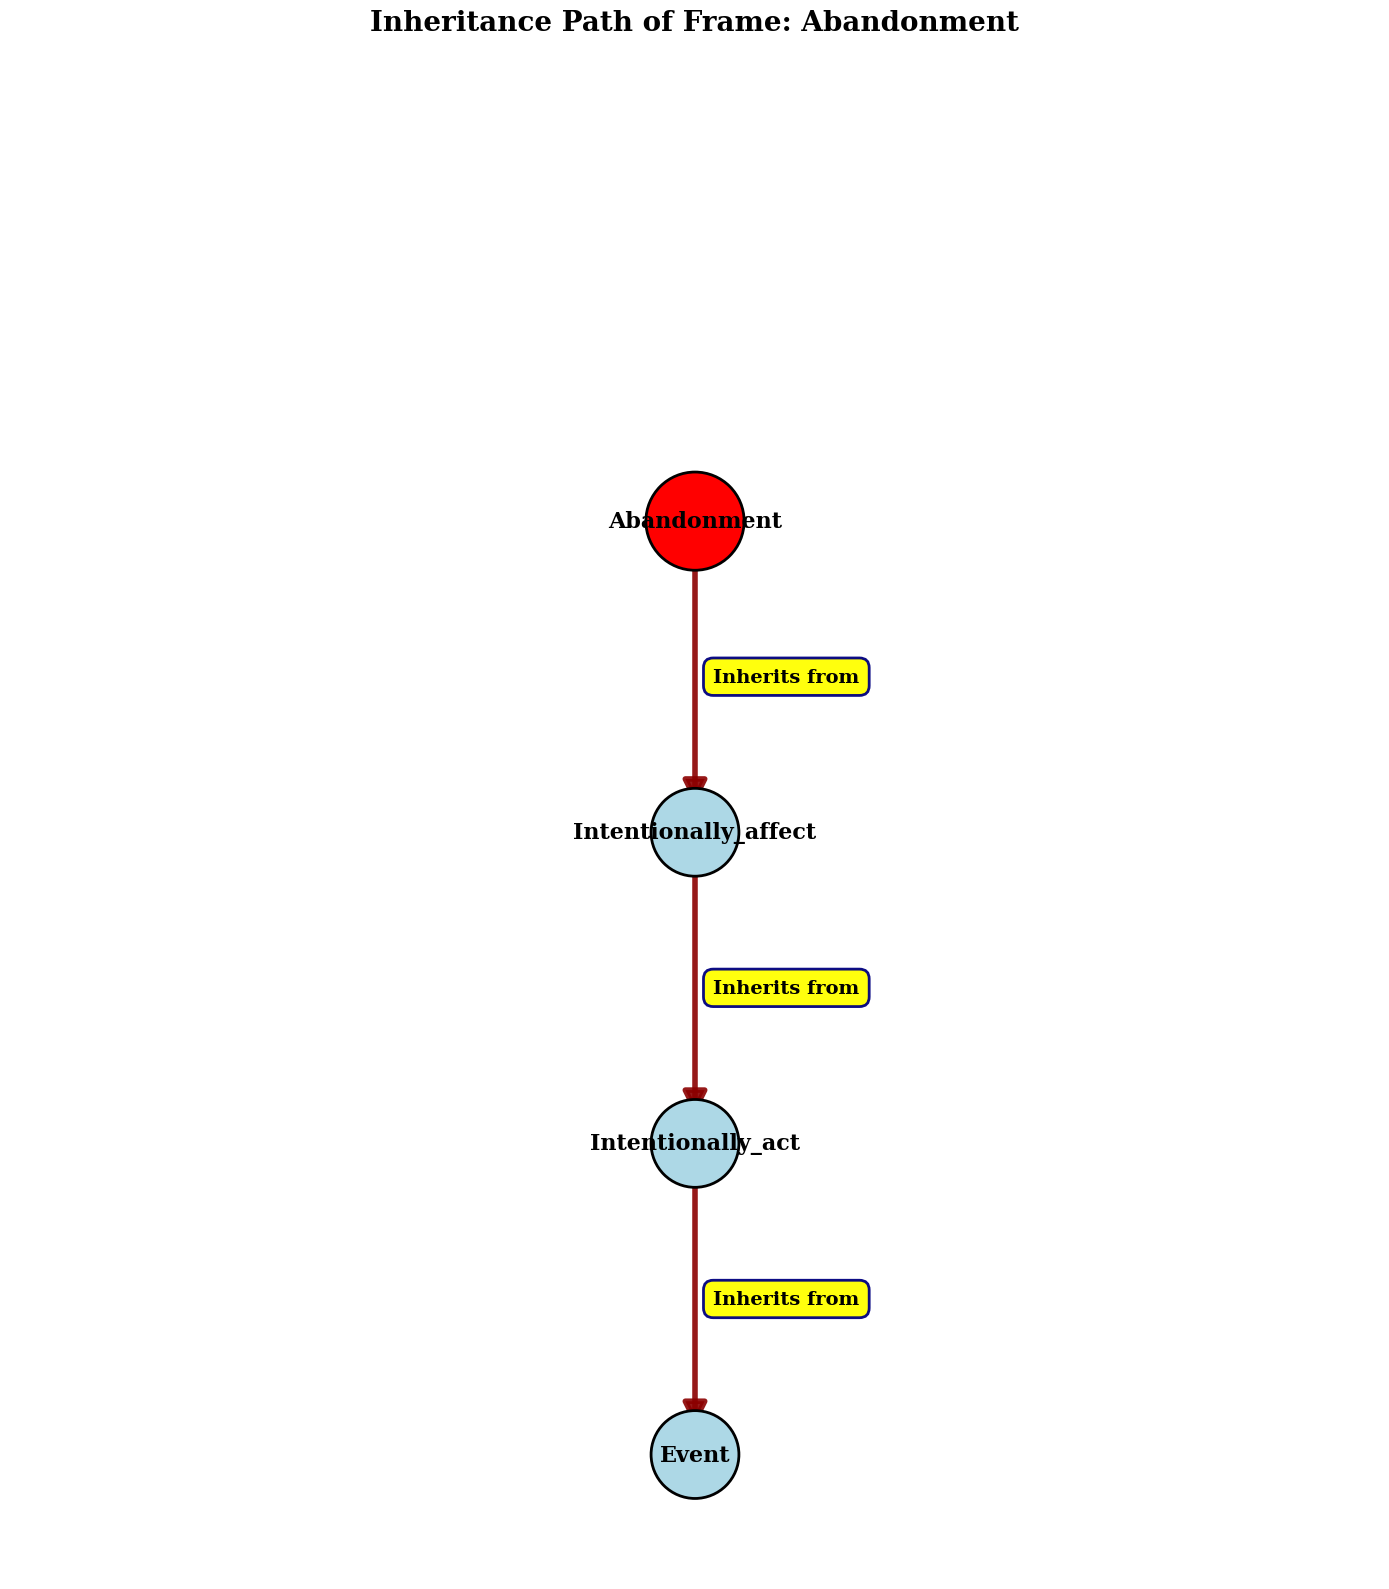

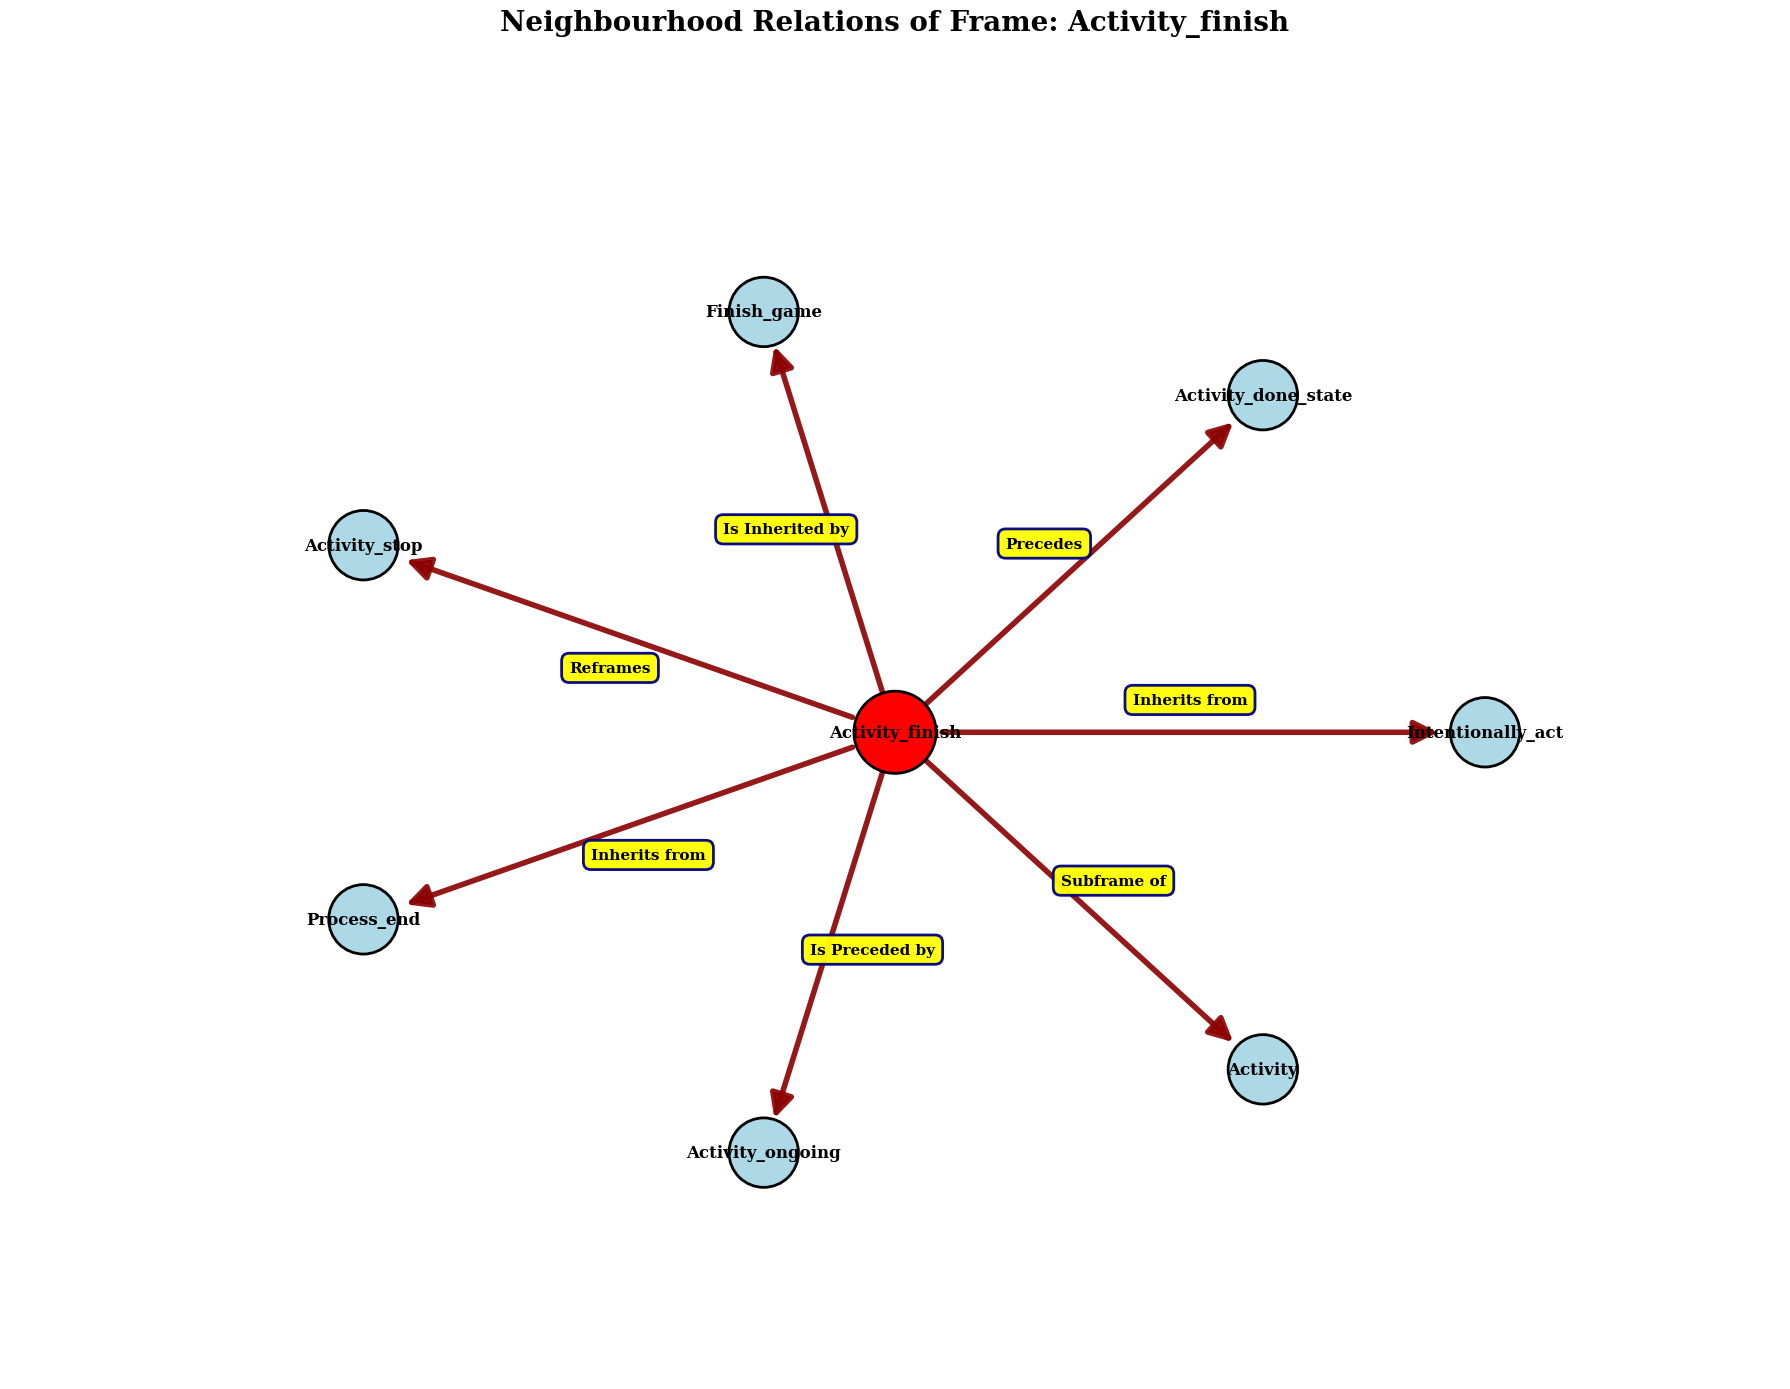

In [ ]:
# @title 🔍 Visualise FrameNet Data Structures

# Set font for better appearance (Colab compatible)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10

def visualize_frame_structure(frame_relations, target_frame, mode="neighbourhood", layout='spring', title=None, save_path=None):
    """
    Visualize frame semantic structure using extracted FrameNet data.
    """

    if target_frame not in frame_relations:
        print(f"[ERROR] Frame not found: {target_frame}")
        return

    if mode == "upward":
        if not title:
            title = f"Inheritance Path of Frame: {target_frame}"

        # Find inheritance path by following inheritance relations
        path = [target_frame]
        current = target_frame
        visited = {current}

        while True:
            parent_found = False
            relations = frame_relations.get(current, [])

            for neighbor, rel_type, direction, edge_label in relations:
                if neighbor in visited:
                    continue
                # Look for inheritance where current frame inherits from neighbor
                if rel_type == "Inheritance" and direction == "in":
                    path.insert(0, neighbor)  # Add parent at beginning
                    current = neighbor
                    visited.add(current)
                    parent_found = True
                    break

            if not parent_found:
                break

        # Create inheritance subgraph
        subgraph = nx.DiGraph()
        if len(path) == 1:
            subgraph.add_node(target_frame)
            print(f"[INFO] No inheritance path found for {target_frame}")
        else:
            for i in range(len(path) - 1):
                parent = path[i]
                child = path[i + 1]
                # Arrow from child to parent: child -> parent "Inherits from"
                subgraph.add_edge(child, parent, relation="Inherits from")

    elif mode == "neighbourhood":
        if not title:
            title = f"Neighbourhood Relations of Frame: {target_frame}"

        # Get all relations for the target frame
        relations = frame_relations.get(target_frame, [])

        # Collect all neighbor frames
        neighbors = set()
        for neighbor, rel_type, direction, edge_label in relations:
            neighbors.add(neighbor)

        # Create subgraph with all arrows FROM target frame
        subgraph = nx.DiGraph()
        subgraph.add_node(target_frame)
        subgraph.add_nodes_from(neighbors)

        # Add edges with labels from RELATION_LABELS
        for neighbor, rel_type, direction, edge_label in relations:
            # Get the appropriate label based on direction
            if rel_type in RELATION_LABELS:
                label_out, label_in = RELATION_LABELS[rel_type]
                if direction == "out":
                    label = label_out  # target gives the relation
                else:  # direction == "in"
                    label = label_in   # target receives the relation
            else:
                label = f"{rel_type} ({direction})"

            # All arrows point FROM target_frame TO neighbors
            subgraph.add_edge(target_frame, neighbor, relation=label)

    else:
        raise ValueError("mode must be 'neighbourhood' or 'upward'")

    if len(subgraph.nodes()) == 0:
        print(f"[ERROR] No nodes found for visualization")
        return

    # Layout calculation
    num_nodes = len(subgraph.nodes())

    if num_nodes == 1:
        pos = {list(subgraph.nodes())[0]: (0, 0)}
    elif mode == "upward":
        # Vertical hierarchical layout for inheritance
        nodes = list(subgraph.nodes())
        if subgraph.edges():
            try:
                ordered_nodes = list(nx.topological_sort(subgraph))
                pos = {}
                level_height = 5.0  # Large spacing
                for i, node in enumerate(ordered_nodes):
                    pos[node] = (0, (len(ordered_nodes) - i - 1) * level_height)
            except:
                pos = {node: (0, i * 5.0) for i, node in enumerate(reversed(nodes))}
        else:
            pos = {nodes[0]: (0, 0)}
    else:
        # Radial layout for neighbourhood - target in center
        pos = {}
        other_nodes = [n for n in subgraph.nodes() if n != target_frame]
        pos[target_frame] = (0, 0)

        if other_nodes:
            angle_step = 2 * np.pi / len(other_nodes)
            radius = 4.0
            for i, node in enumerate(other_nodes):
                angle = i * angle_step
                pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

    # Create figure with large size
    if mode == "upward":
        fig_height = max(16, len(subgraph.nodes()) * 4)
        fig, ax = plt.subplots(1, 1, figsize=(14, fig_height))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # Draw nodes
    node_colors = ["red" if n == target_frame else "lightblue" for n in subgraph.nodes()]
    if mode == "upward":
        node_sizes = [5000 if n == target_frame else 4000 for n in subgraph.nodes()]
    else:
        node_sizes = [3500 if n == target_frame else 2500 for n in subgraph.nodes()]

    nx.draw_networkx_nodes(subgraph, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          edgecolors='black',
                          linewidths=2,
                          ax=ax)

    # Draw node labels
    label_font_size = 16 if mode == "upward" else 12
    nx.draw_networkx_labels(subgraph, pos,
                           font_size=label_font_size,
                           font_weight="bold",
                           font_family='DejaVu Serif',
                           ax=ax)

    # Draw edges with relation labels
    for u, v, data in subgraph.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Calculate direction
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)

        if length > 0:
            dx_norm = dx / length
            dy_norm = dy / length

            # Adjust arrow positions to avoid node overlap
            node_radius = 0.4 if mode == "upward" else 0.3
            start_x = x1 + dx_norm * node_radius
            start_y = y1 + dy_norm * node_radius
            end_x = x2 - dx_norm * node_radius
            end_y = y2 - dy_norm * node_radius

            # Draw thick, prominent arrow
            arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                   arrowstyle='-|>',
                                   mutation_scale=35,
                                   color='darkred',
                                   linewidth=4,
                                   alpha=0.9)
            ax.add_patch(arrow)

            # Add relation label
            relation = data.get("relation", "")
            if relation:
                # Position label at edge midpoint
                label_x = (start_x + end_x) / 2
                label_y = (start_y + end_y) / 2

                # Offset label perpendicular to edge for readability
                perp_offset = 0.4 if mode == "upward" else 0.3
                perp_x = -dy_norm * perp_offset
                perp_y = dx_norm * perp_offset

                label_font_size = 14 if mode == "upward" else 11
                ax.text(label_x + perp_x, label_y + perp_y, relation,
                       fontsize=label_font_size,
                       ha='center',
                       va='center',
                       weight='bold',
                       family='DejaVu Serif',
                       bbox=dict(boxstyle="round,pad=0.5",
                               facecolor="yellow",
                               alpha=0.95,
                               edgecolor="navy",
                               linewidth=2))

    ax.set_title(title, fontsize=20, fontweight='bold', family='DejaVu Serif', pad=40)
    ax.axis("off")

    # Set axis limits to ensure everything is visible
    if mode == "upward":
        ax.set_xlim(-3, 3)
        ax.set_ylim(-2, len(subgraph.nodes()) * 5 + 2)
    else:
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)

    plt.tight_layout()
    if save_path:
         plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


visualize_frame_structure(frame_relations, "Abandonment", mode="upward", save_path="abandonment_inheritance.png")
visualize_frame_structure(frame_relations, "Activity_finish", mode="neighbourhood", save_path="activity_finish_neighbourhood.png")

In [ ]:
# @title 定义文件提取

# === 1. 修复版：提取纯定义文本，忽略 <ex> 例句 ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

# === 2. 使用 [CLS] 向量编码定义文本（DistilBERT版） ===
def encode_frame_definition(definition, tokenizer, model, device):
    inputs = tokenizer(
        definition,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding='max_length'
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state  # [B, T, H]
        cls_embedding = last_hidden[:, 0, :]     # 取 [CLS]
        return cls_embedding.squeeze(0).cpu()

# === 3. 主函数：编码所有定义 + 保存 ===
def encode_all_framenet_definitions(tokenizer, model, save_path, device):
    import pickle
    frame_definition_embeddings = {}
    skipped = []

    for frame in tqdm(fn.frames(), desc="Encoding FrameNet definitions"):
        name = frame["name"]
        raw_markup = ''.join(frame.get("definitionMarkup", []))
        definition = extract_pure_definition_from_markup(raw_markup)

        if definition == "[ParseError]" or not definition:
            skipped.append(name)
            continue

        try:
            emb = encode_frame_definition(definition, tokenizer, model, device)
            frame_definition_embeddings[name] = {
                "definition": definition,
                "embedding": emb.tolist()
            }
        except Exception as e:
            skipped.append(name)

    with open(save_path, "wb") as f:
        pickle.dump(frame_definition_embeddings, f)

    print(f"\n📦 成功保存 {len(frame_definition_embeddings)} 条定义嵌入，跳过 {len(skipped)} 条错误定义。")
    return frame_definition_embeddings, skipped

# === 4. 使用 distilbert-base-uncased 编码器 ===


definition_model_name = "distilbert-base-uncased"
definition_tokenizer = AutoTokenizer.from_pretrained(definition_model_name)
definition_model = AutoModel.from_pretrained(definition_model_name).to(device)

# === 5. 执行并保存 ===
save_path = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
frame_definition_embeddings, skipped = encode_all_framenet_definitions(
    definition_tokenizer, definition_model, save_path, device
)

# === 6. 打印前几个结果检查 ===
for i, (name, info) in enumerate(frame_definition_embeddings.items()):
    print(f"\n✅ Frame {i+1}: {name}")
    print("📝 Definition:", info["definition"])
    print("🔢 Embedding[:5]:", info["embedding"][:5])
    if i >= 4:
        break

# @title 定义文件保存
import pickle
save_path = "/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl"

with open(save_path, "wb") as f:
    pickle.dump(frame_definition_embeddings, f)

print(f"✅ 已保存定义嵌入到: {save_path}")

Encoding FrameNet definitions: 100%|██████████| 1221/1221 [00:06<00:00, 192.41it/s]



📦 成功保存 1221 条定义嵌入，跳过 0 条错误定义。

✅ Frame 1: Abandonment
📝 Definition: An Agent leaves behind a Theme effectively rendering it no longer within their control or of the normal security as one's property.
🔢 Embedding[:5]: [-0.19139738380908966, -0.02490539290010929, -0.1134403645992279, -0.05611336603760719, 0.018953654915094376]

✅ Frame 2: Abounding_with
📝 Definition: A Location is filled or covered with the Theme .  The Location is realized as the External Argument, and the Theme either as PP complement headed by with , in or of .

NB:  This frame does not include uses of adjectives like paved when they merely specify the Type of some location, as in "paved and unpaved roads".
🔢 Embedding[:5]: [-0.3714313209056854, 0.04469132795929909, -0.04548976570367813, -0.21898649632930756, -0.3817424774169922]

✅ Frame 3: Absorb_heat
📝 Definition: An Entity (generally food) is exposed to a Heat_source whose Temperature may also be specified.  Generally, the Entity undergoes some sort of change as 

📊 Cosine similarity stats (excluding self-match):
   Mean: 0.8911
   Std: 0.0338
   Min: 0.6452
   Max: 0.9988


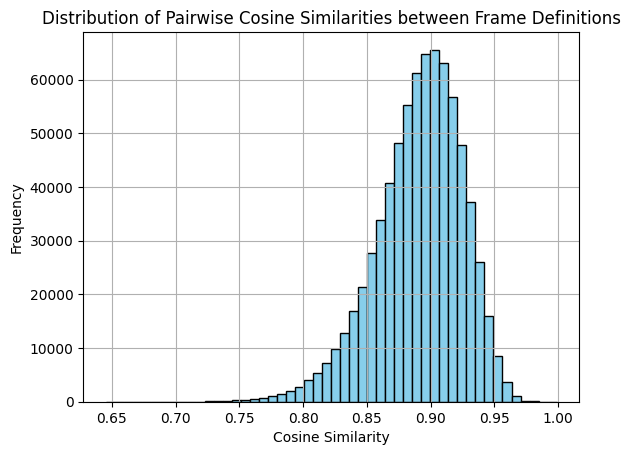

In [ ]:
# @title 定义相似度

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === 1. 加载定义嵌入 ===
with open("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl", "rb") as f:
    frame_def_embeddings = pickle.load(f)

# === 2. 提取所有向量与名称 ===
frame_names = list(frame_def_embeddings.keys())
embeddings = np.array([frame_def_embeddings[f]["embedding"] for f in frame_names])  # shape: [N, D]

# === 3. 计算余弦相似度矩阵 ===
sim_matrix = cosine_similarity(embeddings)  # shape: [N, N]

# === 4. 提取非对角元素（即非自身匹配） ===
all_sims = sim_matrix[np.triu_indices(len(frame_names), k=1)]

# === 5. 打印统计信息 ===
mean_sim = np.mean(all_sims)
std_sim = np.std(all_sims)
min_sim = np.min(all_sims)
max_sim = np.max(all_sims)

print(f"📊 Cosine similarity stats (excluding self-match):")
print(f"   Mean: {mean_sim:.4f}")
print(f"   Std: {std_sim:.4f}")
print(f"   Min: {min_sim:.4f}")
print(f"   Max: {max_sim:.4f}")

# === 6. 可视化分布 ===
plt.hist(all_sims, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Cosine Similarities between Frame Definitions")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# @title 📦 Construct and Analyse Frame Graph

def build_frame_graph(frame_relations):

    """
    Build the semantic frame graph using all FrameNet relation types.

    Args:
        frame_relations (dict): Mapping from a frame to a list of
                                (related_frame, relation_type, direction, edge_label) tuples.

    Returns:
        frame_graph (MultiDiGraph): A directed multi-relation graph of frame relationships.
        relation_levels (dict): Mapping from frame name to structural level (based on all relation types).
    """
    import networkx as nx
    from collections import deque

    frame_graph = nx.MultiDiGraph()

    # Add nodes and edges
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, edge_label in relations:
            if direction == "out":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
            elif direction == "in":
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)
            elif direction == "undirected":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)

    # Identify root nodes (no incoming edges of any kind)
    roots = [node for node in frame_graph.nodes() if frame_graph.in_degree(node) == 0]

    # Compute relation levels from all roots, using all relation types
    relation_levels = {}
    for root in roots:
        queue = deque([(root, 0)])
        visited = set([root])

        while queue:
            node, level = queue.popleft()
            if node in relation_levels:
                relation_levels[node] = min(relation_levels[node], level)
            else:
                relation_levels[node] = level

            for _, child, data in frame_graph.out_edges(node, data=True):
                if child not in visited:
                    visited.add(child)
                    queue.append((child, level + 1))

    # Assign -1 to nodes not reachable from any root
    for node in frame_graph.nodes():
        if node not in relation_levels:
            relation_levels[node] = -1

    return frame_graph, relation_levels


# Load previously saved data
print("Loading FrameNet data...")
try:
    with open("framenet_data.pkl", 'rb') as f:
        data = pickle.load(f)

    frame_relations = data['frame_relations']
    frame_definitions = data['frame_definitions']
    df = data['dataframe']

    print(f"Successfully loaded data: {len(frame_relations)} frame relations, {len(frame_definitions)} frame definitions")
except FileNotFoundError:
    print("Data file not found. Please run the data extraction script first.")
    import sys
    sys.exit(1)

# Build the frame graph and compute structure levels
print("\nBuilding full semantic relation graph...")
frame_graph, relation_levels = build_frame_graph(frame_relations)

# Basic graph statistics
print(f"The graph contains {frame_graph.number_of_nodes()} nodes and {frame_graph.number_of_edges()} edges")

# Analyse structural levels (depths from root using all relations)
print("\nAnalysing frame structure levels (based on all relation types)...")
level_counts = defaultdict(int)
for frame, level in relation_levels.items():
    level_counts[level] += 1

print("Number of frames per level:")
for level in sorted(level_counts.keys()):
    if level >= 0:
        print(f"  Level {level}: {level_counts[level]} frames")
print(f"  Unreachable (level = -1): {level_counts[-1]} frames")

# Identify root nodes (frames with no incoming edges)
roots = [n for n in frame_graph.nodes() if frame_graph.in_degree(n) == 0]
if roots:
    print(f"\nFound {len(roots)} root nodes (frames with no incoming edges):")
    for i, root in enumerate(sorted(roots)[:10]):
        print(f"  {i+1}. {root}")
    if len(roots) > 10:
        print(f"  ...and {len(roots)-10} more")

    # Compute the largest reachable subgraph from any root
    max_subtree_size = 0
    max_root = None
    for root in roots:
        queue = [root]
        visited = set([root])
        while queue:
            node = queue.pop(0)
            for successor in frame_graph.successors(node):
                if successor not in visited:
                    visited.add(successor)
                    queue.append(successor)
        if len(visited) > max_subtree_size:
            max_subtree_size = len(visited)
            max_root = root

    print(f"\nRoot of the largest reachable subgraph: '{max_root}' with {max_subtree_size} frames")

# Extra: print statistics about frame relation distribution
print("\nAnalysing relation density per frame...")
outgoing_counts = defaultdict(int)
incoming_counts = defaultdict(int)
relation_type_counter = defaultdict(int)

for u, v, data in frame_graph.edges(data=True):
    outgoing_counts[u] += 1
    incoming_counts[v] += 1
    relation_type_counter[data['relation']] += 1

total_frames = frame_graph.number_of_nodes()
no_outgoing = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0]
no_incoming = [f for f in frame_graph.nodes() if incoming_counts[f] == 0]
no_edges = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0 and incoming_counts[f] == 0]

print(f"Frames with no outgoing relations: {len(no_outgoing)}")
print(f"Frames with no incoming relations: {len(no_incoming)}")
print(f"Completely isolated frames (no relations at all): {len(no_edges)}")

# Print most relationally dense frames
dense_out = sorted(outgoing_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 frames by number of outgoing relations:")
for f, count in dense_out:
    print(f"  {f}: {count} outgoing")

# Print relation type frequency
print("\nRelation type distribution:")
for rel, count in sorted(relation_type_counter.items(), key=lambda x: -x[1]):
    print(f"  {rel}: {count} edges")

# Save graph and relation-level info
frame_graph_data = {
    'graph': frame_graph,
    'levels': relation_levels,
    'level_stats': dict(level_counts),
    'roots': roots
}
with open('frame_graph_analysis.pkl', 'wb') as f:
    pickle.dump(frame_graph_data, f)
print("\nGraph structure data saved to frame_graph_analysis.pkl")

# Analyse graph connectivity
print("\nAnalysing graph connectivity...")
connected_components = list(nx.weakly_connected_components(frame_graph))
largest_cc = max(connected_components, key=len)
print(f"Largest weakly connected component contains {len(largest_cc)} nodes "
      f"({len(largest_cc)/frame_graph.number_of_nodes():.1%} of total)")

# Compute graph diameter of largest component (undirected)
print("\nComputing diameter of largest connected component...")
try:
    largest_cc_subgraph = frame_graph.subgraph(largest_cc)
    diameter = nx.diameter(nx.Graph(largest_cc_subgraph))
    print(f"Diameter of the largest component: {diameter}")
except Exception as e:
    print(f"Error computing diameter: {e}")

print("\nFull frame graph analysis complete!")
